# Step 5:  Allostery Analysis

In this final step of the analysis, we import the calculated growth rates, allostery values (lit - dark growth rates), and associated allostery p-values. We then analyze these data to more deeply understand the relationship between growth rate, allostery, evolutionary conservation and co-evolution.

This notebook creates main text figures: 3-6

And supplemental figures: 1-4,6,7,
And supplmental tables: 2-7

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
import pandas as pd
import pickle 
from scipy import stats 
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna
from Bio.SeqUtils import seq3
from Bio.SeqUtils import seq1
from matplotlib import rcParams
import csv
import itertools
from Bio.PDB.PDBParser import PDBParser
from pathlib import Path #introduced in Python 3.4

## Import Variables from Step 4

This portion of the code (as well as later blocks) relies the following definitions (implemented in step 4):

In the growth rate matrices (avg_gr_lit and avg_gr_dark), a value of -1000 indicates that the mutation was missing at t=0 (not in the library), and a value of -999 indicates that there were too few time points with sufficient counts to allow fitting (the mutant dissappeared from the library too rapidly for growth rate assignment).

In the allostery matrix, a value of -1000 indicates that the mutation was missing at t=0 (not in the library), and a value of -999 indicates that the mutation had a growth rate consistent with a lack of activity (below DL121 D27N, justification in figure S5) in light and/or dark conditions (so allostery was not calculated).

In [14]:
#counts at t=0 
path_to_data = Path("../Step_4_calculating_allostery/output/t0_counts.pkl")
with open(path_to_data, mode="rb") as opened_file:
    t0_counts = pickle.load(opened_file)
    
#average growth rate in the light for all mutations
path_to_data = Path("../Step_4_calculating_allostery/output/avg_gr_lit.pkl")
with open(path_to_data, mode="rb") as opened_file:
    avg_gr_lit = pickle.load(opened_file)

#standard deviation of the growth rate in the light
path_to_data = Path("../Step_4_calculating_allostery/output/sd_gr_lit.pkl")
with open(path_to_data, mode="rb") as opened_file:
    sd_gr_lit = pickle.load(opened_file)

#average growth rate in the dark for all mutations
path_to_data = Path("../Step_4_calculating_allostery/output/avg_gr_dark.pkl")
with open(path_to_data, mode="rb") as opened_file:
    avg_gr_dark = pickle.load(opened_file)
    
#standard deviation of the growth rate in the dark
path_to_data = Path("../Step_4_calculating_allostery/output/sd_gr_dark.pkl")
with open(path_to_data, mode="rb") as opened_file:
    sd_gr_dark = pickle.load(opened_file)    

#allostery (lit-dark growth rate)
path_to_data = Path("../Step_4_calculating_allostery/output/allostery.pkl")
with open(path_to_data, mode="rb") as opened_file:
    allostery = pickle.load(opened_file)    

#allostery (lit-dark growth rate) not filtering catalytically dead
path_to_data = Path("../Step_4_calculating_allostery/output/allostery_all.pkl")
with open(path_to_data, mode="rb") as opened_file:
    allostery_all = pickle.load(opened_file) 
    
#allostery p-value
path_to_data = Path("../Step_4_calculating_allostery/output/allostery_pvals.pkl")
with open(path_to_data, mode="rb") as opened_file:
    allostery_pvals = pickle.load(opened_file)    
    
#allostery p-value not filtering catalytically dead
path_to_data = Path("../Step_4_calculating_allostery/output/allostery_pvals_all.pkl")
with open(path_to_data, mode="rb") as opened_file:
    allostery_pvals_all = pickle.load(opened_file)  
    
#allostery std deviation    
path_to_data = Path("../Step_4_calculating_allostery/output/allostery_sd.pkl")
with open(path_to_data, mode="rb") as opened_file:
    allostery_sd = pickle.load(opened_file)    
    
#allostery std deviation not filtering catalytically dead   
path_to_data = Path("../Step_4_calculating_allostery/output/allostery_sd_all.pkl")
with open(path_to_data, mode="rb") as opened_file:
    allostery_sd_all = pickle.load(opened_file)   

#growth rates for individual replicates in light
path_to_data = Path("../Step_4_calculating_allostery/output/all_gr_lit.pkl")
with open(path_to_data, mode="rb") as opened_file:
    all_gr_lit = pickle.load(opened_file)    

#growth rates for individual replicates in dark    
path_to_data = Path("../Step_4_calculating_allostery/output/all_gr_dark.pkl")
with open(path_to_data, mode="rb") as opened_file:
    all_gr_dark = pickle.load(opened_file)    
#dictionary of relative frequency of each mutant at each timepoint and vial
path_to_data = Path("../Step_4_calculating_allostery/output/vial_count_norm_mat.pkl")
with open(path_to_data, mode="rb") as opened_file:
    vial_count_norm_mat = pickle.load(opened_file) 

## Initialize experiment parameters

Define some key parameters of the experiment: WT sequence of DHFR and the mapping between vials in the turbidostat, DHFR mutant sublibraries, and experimental condition (lit/dark). 

We also define several residue groups of interest: 
   1. **The sector**, Sector composition at four significance cutoffs based on fitting the top significant eigenmodes of the SCA matrix to the Student’s t-distribution  (as defined in Reynolds et al (2011) Cell v.147 p. 1564 DOI: 10.1016/j.cell.2011.10.049) 
   2. **Evolutionarily conserved positions.** (defined using the same alignment as the sector, and taken at four cutoff levels. These cutoffs were chosen to yield the same number of positions as in the four different sector cutoffs, to facilitate comparison of statistics)
   3. **Surface accessible positions.** Accessible surface area was calculated by Michel Sanner's MSMS using a probe size of 1.4A, and excluding H2O and heteroatoms. Total surface areas for individual amino acids were taken from: http://www.imb-jena.de/IMAGE_AA.html, they cite C.Chothia, J. Mol. Biol., 105(1975)1-14. Together these were used to calculate relative solvent accessible area, and 25% was used as a cutoff for "surface".
   4. **Sector connected surface positions.** This was defined in Reynolds et al (2011) Cell v.147 p. 1564 DOI: 10.1016/j.cell.2011.10.049

In [15]:
#the wt sequence of DHFR
dhfr_wt = 'MISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPVIMGRHTWESIGRPLPGRKNIILSSQPGTDDRVTWVKSVDEAIAACGDVPEIMVIGGGRVYEQFLPKAQKLYLTHIDAEVEGDTHFPDYEPDDWESVFSEFHDADAQNSHSYCFEILERR'
dhfr_wt_ix = np.arange(len(dhfr_wt[:]))

#all amino acids
aas = 'ACDEFGHIKLMNPQRSTVWY*'
aas_ix = np.arange(len(aas[:]))

#the experiment
SL_comp = [list(range(40)),list(range(40,80)),list(range(80,120)),list(range(120,159))] #cutoffs between sublibraries. e.g. SL1=range(0,40)
SL_name = ['SL1','SL2','SL3','SL4']
vials = ['V1','V2','V3','V4','V5','V6'] 
lit_vials = ['V1','V2','V3']
dark_vials = ['V4','V5','V6']
vial_timepoints = [1,2,3,4,5,6]
act_time = [0, 4, 8, 12, 16, 20, 24]

#dimensions of stuff
nTP = len(act_time)
nSL = len(SL_comp)
n_pos = len(dhfr_wt)
n_aa = len(aas)
n_vials = len(vials)
n_rpts = len(lit_vials)

#cutoffs for slow growing mutations, based on the relative growth rate of DL121-D27N
cut_darkSlowGR = -0.1329
cut_litSlowGR = -0.1301

#residue categories 
#sector definitions at varying p-value cutoffs
secp_cutoffs = [.005,.008,.010,.015]
secdef = []
secdef.append([15,21,27,28,31,32,35,37,42,44,51,54,55,57,59,63,77,81,94,113,121,125,133])
secdef.append([11,15,21,22,27,28,31,32,35,37,39,40,42,44,47,50,51,54,55,56,57,59,63,64,\
               77,81,94,100,111,113,121,122,125,126,133,153])
secdef.append([3,11,15,21,22,27,28,31,32,35,37,39,40,42,44,47,49,50,51,52,54,55,56,57,59,63,64,\
              77,81,90,94,100,111,113,121,122,125,126,133,153])
secdef.append([3,5,11,13,15,18,21,22,25,27,28,31,32,35,37,39,40,42,44,45,47,49,50,51,52,53,54,55,\
              56,57,59,63,64,77,81,90,94,95,99,100,107,111,113,121,122,125,126,133,153])


#DHFR surface residues
surfRes = [1,10,11,12,16,17,18,19,20,21,23,25,28,29,32,33,36,37,38,44,45,48,49,50,51,52,55,56,\
           58,64,65,66,67,68,70,71,73,76,77,79,80,83,86,87,88,89,98,101,102,105,106,108,109,114,\
           116,118,120,121,122,123,124,127,129,130,131,132,134,135,136,137,138,139,140,141,142,\
           143,144,145,146,148,149,157,158,159]
surfRes.sort()


#sector connected surface positions at varying p-value cutoffs
sec_conn_surf_cutoffs = [.005,.008,.010,.015]
sec_conn_surf = []
sec_conn_surf.append([16,19,25,28,29,32,33,36,37,38,48,52,55,56,58,76,77,79,80,121,122])
sec_conn_surf.append([12,16,19,20,21,25,28,29,32,33,36,37,38,44,45,48,49,50,51,52,55,56,58,64,\
                      65,76,77,79,80,101,121,122,123,124,127])
sec_conn_surf.append([12,16,19,20,21,25,28,29,32,33,36,37,38,44,45,48,49,50,51,52,55,56,58,64,\
                      65,76,77,79,80,101,109,121,122,123,124,127])
sec_conn_surf.append([11,12,16,17,18,19,20,21,23,25,28,29,32,33,36,37,38,44,45,48,49,50,51,52,\
                      55,56,58,64,65,76,77,79,80,98,101,102,108,109,121,122,123,124,127])


#conservation values + sets of conserved residues
#First(0) is the position 1-159 (DHFR)
#the next four are calculated using three diff alignments
#Second(1) is Di_418_curated conservation scores (this is the alignment used in Reynolds et al 2011)
#Third(2) is Di_EggNOG conservation scores
#fourth(3) is Di_PSIBlast_Large conservation scores
DHFR_ConsVals = np.loadtxt('DHFR_ConsVals.txt', delimiter="\t")
consVals = {}
for k in range(len(DHFR_ConsVals)):
    consVals[DHFR_ConsVals[k,0]] = DHFR_ConsVals[k,1]
    
#define lists of conserved positions that are the same size as the sector
consposdef = []
consvals_cutoffs = []
all_consVals = np.array([k for k in consVals.values()])
for k in range(len(secdef)):
    print(len(secdef[k]))
    cutoff = np.sort(all_consVals)[-len(secdef[k])]
    consvals_cutoffs.append(cutoff)
    consPos = [key for key in consVals.keys() if consVals[key] >= cutoff]
    consposdef.append(consPos)
print('****** Sector positions:')
for i,sec in enumerate(secdef):
    print('cutoff: %1.4f' % secp_cutoffs[i])
    print('+'.join([str(k) for k in sec]))
print('****** Conserved positions:')
for i,consp in enumerate(consposdef):
    print('cutoff: %1.4f' % consvals_cutoffs[i])
    print('+'.join([str(int(k)) for k in consp]))
print('****** Sector connected surface positions:')
for i,scs in enumerate(sec_conn_surf):
    print('cutoff: %1.4f' % sec_conn_surf_cutoffs[i])
    print('+'.join([str(k) for k in scs]))



23
36
40
49
****** Sector positions:
cutoff: 0.0050
15+21+27+28+31+32+35+37+42+44+51+54+55+57+59+63+77+81+94+113+121+125+133
cutoff: 0.0080
11+15+21+22+27+28+31+32+35+37+39+40+42+44+47+50+51+54+55+56+57+59+63+64+77+81+94+100+111+113+121+122+125+126+133+153
cutoff: 0.0100
3+11+15+21+22+27+28+31+32+35+37+39+40+42+44+47+49+50+51+52+54+55+56+57+59+63+64+77+81+90+94+100+111+113+121+122+125+126+133+153
cutoff: 0.0150
3+5+11+13+15+18+21+22+25+27+28+31+32+35+37+39+40+42+44+45+47+49+50+51+52+53+54+55+56+57+59+63+64+77+81+90+94+95+99+100+107+111+113+121+122+125+126+133+153
****** Conserved positions:
cutoff: 1.8900
7+14+15+21+22+27+31+35+42+43+44+46+47+54+57+61+63+95+96+100+113+122+133
cutoff: 1.5400
5+7+14+15+20+21+22+27+31+35+40+41+42+43+44+46+47+49+54+55+57+59+61+63+64+94+95+96+100+113+115+122+125+126+133+153
cutoff: 1.4900
5+7+14+15+20+21+22+27+31+35+40+41+42+43+44+45+46+47+49+54+55+57+59+60+61+63+64+94+95+96+99+100+113+115+121+122+125+126+133+153
cutoff: 1.3800
5+7+11+14+15+18+20+21+22+27+3

## 1. Examine library completeness.

What is the distribution of mutations present at t=0 (the first timepoint of our experiment)?

/Users/kimreynol/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


244 (7.31%) mutants are missing at t=0


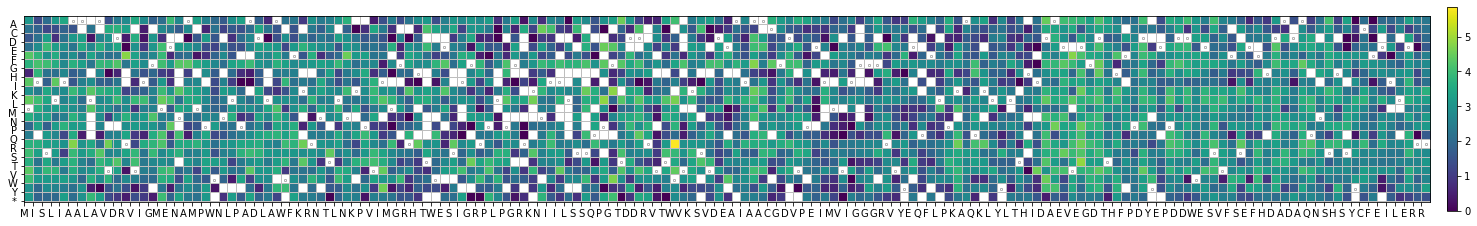

In [16]:
#heatmap of the t=0 matrix
plt.rcParams['figure.figsize'] = (30,15)
plt.imshow(np.log10(t0_counts.T), cmap='viridis', interpolation='none')
plt.colorbar(shrink = 0.25, orientation = 'vertical', pad = 0.01)
dim = t0_counts.T.shape
yticks=np.arange(dim[0]); xticks = np.arange(dim[1])
ylabel = aas; xlabel= dhfr_wt
plt.xticks(xticks-0.5,xlabel)
plt.yticks(yticks+0.4,ylabel)
plt.grid(color = '#BEBEBE',linestyle = '-',linewidth = 1)

for p in range(n_pos):
    for a in range(n_aa):
        if dhfr_wt[p] ==aas[a]:
            #add indicators to the WT residues
            plt.plot(p,a,'ws',markeredgecolor='#000000', markersize=1.8,mew=0.3)

n_mut_absT0 = t0_counts.size - np.count_nonzero(t0_counts) - 159 
print('%i (%1.2f%%) mutants are missing at t=0'%(n_mut_absT0,n_mut_absT0/(t0_counts.size)*100))
#plt.savefig('FigPanels/LibraryCompleteness.pdf', format='pdf', dpi=300, pad_inches=1) 

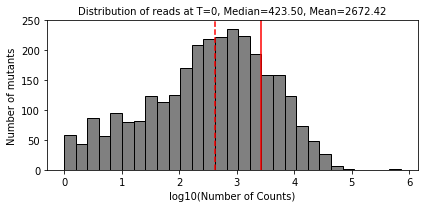

In [17]:
#distribution of counts per mutant at t=0, excluding absent mutants, but including WT.
plt.rcParams['figure.figsize'] = (6,3)
f, (ax) = plt.subplots(1)
t0_counts_nonzero = [ct for ct in t0_counts.flatten() if ct !=0]
ax.hist(np.log10(t0_counts_nonzero),bins='auto',edgecolor='k',color='grey')
median_counts = np.median(t0_counts_nonzero)
mean_counts = np.mean(t0_counts_nonzero)
plt.plot([np.log10(median_counts),np.log10(median_counts)],[0,250],'--r')
plt.plot([np.log10(mean_counts),np.log10(mean_counts)],[0,250],'-r')
plt.ylim([0,250])
plt.ylabel('Number of mutants'); plt.xlabel('log10(Number of Counts)')
plt.title('Distribution of reads at T=0, Median=%.2f, Mean=%.2f' % (median_counts,mean_counts), fontsize=10)
plt.tight_layout()
#plt.savefig('FigPanels/LibraryCountDist.pdf', format='pdf', dpi=300, pad_inches=1) 

**Statistics on number of mutants present in the library/how many for which we can reliably estimate growth rates.**

In [18]:
n_gr_missing = list((avg_gr_lit.flatten() == -1000) | (avg_gr_dark.flatten() == -1000)).count(True) - 159 
n_gr_toolow_dark = list(avg_gr_dark.flatten() == -999).count(True)
n_gr_toolow_lit = list(avg_gr_lit.flatten() == -999).count(True)
n_gr_toolow_both = list((avg_gr_lit.flatten() == -999) | (avg_gr_dark.flatten() == -999)).count(True)
n_allo_undeter = list(allostery.flatten()).count(-1000) - 159 
n_allo_undeter = n_allo_undeter + list(allostery.flatten()).count(-999)

print('%i mutants are missing in both the lit and dark states (absent at t=0) (%.2f%%)'%\
      (n_gr_missing, 100*(n_gr_missing/avg_gr_dark.size)))
print('%i mutants dissappear too rapidly for growth rate calculation in the lit state (%.2f)' %\
     (n_gr_toolow_lit, 100*(n_gr_toolow_lit/avg_gr_lit.size)))
print('%i mutants dissappear too rapidly for growth rate calculation in the dark state (%.2f)' %\
     (n_gr_toolow_dark, 100*(n_gr_toolow_dark/avg_gr_dark.size)))
print('%i mutants dissappear too rapidly for growth rate calculation in at least one state (%.2f)' %\
     (n_gr_toolow_both, 100*(n_gr_toolow_both/avg_gr_lit.size)))


print('Allostery could not be computed for %i mutants (%.2f%%), out of %i measurements'%\
      (n_allo_undeter, 100*(n_allo_undeter/(avg_gr_dark.size-159)), avg_gr_dark.size - 159))
print('%i were regarded as catalytically inactive, %i were not present' % \
      (np.sum(allostery == -999), (np.sum(allostery == -1000)-159)))


print('when excluding stop codons: ')
n_allo_undeter = (np.sum(allostery[:,0:20] == -999) + (np.sum(allostery[:,0:20] == -1000) - 159))
print('Allostery could not be computed for %i mutants (%.2f%%), out of %i measurements'%\
      (n_allo_undeter, 100*(n_allo_undeter/(avg_gr_dark.size-(159*2))), avg_gr_dark.size -(159*2)))      
print('%i were regarded as catalytically inactive, %i were not present' % \
      (np.sum(allostery[:,0:20] == -999), np.sum(allostery[:,0:20] == -1000)-159))

244 mutants are missing in both the lit and dark states (absent at t=0) (7.31%)
718 mutants dissappear too rapidly for growth rate calculation in the lit state (21.50)
712 mutants dissappear too rapidly for growth rate calculation in the dark state (21.32)
721 mutants dissappear too rapidly for growth rate calculation in at least one state (21.59)
Allostery could not be computed for 1586 mutants (49.87%), out of 3180 measurements
1342 were regarded as catalytically inactive, 244 were not present
when excluding stop codons: 
Allostery could not be computed for 1473 mutants (48.76%), out of 3021 measurements
1247 were regarded as catalytically inactive, 226 were not present


## 2. Evaluating growth rate data

**Examine reproducibility across vials - correlation plots and $R^2$**

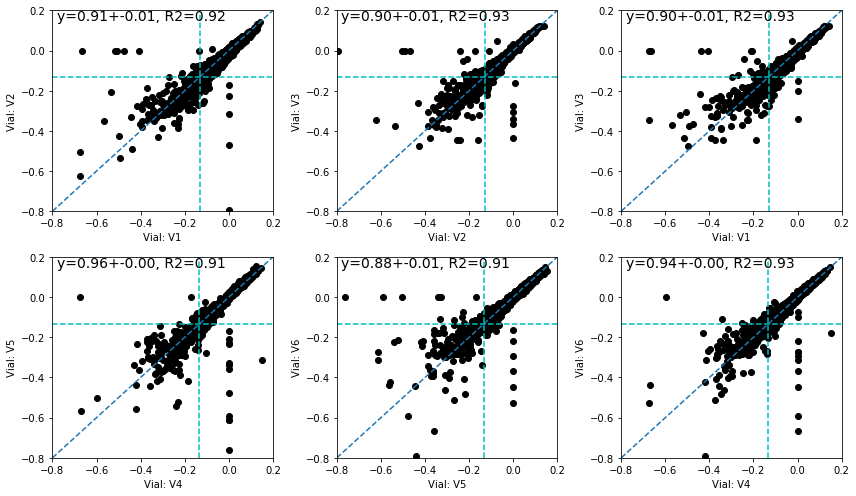

In [19]:
vial_growthrate_arrays = [all_gr_lit,all_gr_dark]
vial_labels = [lit_vials,dark_vials]
vial_pairs = [[0,1],[1,2],[0,2]]
plt.rcParams['figure.figsize'] = (12,7)
for i,v_array in enumerate(vial_growthrate_arrays):
    for p,pair in enumerate(vial_pairs):
        plt.subplot(2,3,(i*3)+p+1)
        plt.plot(v_array[:,:,pair[0]],v_array[:,:,pair[1]],'ok')
        plt.plot([-0.8,0.2],[-0.8,0.2],'--')
        plt.xlim([-0.8,0.2]);plt.ylim([-0.8,0.2])
        m,b,r,pval,se = stats.linregress(v_array[:,:,pair[0]].flatten(),v_array[:,:,pair[1]].flatten())
        fit_str = ('y=%.2f+%.2f, R2=%.2f'%(m,b,r))
        plt.text(-0.78,0.15,fit_str,fontsize=14)
        plt.xlabel('Vial: '+vial_labels[i][pair[0]],fontsize=10)
        plt.ylabel('Vial: '+vial_labels[i][pair[1]],fontsize=10)
        if i == 0:
            plt.plot([cut_litSlowGR, cut_litSlowGR],[-0.8,0.2],'c--')
            plt.plot([-0.8,0.2],[cut_litSlowGR, cut_litSlowGR],'c--')
        else:
            plt.plot([cut_darkSlowGR, cut_darkSlowGR],[-0.8,0.2],'c--')
            plt.plot([-0.8,0.2],[cut_darkSlowGR, cut_darkSlowGR],'c--')
plt.tight_layout()
#plt.savefig('FigPanels/Reproducibility.pdf', format='pdf')

**Examine growth rate fits and data quality for a handful of individual mutants**

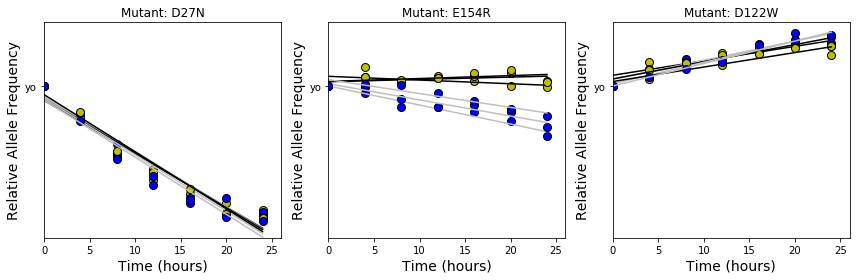

In [20]:
#select three mutations of interest and plot the replicate 
#measurements in both lit and dark comparison. goal is to 
#assess data and fit quality for a representative examples.
plt.rcParams['figure.figsize'] = (12,4)
#mutchoice = ['E154R','D132F','G86K']
mutchoice = ['D27N','E154R','D122W']
for m,mut in enumerate(mutchoice):
    p = int(mut[1:-1])-1 #remember to substract one to account for matrix start at zero
    a = aas.index(mut[-1])
    plt.subplot(1,len(mutchoice),m+1)
    for rpt in range(n_rpts):
        v=lit_vials[rpt]
        plt.plot(act_time,vial_count_norm_mat[v][p,a,:],'yo',markeredgecolor='k',markersize=8)
        if (True in list(np.isinf(vial_count_norm_mat[v][p,a,:]))):
            stop_fit_ix = list(np.isinf(vial_count_norm_mat[v][p,a,:])).index(True) 
        else:
            stop_fit_ix = len(vial_count_norm_mat[v][p,a,:])
        m,b,r,pval,se = stats.linregress(act_time[0:stop_fit_ix],vial_count_norm_mat[v][p,a,0:stop_fit_ix])
        plt.plot(act_time,[m*t+b for t in act_time],'-k','yo')
        
        v=dark_vials[rpt]
        plt.plot(act_time,vial_count_norm_mat[v][p,a,:],'bo',markeredgecolor='k',markersize=8)
        if (True in list(np.isinf(vial_count_norm_mat[v][p,a,:]))):
            stop_fit_ix = list(np.isinf(vial_count_norm_mat[v][p,a,:])).index(True) 
        else:
            stop_fit_ix = len(vial_count_norm_mat[v][p,a,:])
        m,b,r,pval,se = stats.linregress(act_time[0:stop_fit_ix],vial_count_norm_mat[v][p,a,0:stop_fit_ix])
        plt.plot(act_time,[m*t+b for t in act_time],'-k', color='#bfbebe')

        plt.xlim([0,26]); plt.ylim([-3.6,1.5])
        plt.xlabel('Time (hours)',fontsize=14), plt.ylabel('Relative Allele Frequency',fontsize=14)
        plt.title('Mutant: %s'% mut)
plt.tight_layout()
#plt.savefig('FigPanels/RepAlleleFreq.pdf')

## 3. Examine the effects of mutations on growth rate 

Before looking at allostery, we examine how individual mutations influence growth (and presumably, DHFR function)

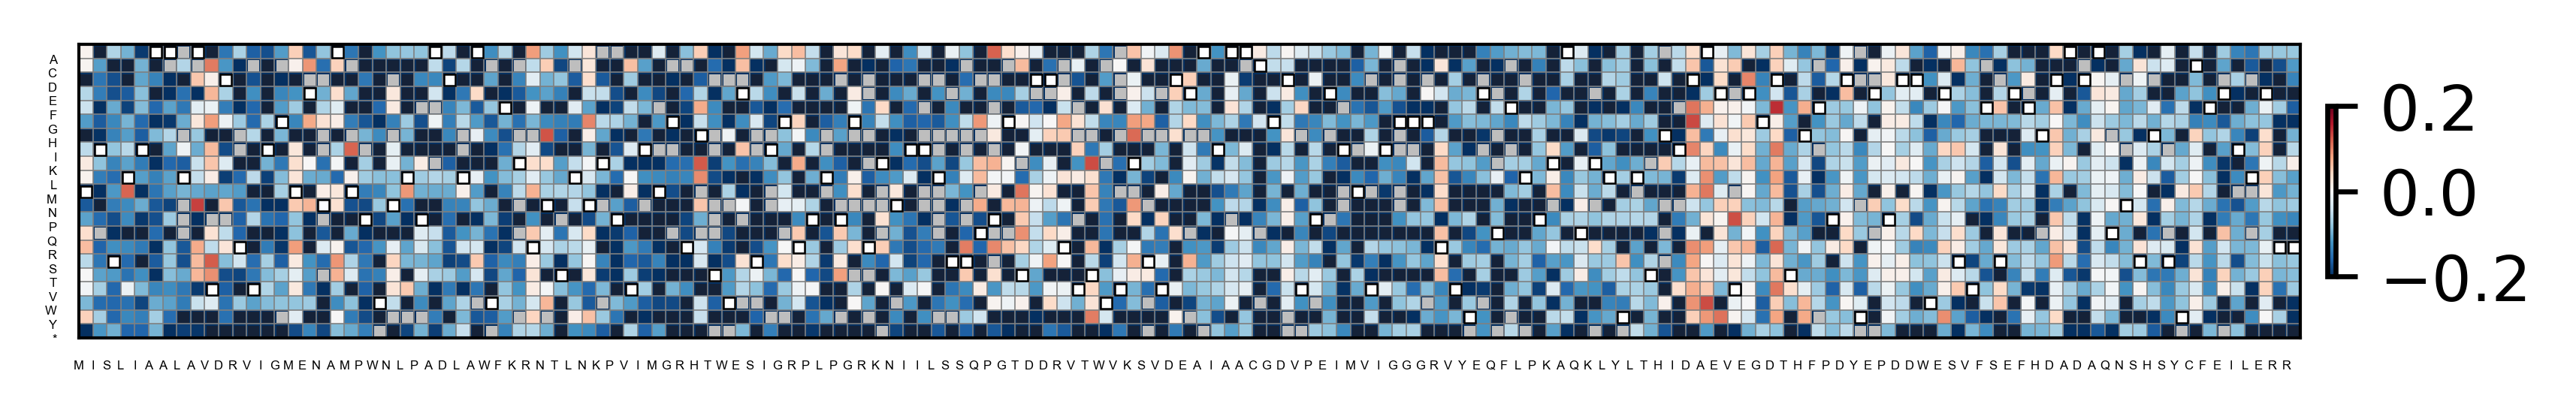

In [21]:
#heatmap of the growth rate
plt.rcParams['figure.figsize'] = (7.5714,1)
plt.rcParams["figure.dpi"] = 600

font = {'family': 'arial',
        'color':  'black',
        'weight': 'normal',
        'size': 2,
        }
f, (ax) = plt.subplots(1)

for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(0.5)
ax.tick_params(axis='both', which='major',length=0, width=0)

#plot the heat map for dark growth rates.
plt.imshow(avg_gr_dark.T, cmap='RdBu_r', interpolation='none',vmin=-0.2,vmax=0.2, aspect='equal')
plt.colorbar(shrink = 0.5, orientation = 'vertical', pad = 0.01)
dim = avg_gr_dark.T.shape
yticks=np.arange(dim[0]); xticks = np.arange(dim[1])
ylabel = aas; xlabel= dhfr_wt
plt.xticks(xticks-0.5,xlabel, **font)
plt.yticks(yticks+0.5,ylabel, **font)

for p in range(n_pos):
    for a in range(n_aa):
        if avg_gr_dark.T[a,p] == -1000:
            if dhfr_wt[p] ==aas[a]:
                #color WT residues white
                plt.plot(p,a,'ws',markeredgecolor='#000000', markersize=1.8,mew=0.3)
            else:
                #color points without data dark grey.
                plt.plot(p,a,'s', markerfacecolor='#BEBEBE', markeredgecolor='#808080', markersize=1.8,mew=0)
        elif avg_gr_dark.T[a,p] == -999:
            #color mutations which "dissappeared" to early to be fit navy blue
            plt.plot(p,a,'s',markerfacecolor='#152238', markersize=1.8,mew=0)
        
plt.grid(which='major',axis='both',color = '#808080',linestyle = '-',linewidth = 0.2)

#plt.savefig('FigPanels/Dark_gr_heatmap2.pdf',transparent=True, format='pdf', dpi=600)

#### Distribution of growth rate effects.

Mean gr dark cut, : -0.19283088, not cut: -0.04702
Mean gr lit cut, : -0.18944201, not cut: -0.04336


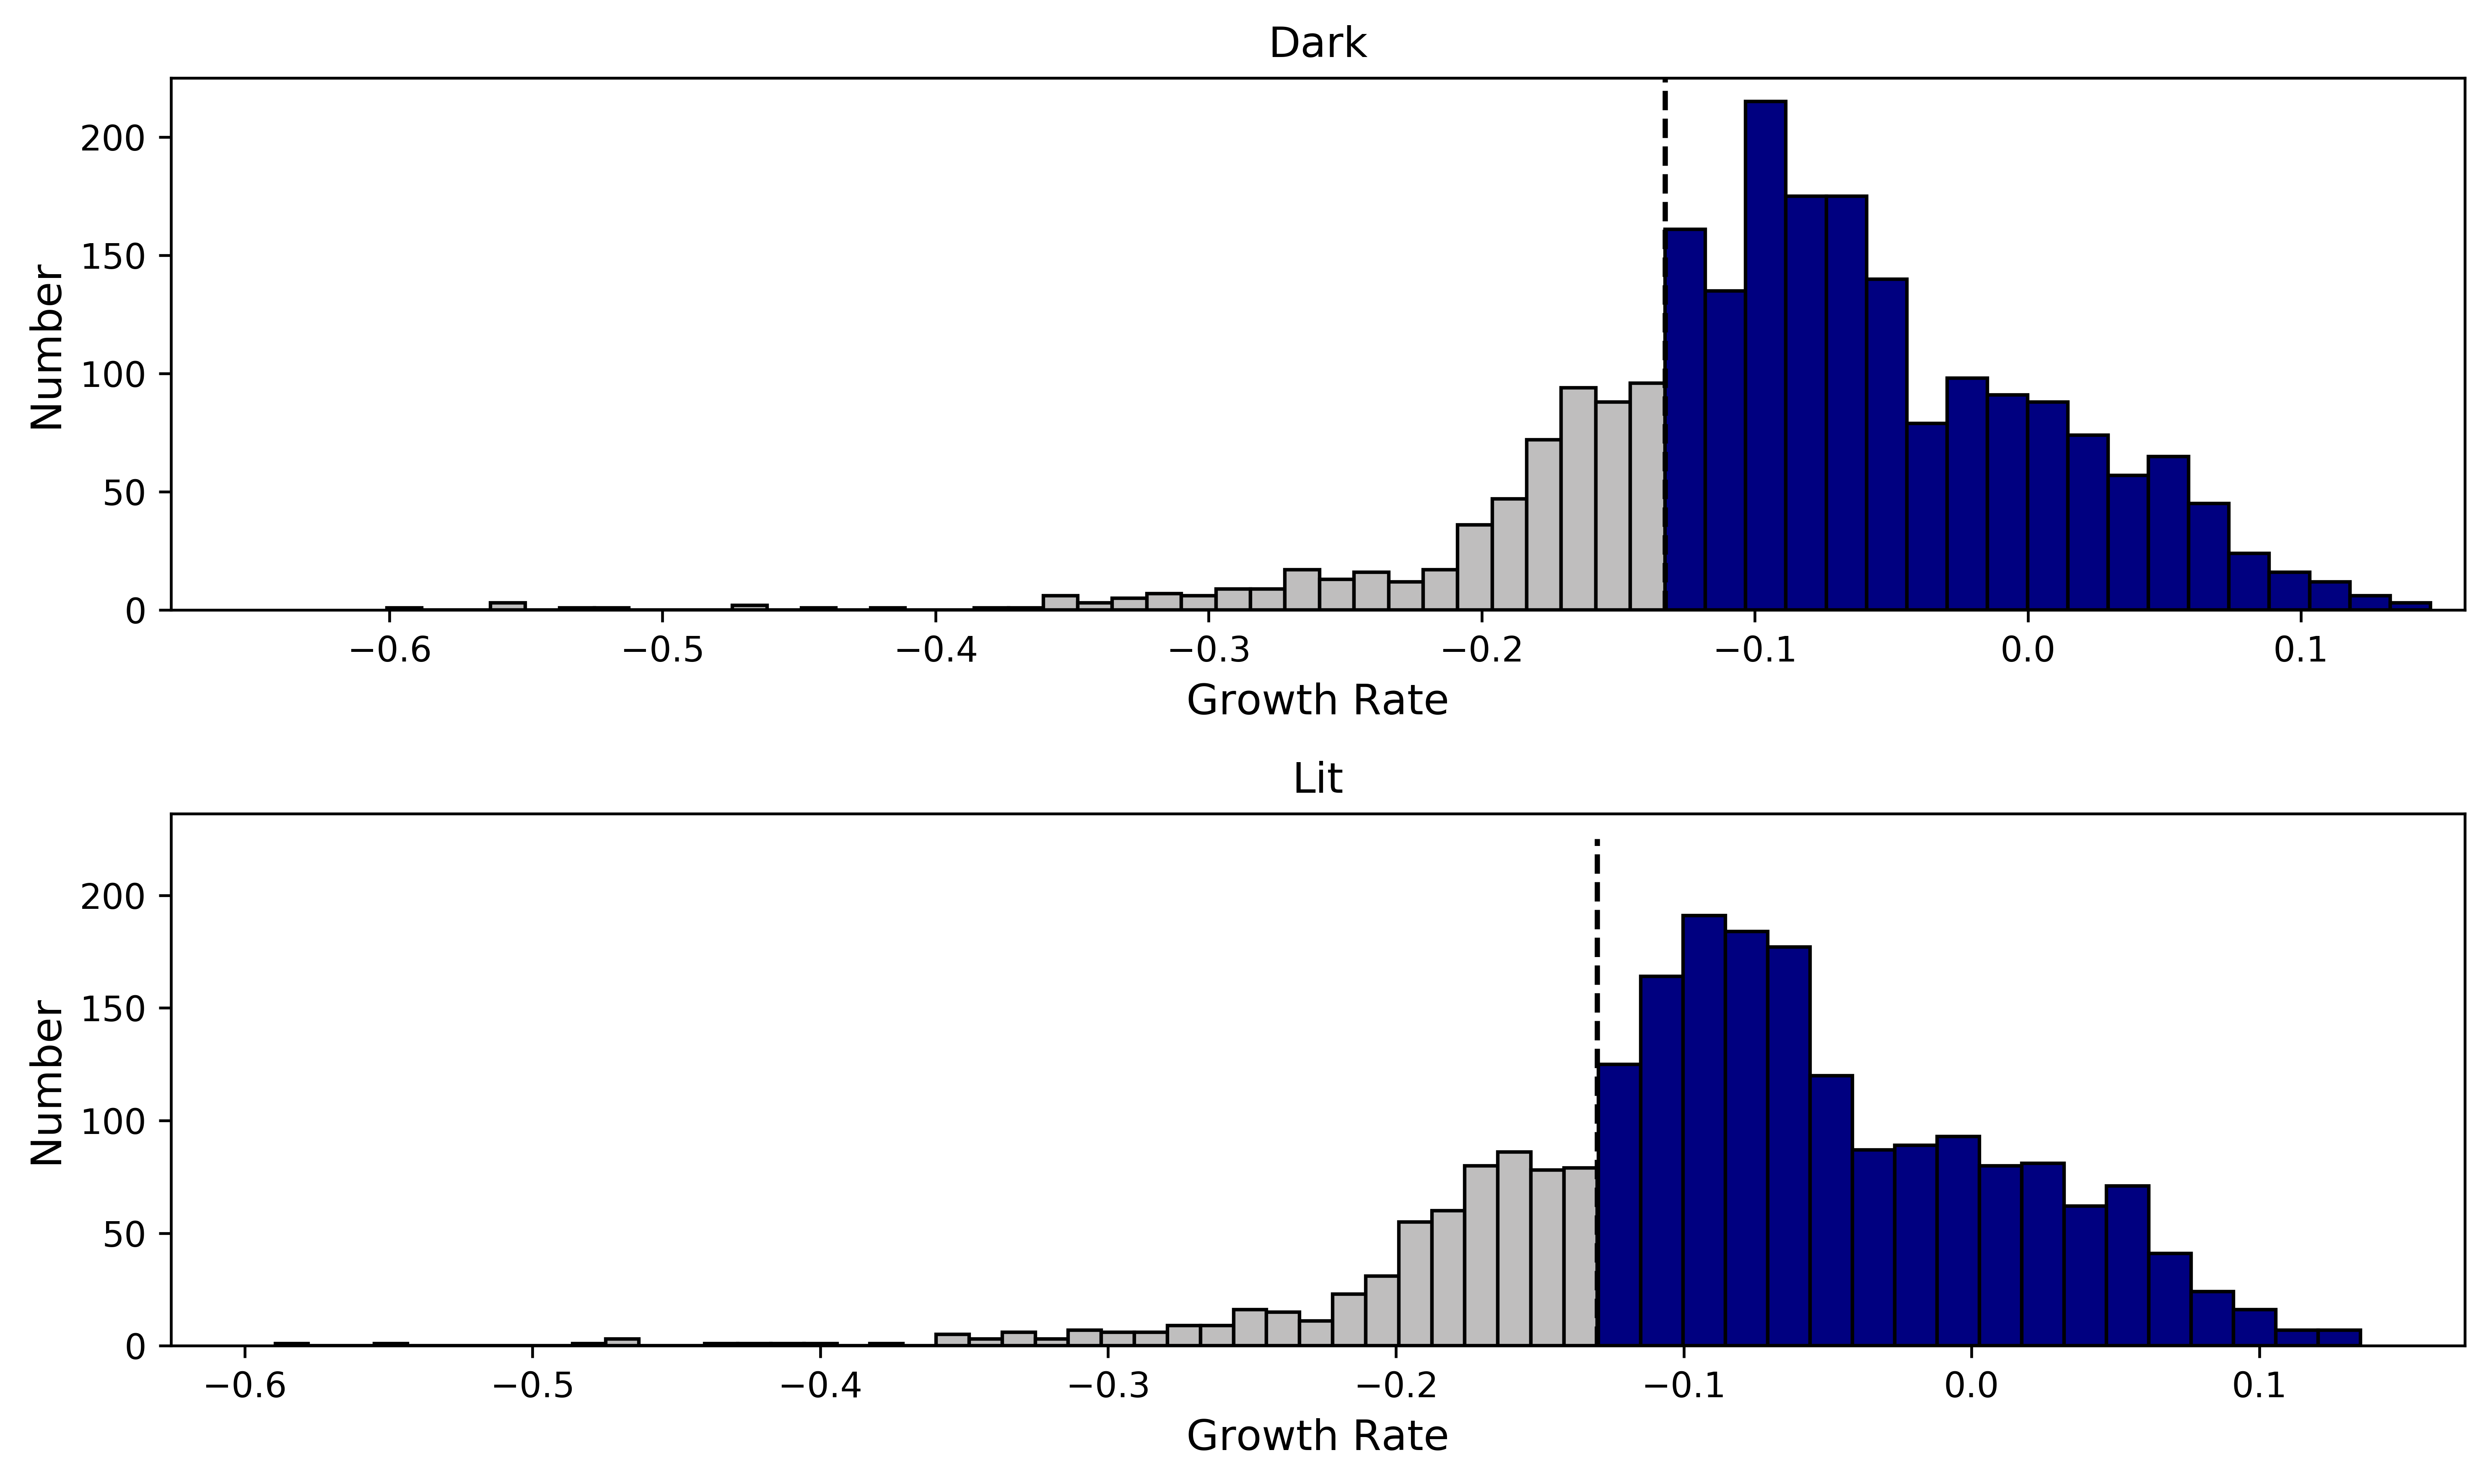

In [22]:
plt.rcParams['figure.figsize'] = (10,6)

plt.subplot(211)
avg_gr_dark_low_filtered = [gr for gr in avg_gr_dark.flatten() if (gr > -999 and gr < cut_darkSlowGR)]
avg_gr_dark_high_filtered = [gr for gr in avg_gr_dark.flatten() if (gr > -999 and gr > cut_darkSlowGR)]
plt.hist(avg_gr_dark_low_filtered,bins='auto',edgecolor='k', color='#bfbebe')
plt.hist(avg_gr_dark_high_filtered,bins='auto',color='navy',edgecolor='k')
plt.plot([cut_darkSlowGR,cut_darkSlowGR],[0,225],'k--')
plt.ylim([0,225])
print('Mean gr dark cut, : %.8f, not cut: %.5f'%\
      (np.mean(avg_gr_dark_low_filtered),np.mean(avg_gr_dark_high_filtered)))
plt.xlim([-0.68,0.16])
plt.xlabel('Growth Rate',fontsize=12); plt.ylabel('Number',fontsize=12);plt.title('Dark')



plt.subplot(212)
avg_gr_lit_low_filtered = [gr for gr in avg_gr_lit.flatten() if (gr > -999 and gr < cut_litSlowGR)]
avg_gr_lit_high_filtered = [gr for gr in avg_gr_lit.flatten() if (gr > -999 and gr > cut_litSlowGR)]
plt.hist(avg_gr_lit_low_filtered,bins='auto',edgecolor='k', color='#bfbebe')
plt.hist(avg_gr_lit_high_filtered,bins='auto',color='navy',edgecolor='k')
plt.plot([cut_litSlowGR,cut_litSlowGR],[0,225],'k--')
print('Mean gr lit cut, : %.8f, not cut: %.5f'%\
      (np.mean(avg_gr_lit_low_filtered),np.mean(avg_gr_lit_high_filtered)))
#plt.xlim([-0.8,0.2])
#plt.xlim([-0.7,0.2])
plt.xlabel('Growth Rate',fontsize=12); plt.ylabel('Number',fontsize=12);plt.title('Lit')
plt.tight_layout()
#plt.savefig('FigPanels/growth_rate_histogram.pdf', format='pdf', dpi=300, pad_inches=1)


Mean gr dark, all pos: -0.08406076, sector pos: -0.10635
Mean gr lit, all pos: -0.08281485, sector pos: -0.11068


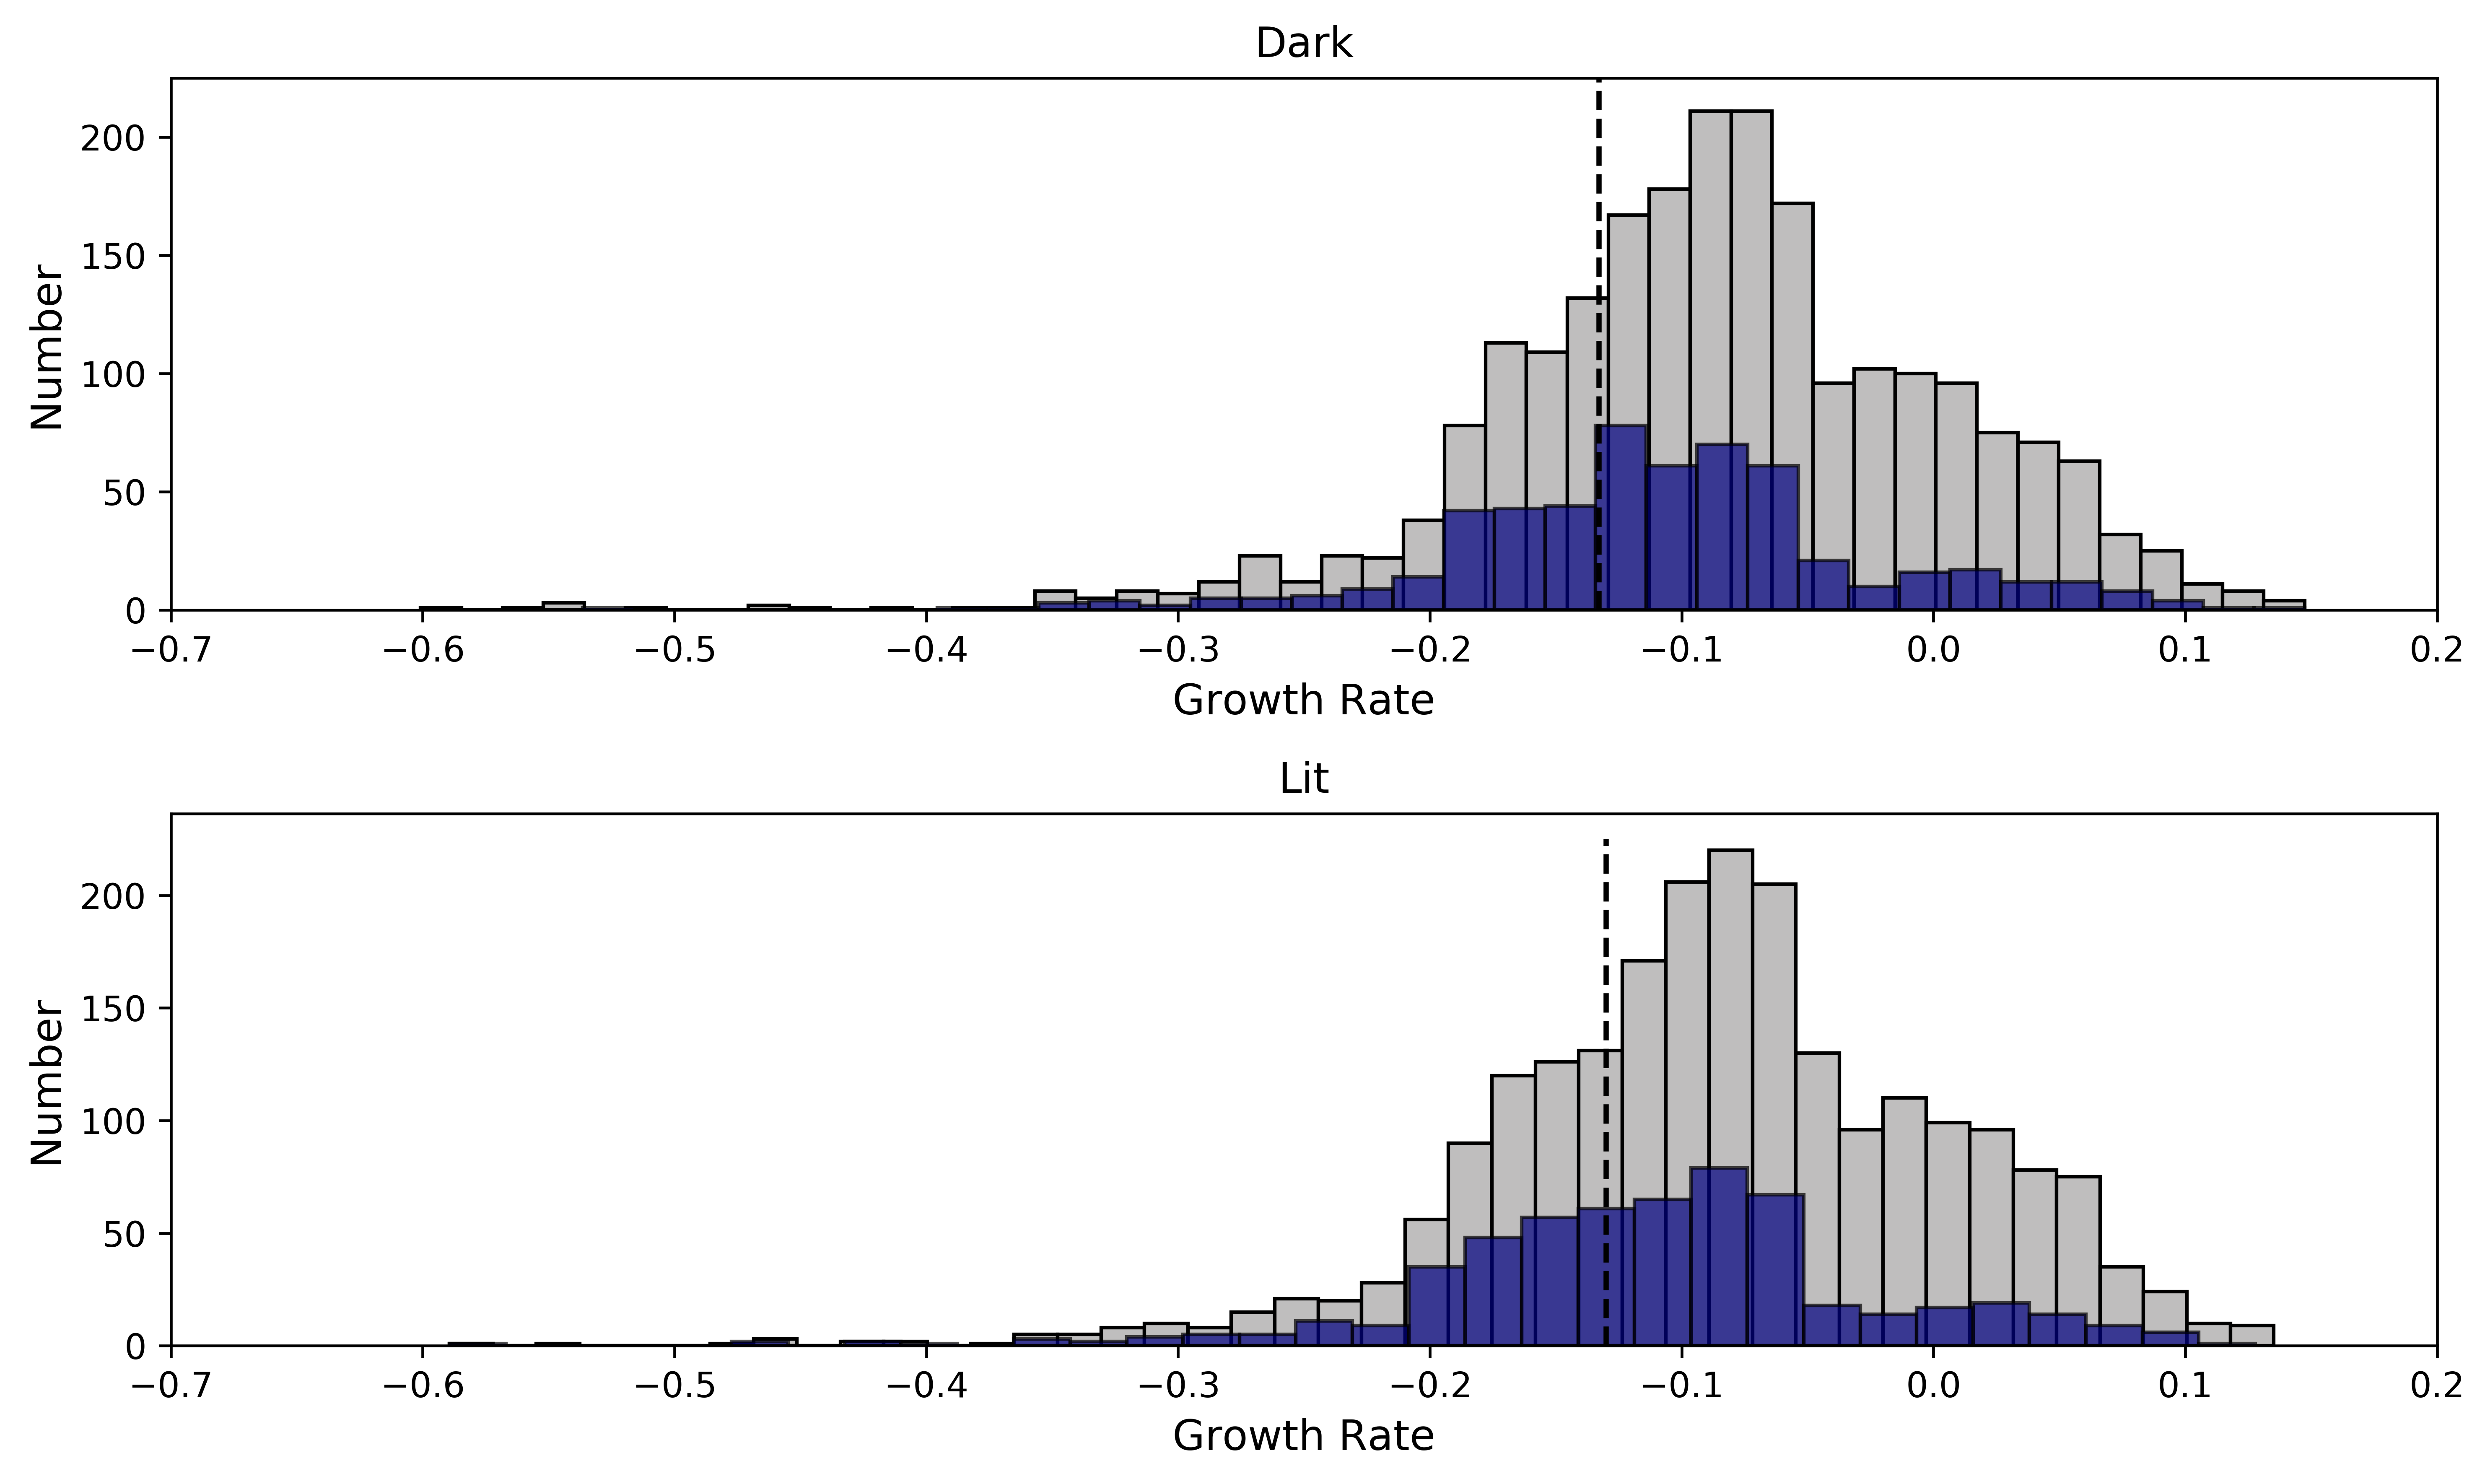

In [23]:
plt.rcParams['figure.figsize'] = (10,6)

plt.subplot(211)
sector = secdef[2] #select sector cutoff of interest. for figs in maintext, using 0.01
avg_gr_dark_filtered = [gr for gr in avg_gr_dark.flatten() if gr > -999]
avg_gr_dark_sector = avg_gr_dark[np.ix_([int(k-1) for k in sector]),:]
avg_gr_dark_sector_filtered = [gr for gr in avg_gr_dark_sector.flatten() if gr > -999]
plt.hist(avg_gr_dark_filtered,bins='auto',edgecolor='k', color='#bfbebe')
plt.hist(avg_gr_dark_sector_filtered,bins='auto',color='navy',edgecolor='k',alpha=0.7)
plt.plot([cut_darkSlowGR,cut_darkSlowGR],[0,225],'k--')
plt.ylim([0,225])
print('Mean gr dark, all pos: %.8f, sector pos: %.5f'%\
      (np.mean(avg_gr_dark_filtered),np.mean(avg_gr_dark_sector_filtered)))
#plt.xlim([-0.8,0.2])
plt.xlim([-0.7,0.2])
plt.xlabel('Growth Rate',fontsize=12); plt.ylabel('Number',fontsize=12);plt.title('Dark')



plt.subplot(212)
avg_gr_lit_filtered = [gr for gr in avg_gr_lit.flatten() if gr > -999]
avg_gr_lit_sector = avg_gr_lit[np.ix_([k-1 for k in sector]),:]
avg_gr_lit_sector_filtered = [gr for gr in avg_gr_lit_sector.flatten() if gr > -999]
plt.hist(avg_gr_lit_filtered,bins='auto',edgecolor='k', color='#bfbebe')
plt.hist(avg_gr_lit_sector_filtered,bins='auto',color='navy',edgecolor='k',alpha=0.7)
plt.plot([cut_litSlowGR,cut_litSlowGR],[0,225],'k--')
print('Mean gr lit, all pos: %.8f, sector pos: %.5f'%\
      (np.mean(avg_gr_lit_filtered),np.mean(avg_gr_lit_sector_filtered)))
#plt.xlim([-0.8,0.2])
plt.xlim([-0.7,0.2])
plt.xlabel('Growth Rate',fontsize=12); plt.ylabel('Number',fontsize=12);plt.title('Lit')
plt.tight_layout()
#plt.savefig('FigPanels/growth_rate_histogram+sector.pdf', format='pdf', dpi=300, pad_inches=1)


#### Examining the subset of catalytically inactive mutations

We define catalytically inactive mutations as those which are: 1) present in the library (growth rate != -1000) 2) growth rate that is equivalent to, or worse than DL121-D27N (relative growth rate = -0.1301 (lit) or -0.1329 (dark). 

In this next few cells of code, we examine the number of such mutations, as well as their association with the sector and conserved amino acids. 

113 (0.710692) of stop codons are categorized as inactive or missing from the library
***** Total number of catalytically inactive mutations (excluding stop codons): 1247
On average, there are 7.842767 dead mutations per position
with standard deviation: 3.718955


Text(0, 0.5, 'Number of positions')

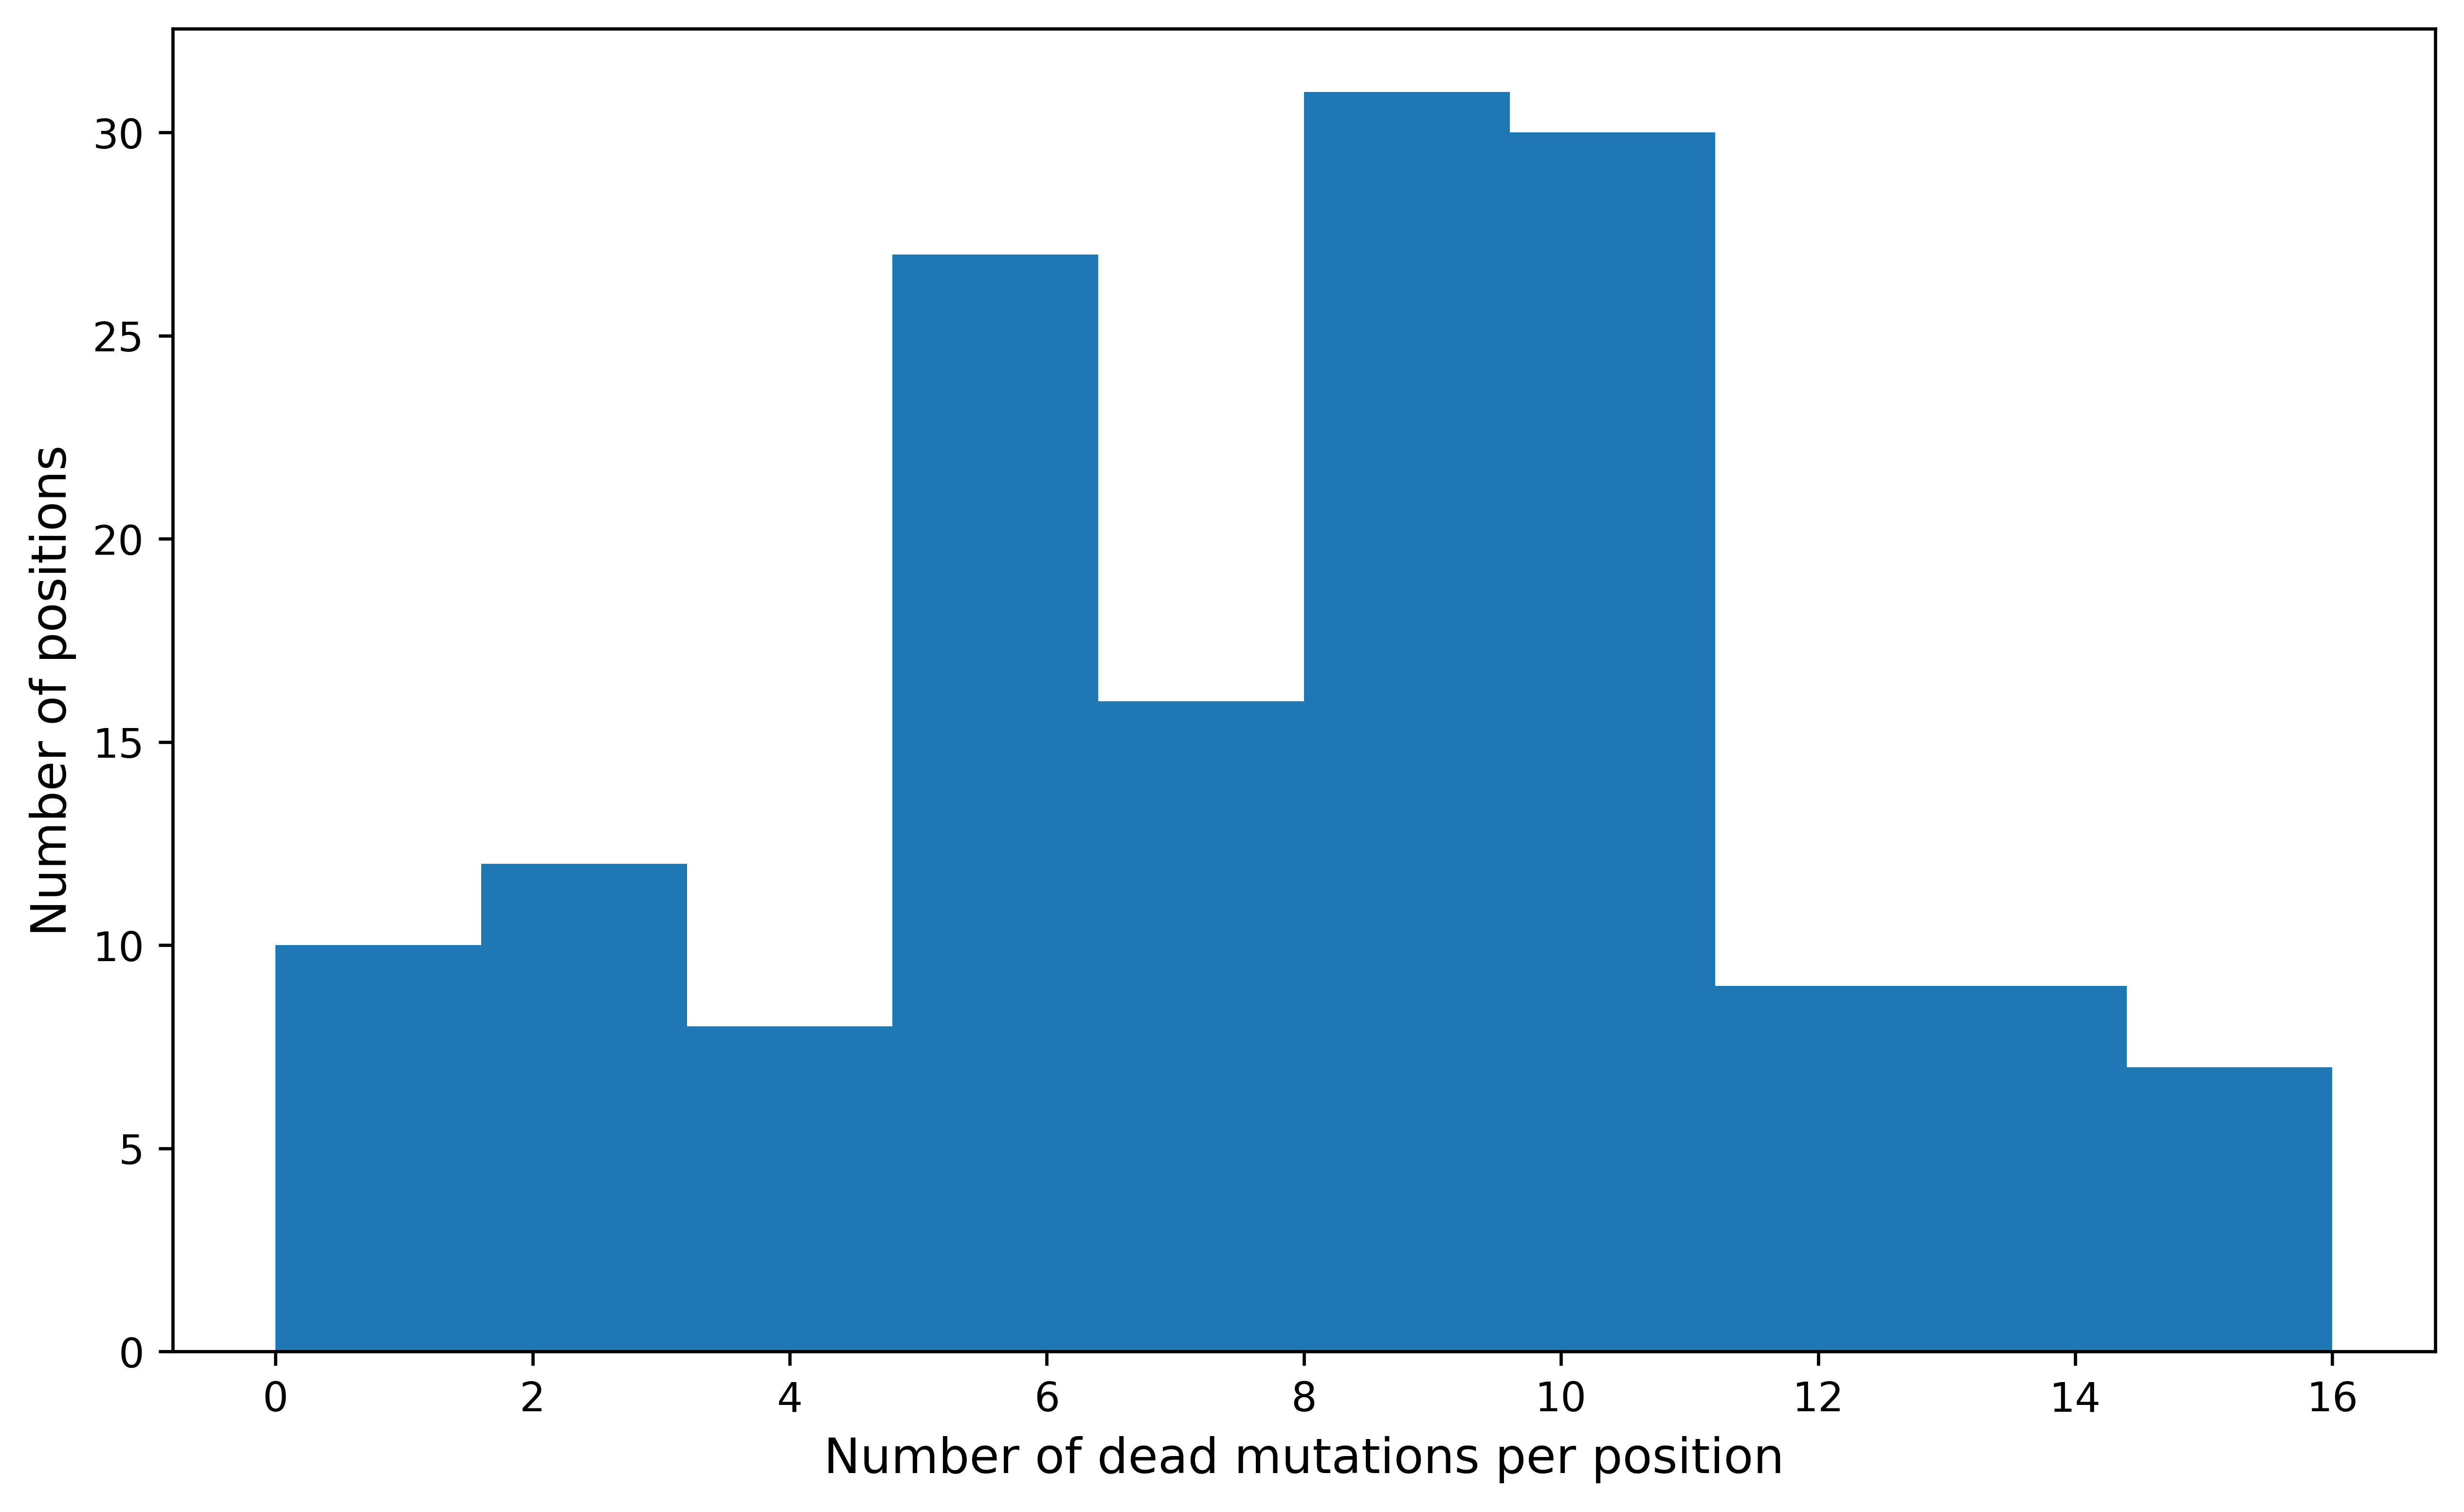

In [24]:
#examine the number of catalytically inactivating mutations per position
deadMutPos = np.zeros(n_pos)
aliveMutPos = np.zeros(n_pos)
deadStop = np.zeros(n_pos)
for p in range(n_pos):
    #here we use n_aa -1, because we exclude the stop codon.
    for aa in range(n_aa-1):
        if ((avg_gr_dark[p,aa] <= cut_darkSlowGR) or (avg_gr_lit[p,aa] <= cut_litSlowGR)) and \
            ((avg_gr_dark[p,aa] != -1000) and (avg_gr_lit[p,aa] != -1000)):
            deadMutPos[p] +=1 
        elif ((avg_gr_dark[p,aa] != -1000) and (avg_gr_lit[p,aa] != -1000)):
            aliveMutPos[p] +=1
    aa = 20
    if ((avg_gr_dark[p,aa] <= cut_darkSlowGR) or (avg_gr_lit[p,aa] <= cut_litSlowGR)):
            deadStop[p] += 1
            
print ('%i (%f) of stop codons are categorized as inactive or missing from the library' % \
       (np.sum(deadStop),np.sum(deadStop)/len(deadStop)))

print ('***** Total number of catalytically inactive mutations (excluding stop codons): %i' %\
       np.sum(deadMutPos))
print('On average, there are %f dead mutations per position' %np.mean(deadMutPos))
print('with standard deviation: %f' % np.std(deadMutPos) )

plt.hist(deadMutPos)
plt.xlabel('Number of dead mutations per position', fontsize=12)
plt.ylabel('Number of positions', fontsize=12)

In [25]:
#which positions are enriched for catalytically inactivating mutations? 
deadMutPos_pvals = []
deadMutPos_enrich = np.zeros(n_pos)
for p in range(n_pos):
    observed = np.array([[deadMutPos[p], aliveMutPos[p]],[np.sum(deadMutPos)-deadMutPos[p], \
                                                          np.sum(aliveMutPos)-aliveMutPos[p]]])
    chi2, pval, dof, expected =stats.chi2_contingency(observed)
    if (deadMutPos[p] > expected[0,0]):
        deadMutPos_enrich[p] = 1
    deadMutPos_pvals.append(pval)
    if (pval < 0.05):
        print('***Position: %i' % (p+1))
        print(observed)
        print('chi^2 value is: %s' % chi2)
        print('p value is: %s' % pval)
        print(expected)
        print('---------------')
    
print('Overall, %i out of %i measured mutations (%1.2f)are classified as very slow growing.' % (np.sum(deadMutPos),np.sum(deadMutPos)+np.sum(aliveMutPos), np.sum(deadMutPos)/(np.sum(deadMutPos)+np.sum(aliveMutPos))))
print('*** Positions with significant enrichment for slow growth mutations: ')
deadMutPosSigEnrich = [str(p+1) for p in range(n_pos) if (deadMutPos_pvals[p]< 0.05 and deadMutPos_enrich[p] == 1)]
print('+'.join(deadMutPosSigEnrich))

***Position: 1
[[   3.   16.]
 [1244. 1532.]]
chi^2 value is: 5.311984765531249
p value is: 0.021179214835029762
[[   8.47692308   10.52307692]
 [1238.52307692 1537.47692308]]
---------------
***Position: 2
[[  13.    5.]
 [1234. 1543.]]
chi^2 value is: 4.51986228078728
p value is: 0.03350352819224822
[[   8.03076923    9.96923077]
 [1238.96923077 1538.03076923]]
---------------
***Position: 6
[[  16.    3.]
 [1231. 1545.]]
chi^2 value is: 10.577665145802204
p value is: 0.001144621327333296
[[   8.47692308   10.52307692]
 [1238.52307692 1537.47692308]]
---------------
***Position: 13
[[  13.    5.]
 [1234. 1543.]]
chi^2 value is: 4.51986228078728
p value is: 0.03350352819224822
[[   8.03076923    9.96923077]
 [1238.96923077 1538.03076923]]
---------------
***Position: 16
[[   3.   16.]
 [1244. 1532.]]
chi^2 value is: 5.311984765531249
p value is: 0.021179214835029762
[[   8.47692308   10.52307692]
 [1238.52307692 1537.47692308]]
---------------
***Position: 21
[[  15.    3.]
 [1232. 15

Perhaps unsuprisingly, we find that a number of positions near the active site, and which are known to be important to catalysis, are enriched for mutations leading to slow growth. We presume these mutations are catalytically inactivating. 

So what is the association between these catalytically inactivating mutations and the sector?

In [26]:

number = 0
for sector_compare in secdef:
    sec_and_inactive, sec_and_active = 0,0
    nonsec_and_inactive, nonsec_and_active = 0,0
    for p in range(n_pos):
         #here we use n_aa -1, because we exclude the stop codon.
        for aa in range(n_aa - 1):
            #mutation is inactivating
            if (allostery[p,aa] == -999):
                if (p+1) in sector_compare:
                    sec_and_inactive += 1
                else:
                    nonsec_and_inactive += 1
            #mutation is not inactivating, and is present
            elif (allostery[p,aa] != -1000):
                if (p+1) in sector_compare:
                    sec_and_active += 1
                else:
                    nonsec_and_active += 1
                    
    sector_p_value_cutoff = secp_cutoffs[number]
    observed = np.array([[sec_and_inactive, nonsec_and_inactive],[sec_and_active, nonsec_and_active]])
    chi2, pval, dof, expected =stats.chi2_contingency(observed)
    print('--------------- sector cuttof is: %s ' % sector_p_value_cutoff)
    print(observed)
    print('chi^2 value is: %s' % chi2)
    print('p value is: %s' % pval)
    print(expected)           

    #printing out some sanity checks to make sure we are accounting for all mutations properly:
    print('**** Some sanity/consistency checks:')
    print('Number of inactivating mutations: %i' % (sec_and_inactive + nonsec_and_inactive))
    print('(this should match to %i)' % np.sum(allostery[:,0:20] == -999))
    print('Total number of measurements: %i ' % (sec_and_inactive + nonsec_and_inactive + \
                                               sec_and_active + nonsec_and_active))
    print('(this should match to %i)' % ((159*20) - np.sum(allostery[:,0:20] == -1000)))
    number = number + 1 

--------------- sector cuttof is: 0.005 
[[ 223 1024]
 [ 173 1375]]
chi^2 value is: 25.00063781617915
p value is: 5.731135244530324e-07
[[ 176.67692308 1070.32307692]
 [ 219.32307692 1328.67692308]]
**** Some sanity/consistency checks:
Number of inactivating mutations: 1247
(this should match to 1247)
Total number of measurements: 2795 
(this should match to 2795)
--------------- sector cuttof is: 0.008 
[[ 332  915]
 [ 295 1253]]
chi^2 value is: 22.294388258818756
p value is: 2.338891172618984e-06
[[ 279.73846154  967.26153846]
 [ 347.26153846 1200.73846154]]
**** Some sanity/consistency checks:
Number of inactivating mutations: 1247
(this should match to 1247)
Total number of measurements: 2795 
(this should match to 2795)
--------------- sector cuttof is: 0.01 
[[ 373  874]
 [ 325 1223]]
chi^2 value is: 28.834860931595134
p value is: 7.881957819956944e-08
[[ 311.41538462  935.58461538]
 [ 386.58461538 1161.41538462]]
**** Some sanity/consistency checks:
Number of inactivating mutati

Catalytically inactivating mutations are enriched in the sector. <br>

We also check the relationship to the most evolutionarily conserved positions. Given that the sector is in part defined using evolutionary conservation, we expect that the sector and evolutionary conservation give non-unique (partially overlapping) models for the most functionally critical positions in the protein.

In [27]:
#what is the association between catalytically inactive mutations and evolutionarily conserved positions?
number = 0
for consPos_compare in consposdef:
    cons_and_inactive, cons_and_active = 0,0
    noncons_and_inactive, noncons_and_active = 0,0
    for p in range(n_pos):
         #here we use n_aa -1, because we exclude the stop codon.
        for aa in range(n_aa - 1):
            #mutation is inactivating
            if (allostery[p,aa] == -999):
                if (p+1) in consPos_compare:
                    cons_and_inactive += 1
                else:
                    noncons_and_inactive += 1
            #mutation is not inactivating, and is present
            elif (allostery[p,aa] != -1000):
                if (p+1) in consPos_compare:
                    cons_and_active += 1
                else:
                    noncons_and_active += 1

    observed = np.array([[cons_and_inactive, noncons_and_inactive],[cons_and_active, noncons_and_active]])
    chi2, pval, dof, expected =stats.chi2_contingency(observed)
    print('--------------- conservation cuttof is: %s ' % consvals_cutoffs[number])
    print(observed)
    print('chi^2 value is: %s' % chi2)
    print('p value is: %s' % pval)
    print(expected)    
    print(consposdef[1])
    print(consposdef[2])
    number = number + 1 

--------------- conservation cuttof is: 1.89 
[[ 249  998]
 [ 143 1405]]
chi^2 value is: 65.06008008976248
p value is: 7.264898099790745e-16
[[ 174.89230769 1072.10769231]
 [ 217.10769231 1330.89230769]]
[5.0, 7.0, 14.0, 15.0, 20.0, 21.0, 22.0, 27.0, 31.0, 35.0, 40.0, 41.0, 42.0, 43.0, 44.0, 46.0, 47.0, 49.0, 54.0, 55.0, 57.0, 59.0, 61.0, 63.0, 64.0, 94.0, 95.0, 96.0, 100.0, 113.0, 115.0, 122.0, 125.0, 126.0, 133.0, 153.0]
[5.0, 7.0, 14.0, 15.0, 20.0, 21.0, 22.0, 27.0, 31.0, 35.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 49.0, 54.0, 55.0, 57.0, 59.0, 60.0, 61.0, 63.0, 64.0, 94.0, 95.0, 96.0, 99.0, 100.0, 113.0, 115.0, 121.0, 122.0, 125.0, 126.0, 133.0, 153.0]
--------------- conservation cuttof is: 1.54 
[[ 377  870]
 [ 242 1306]]
chi^2 value is: 84.53309513664827
p value is: 3.7783699703741144e-20
[[ 276.16923077  970.83076923]
 [ 342.83076923 1205.16923077]]
[5.0, 7.0, 14.0, 15.0, 20.0, 21.0, 22.0, 27.0, 31.0, 35.0, 40.0, 41.0, 42.0, 43.0, 44.0, 46.0, 47.0, 49.0, 54.0, 55.0, 5

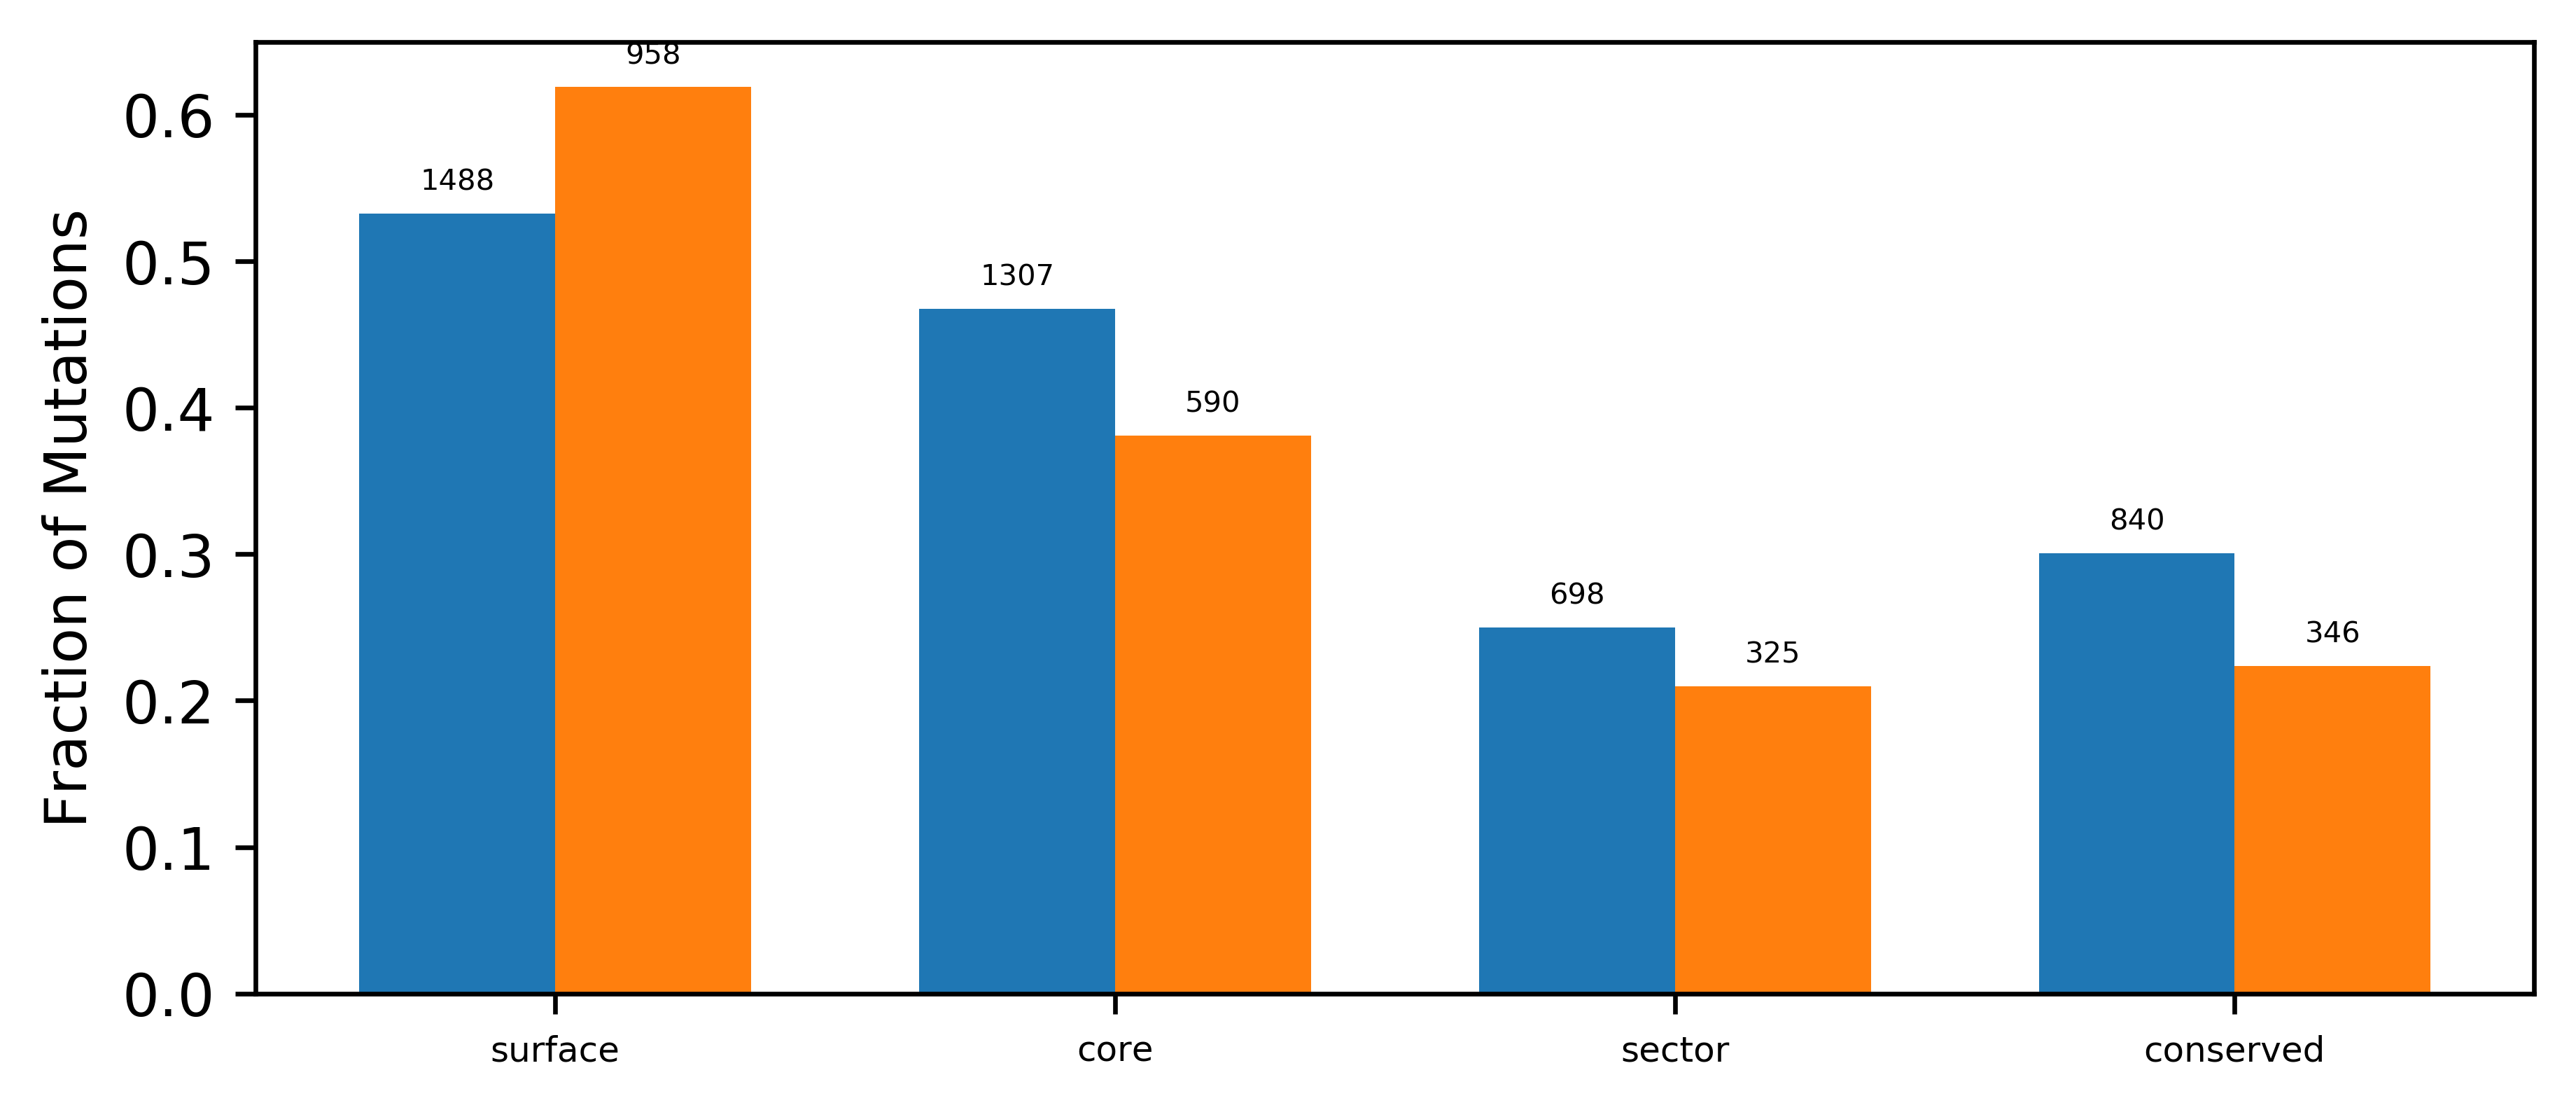

In [28]:
#for the remaining mutations, where we analyze allostery (not inactive, present in library) 
#what is the break down of surface vs core, sector vs not, conserved vs not, 
#and how does this compare to the library as a whole?
#again, here we ignore stop codons,since we wish to focus on coding mutations.

totMut = 0
totMutFilter = np.sum(allostery[:,0:20].flatten() > -999)
surface_total, surface_remain = 0,0
core_total, core_remain = 0,0
sector_total, sector_remain = 0,0
conserved_total, conserved_remain = 0,0

for p in range(n_pos):
    for aa in range(n_aa-1):
        if (avg_gr_lit[p,aa] > -1000 and avg_gr_dark[p,aa] > -1000):
            totMut += 1
            if (p+1) in surfRes:
                surface_total += 1
                if (allostery[p,aa] > -999):
                    surface_remain += 1
            else:
                core_total+= 1
                if (allostery[p,aa] > -999):
                    core_remain += 1
                    
            if (p+1) in sector:
                sector_total += 1
                if (allostery[p,aa] > -999):
                    sector_remain += 1
            if (p+1) in consPos:
                conserved_total += 1
                if (allostery[p,aa] > -999):
                    conserved_remain +=1
                
plt.rcParams['figure.figsize']= (7,3)
fig, ax = plt.subplots()
xticks = np.arange(1,5)
width = 0.35
rects1 = ax.bar(xticks-(0.5*width),[surface_total/totMut,core_total/totMut,sector_total/totMut,conserved_total/totMut],\
        width)
rects2 = ax.bar(xticks+(0.5*width),[surface_remain/totMutFilter, core_remain/totMutFilter,\
                           sector_remain/totMutFilter,conserved_remain/totMutFilter],width)
ax.set_xticks(xticks)
ax.set_xticklabels(['surface','core','sector','conserved'], fontsize=6)
plt.ylabel('Fraction of Mutations')



def autolabel(rects,labels):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for k,rect in enumerate(rects):
        height = rect.get_height()
        ax.annotate(labels[k],
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=5)


autolabel(rects1,[surface_total,core_total,sector_total,conserved_total])
autolabel(rects2,[surface_remain,core_remain,sector_remain,conserved_remain])
#plt.savefig('FigPanels/NumMut_postcut.pdf',transparent=True, format='pdf', dpi=600) 

## 4. Evaluating allostery data

First, plot the distribution of allsoteric effects. Overall, the range of allosteric effects is centered near zero (no change from DL121, which is itself allosteric), with a few positive outliers.

Mean allostery, all pos: 0.0017, not filtered for dead mutants: -0.0018


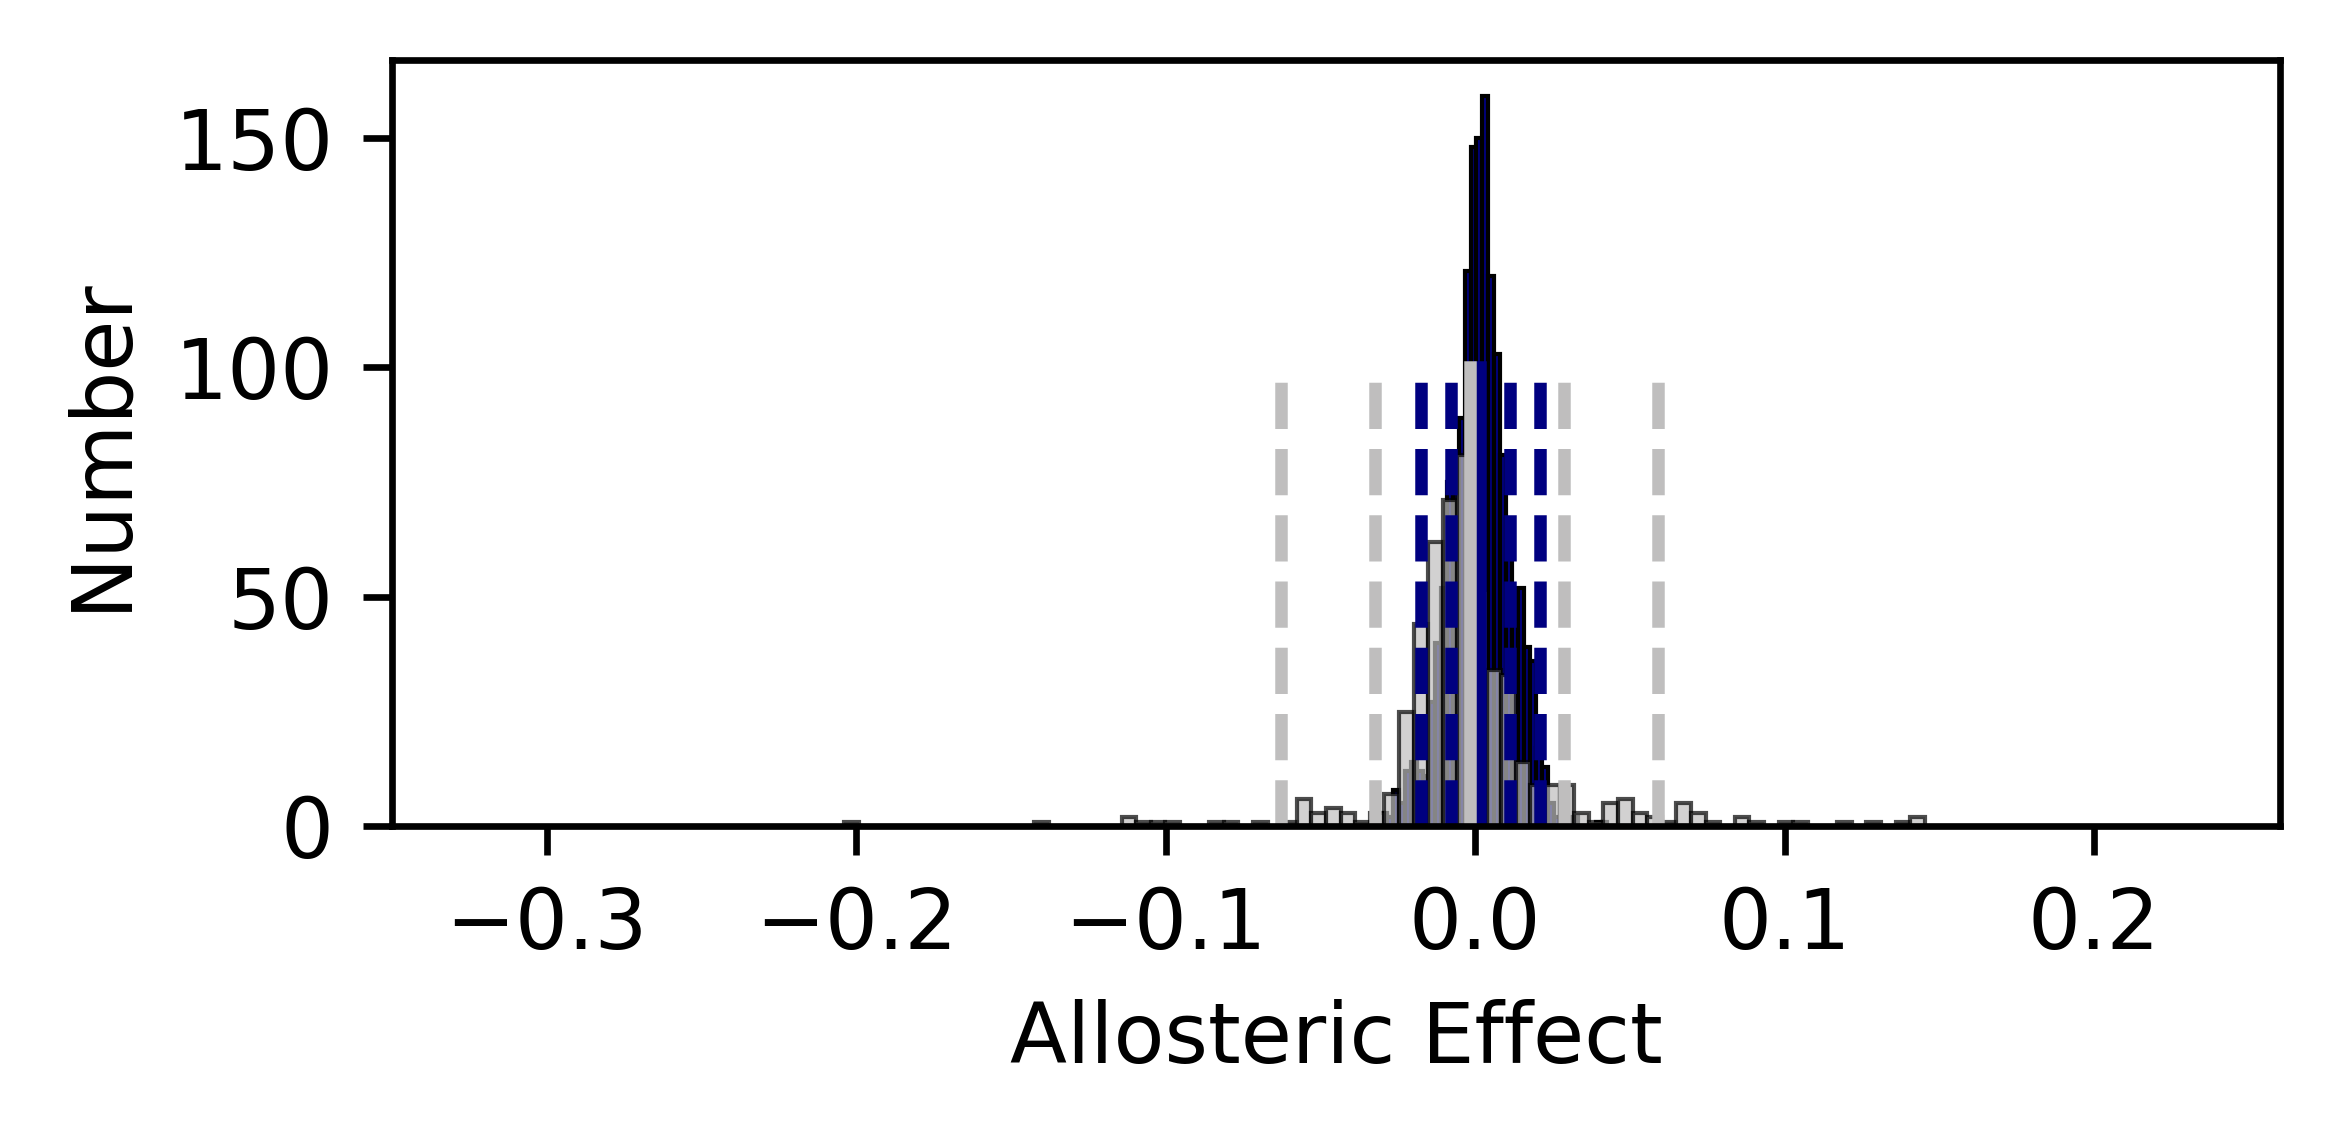

In [29]:



plt.rcParams['figure.figsize'] = (4,2)
allostery_filtered = [a for a in allostery.flatten() if a > -999]


allo_flat_all = allostery_all[:,0:-1].flatten()
avg_gr_dark_flat = avg_gr_dark[:,0:-1].flatten()

keep_ix = [i for i,a in enumerate(allo_flat_all) if (a > -999 and avg_gr_dark_flat[i] < cut_darkSlowGR)]
allostery_all_filtered = allo_flat_all[keep_ix]

"""keep_ix = [i for i,a in enumerate(allo_flat) if (a > -999 and avg_gr_dark_flat[i] > cut_darkSlowGR)]
y = allo_flat[keep_ix]
x = avg_gr_dark[:,0:-1].flatten()[keep_ix]
y_err = allostery_sd[:,0:-1].flatten()[keep_ix]
x_err = sd_gr_dark[:,0:-1].flatten()[keep_ix]"""

#keep_ix = [i for i,a in enumerate(allo_flat_all) if (a > -999 and avg_gr_dark_flat[i] < cut_darkSlowGR)]

#allostery_sector = allostery[np.ix_([k-1 for k in sector]),:]
#allostery_sector_filtered = [gr for gr in allostery_sector.flatten() if gr > -999]


#plot lines indicating zeros and mean/sd of allo effect
#plt.plot([0,0],[-0.35,0.35],'k-')
mean_allo = np.mean(allostery_filtered)
sd_allo = np.std(allostery_filtered)
plt.plot([mean_allo,mean_allo],[0,100],'c-',color='navy')
plt.plot([mean_allo+sd_allo,mean_allo+sd_allo],[0,100],'c--',color='navy')
plt.plot([mean_allo-sd_allo,mean_allo-sd_allo],[0,100],'c--',color='navy')
plt.plot([mean_allo+sd_allo+sd_allo,mean_allo+sd_allo+sd_allo],[0,100],'c--',color='navy')
plt.plot([mean_allo-sd_allo-sd_allo,mean_allo-sd_allo-sd_allo],[0,100],'c--',color='navy')


mean_allo_all = np.mean(allostery_all_filtered)
sd_allo_all = np.std(allostery_all_filtered)
plt.plot([mean_allo_all,mean_allo_all],[0,100],'c-', color='#bfbebe')
plt.plot([mean_allo_all+sd_allo_all,mean_allo_all+sd_allo_all],[0,100],'c--', color='#bfbebe')
plt.plot([mean_allo_all-sd_allo_all,mean_allo_all-sd_allo_all],[0,100],'c--', color='#bfbebe')
plt.plot([mean_allo_all+sd_allo_all+sd_allo_all,mean_allo_all+sd_allo_all+sd_allo_all],[0,100],'c--', color='#bfbebe')
plt.plot([mean_allo_all-sd_allo_all-sd_allo_all,mean_allo_all-sd_allo_all-sd_allo_all],[0,100],'c--', color='#bfbebe')



#plt.hist(allostery_all_filtered,bins='auto',edgecolor='k', color='#bfbebe',linewidth=0.5)
plt.hist(allostery_filtered,bins='auto',color='navy',edgecolor='k',linewidth=0.5)
plt.hist(allostery_all_filtered,bins='auto',edgecolor='k', color='#bfbebe',alpha=0.7,linewidth=0.5)
print('Mean allostery, all pos: %.4f, not filtered for dead mutants: %.4f'%\
      (np.mean(allostery_filtered),np.mean(allostery_all_filtered)))
plt.xlim([-0.35,0.26])
plt.xlabel('Allosteric Effect',fontsize=10); plt.ylabel('Number',fontsize=10);
plt.tight_layout()
#plt.savefig('FigPanels/Allosteric_effect_histogram.pdf', format='pdf', dpi=300, pad_inches=1)

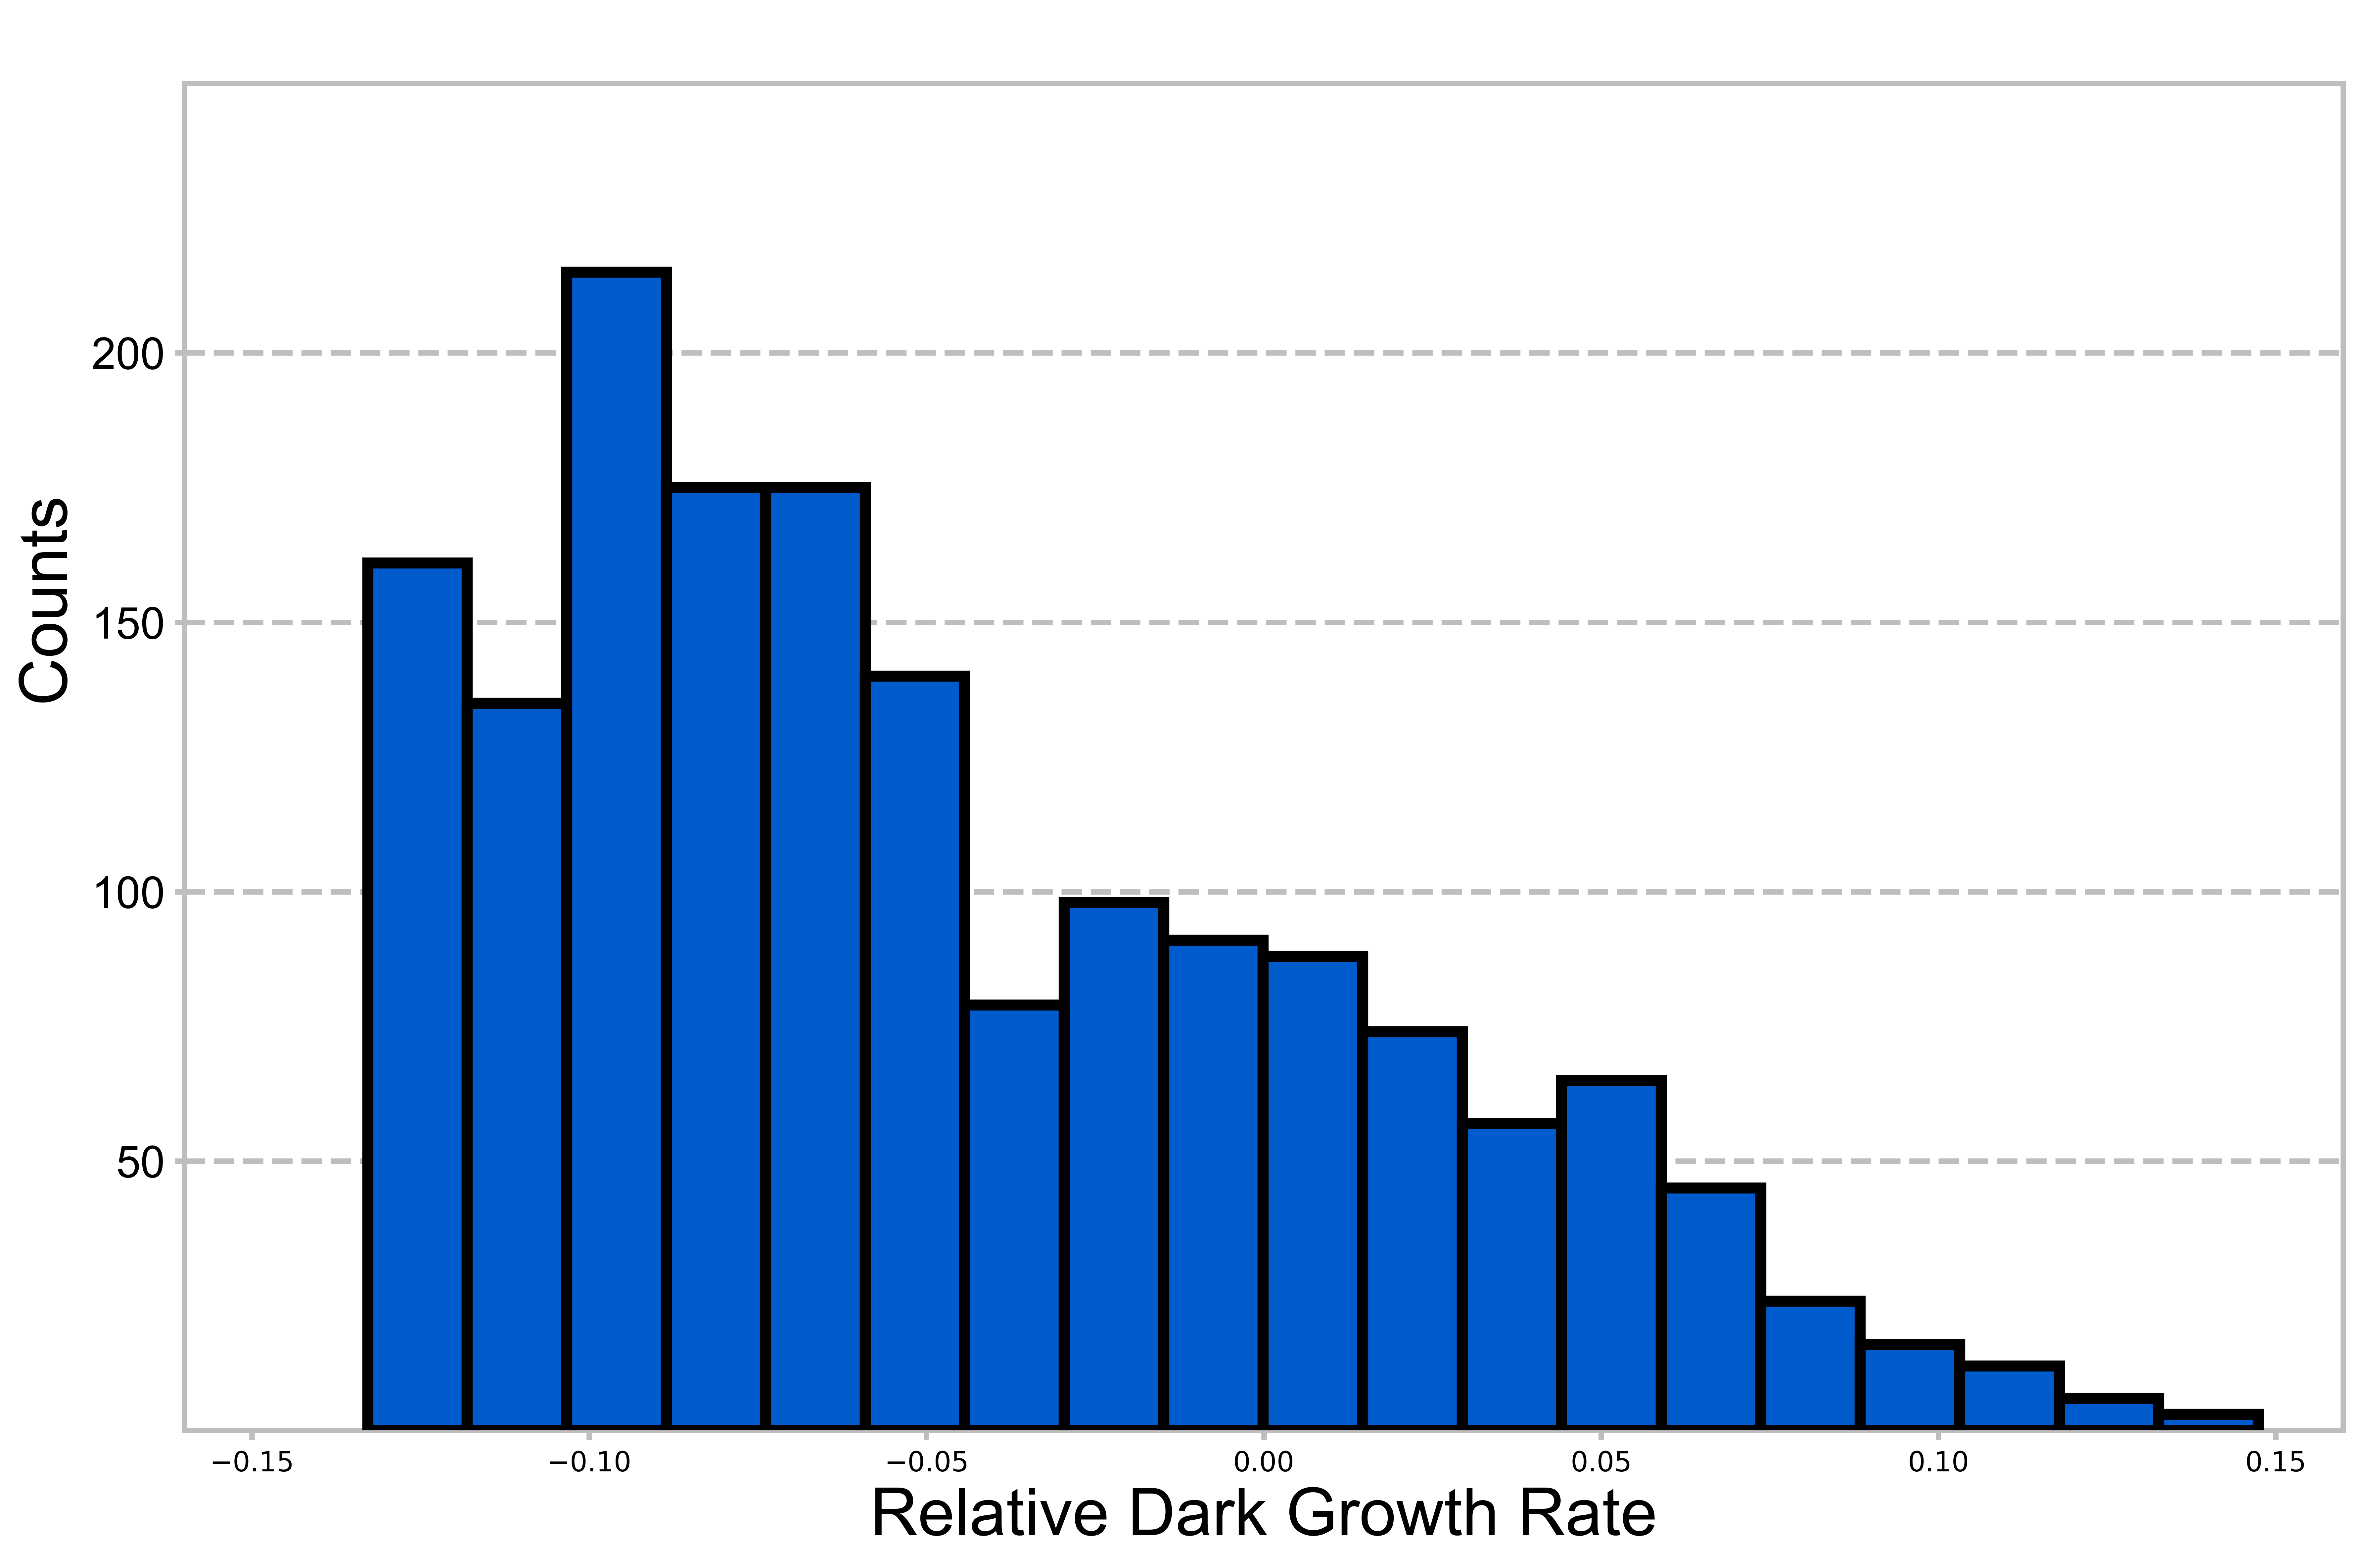

In [30]:
#ALL This will be a histogram of growth rate with filtering of samples. 
# average_relative_growth_rate_dark or growth_rate_array
#data
#title
slxTitle = ' '

plt.rcParams['figure.figsize'] = (12,8)
f, (ax2) = plt.subplots(1)

#ax2 = plt.gca()
ax2.spines['bottom'].set_color('#BEBEBE')
ax2.spines['bottom'].set_linewidth(2)
ax2.spines['right'].set_color('#BEBEBE')
ax2.spines['right'].set_linewidth(2)
ax2.spines['top'].set_color('#BEBEBE')
ax2.spines['top'].set_linewidth(2)
ax2.spines['left'].set_color('#BEBEBE')
ax2.spines['left'].set_linewidth(2)
ax2.set_axisbelow(True)
ax2.xaxis.set_tick_params(width=2, color = '#BEBEBE')
ax2.yaxis.set_tick_params(width=2, color = '#BEBEBE')



avg_gr_dark_filtered = [gr for gr in avg_gr_dark.flatten() if gr >= -0.1329]
#avg_gr_dark_filtered_lower = [gr for gr in avg_gr_dark.flatten() if gr > -1000 and gr < -0.1329]
ax2.xaxis.tick_bottom()


ax2.tick_params(axis='both', which='minor',size=0)

#ax2.grid([-0.3,-0.2,-0.1,0,0.1,0.2], which='major', axis='x', ls='--',lw=2, alpha=1, color = '#BEBEBE', markevery=[-0.3,-0.2,-0.1,0,0.1,0.2])
ax2.grid([50,100,150,200,250], which='major', axis='y', ls='--',lw=2, alpha=1, markevery=[50,100,150,200,250], color = '#BEBEBE')

ax2.set_ylim(0, 250)
plt.xlim([-0.16,0.16])

#xticks
#ax2.set_xticks([-0.3,-0.2,-0.1,0,0.1,0.2])
#ax2.set_xticklabels(['-0.3','-0.2','-0.1','0','0.1','0.2','0.3'], fontsize=16, fontname="Arial")
#yticks
ax2.set_yticks([50,100,150,200])
ax2.set_yticklabels([50,100,150,200], fontsize=16, fontname="Arial")

plt.xlabel('Relative Dark Growth Rate', fontsize=24, fontname="Arial")
plt.ylabel('                 Counts', fontsize=24, fontname="Arial")
ax2.set_title(slxTitle, fontsize=24, fontname="Arial")


#growth_rate_array.sort()
#hmean = np.mean(average_relative_growth_rate_dark)
#hstd = np.std(average_relative_growth_rate_dark)
#pdf = stats.norm.pdf(average_relative_growth_rate_dark, hmean, hstd)
#plt.plot(growth_rate_array, pdf)


ax2.hist(avg_gr_dark_filtered,bins = 'auto', color = '#005ccc',edgecolor='#000000',lw=4, alpha=1,zorder=5)
#ax2.hist(avg_gr_dark_filtered_lower,bins = 'auto', color = 'r',edgecolor='#000000',lw=4, alpha=1,zorder=5)
#ax.plot([np.mean(average_relative_growth_rate_dark),np.mean(average_relative_growth_rate_dark)],[0,500],'--', color = '#ff0000',linewidth = 3, zorder=10) #mean value line


plt.tight_layout()
#plt.show
#integral_hist = np.sum(hist_out[0])
#plt.savefig('FigPanels/Dark_growth_rate_histogram_truncated.pdf', format='pdf', dpi=300, pad_inches=1) 

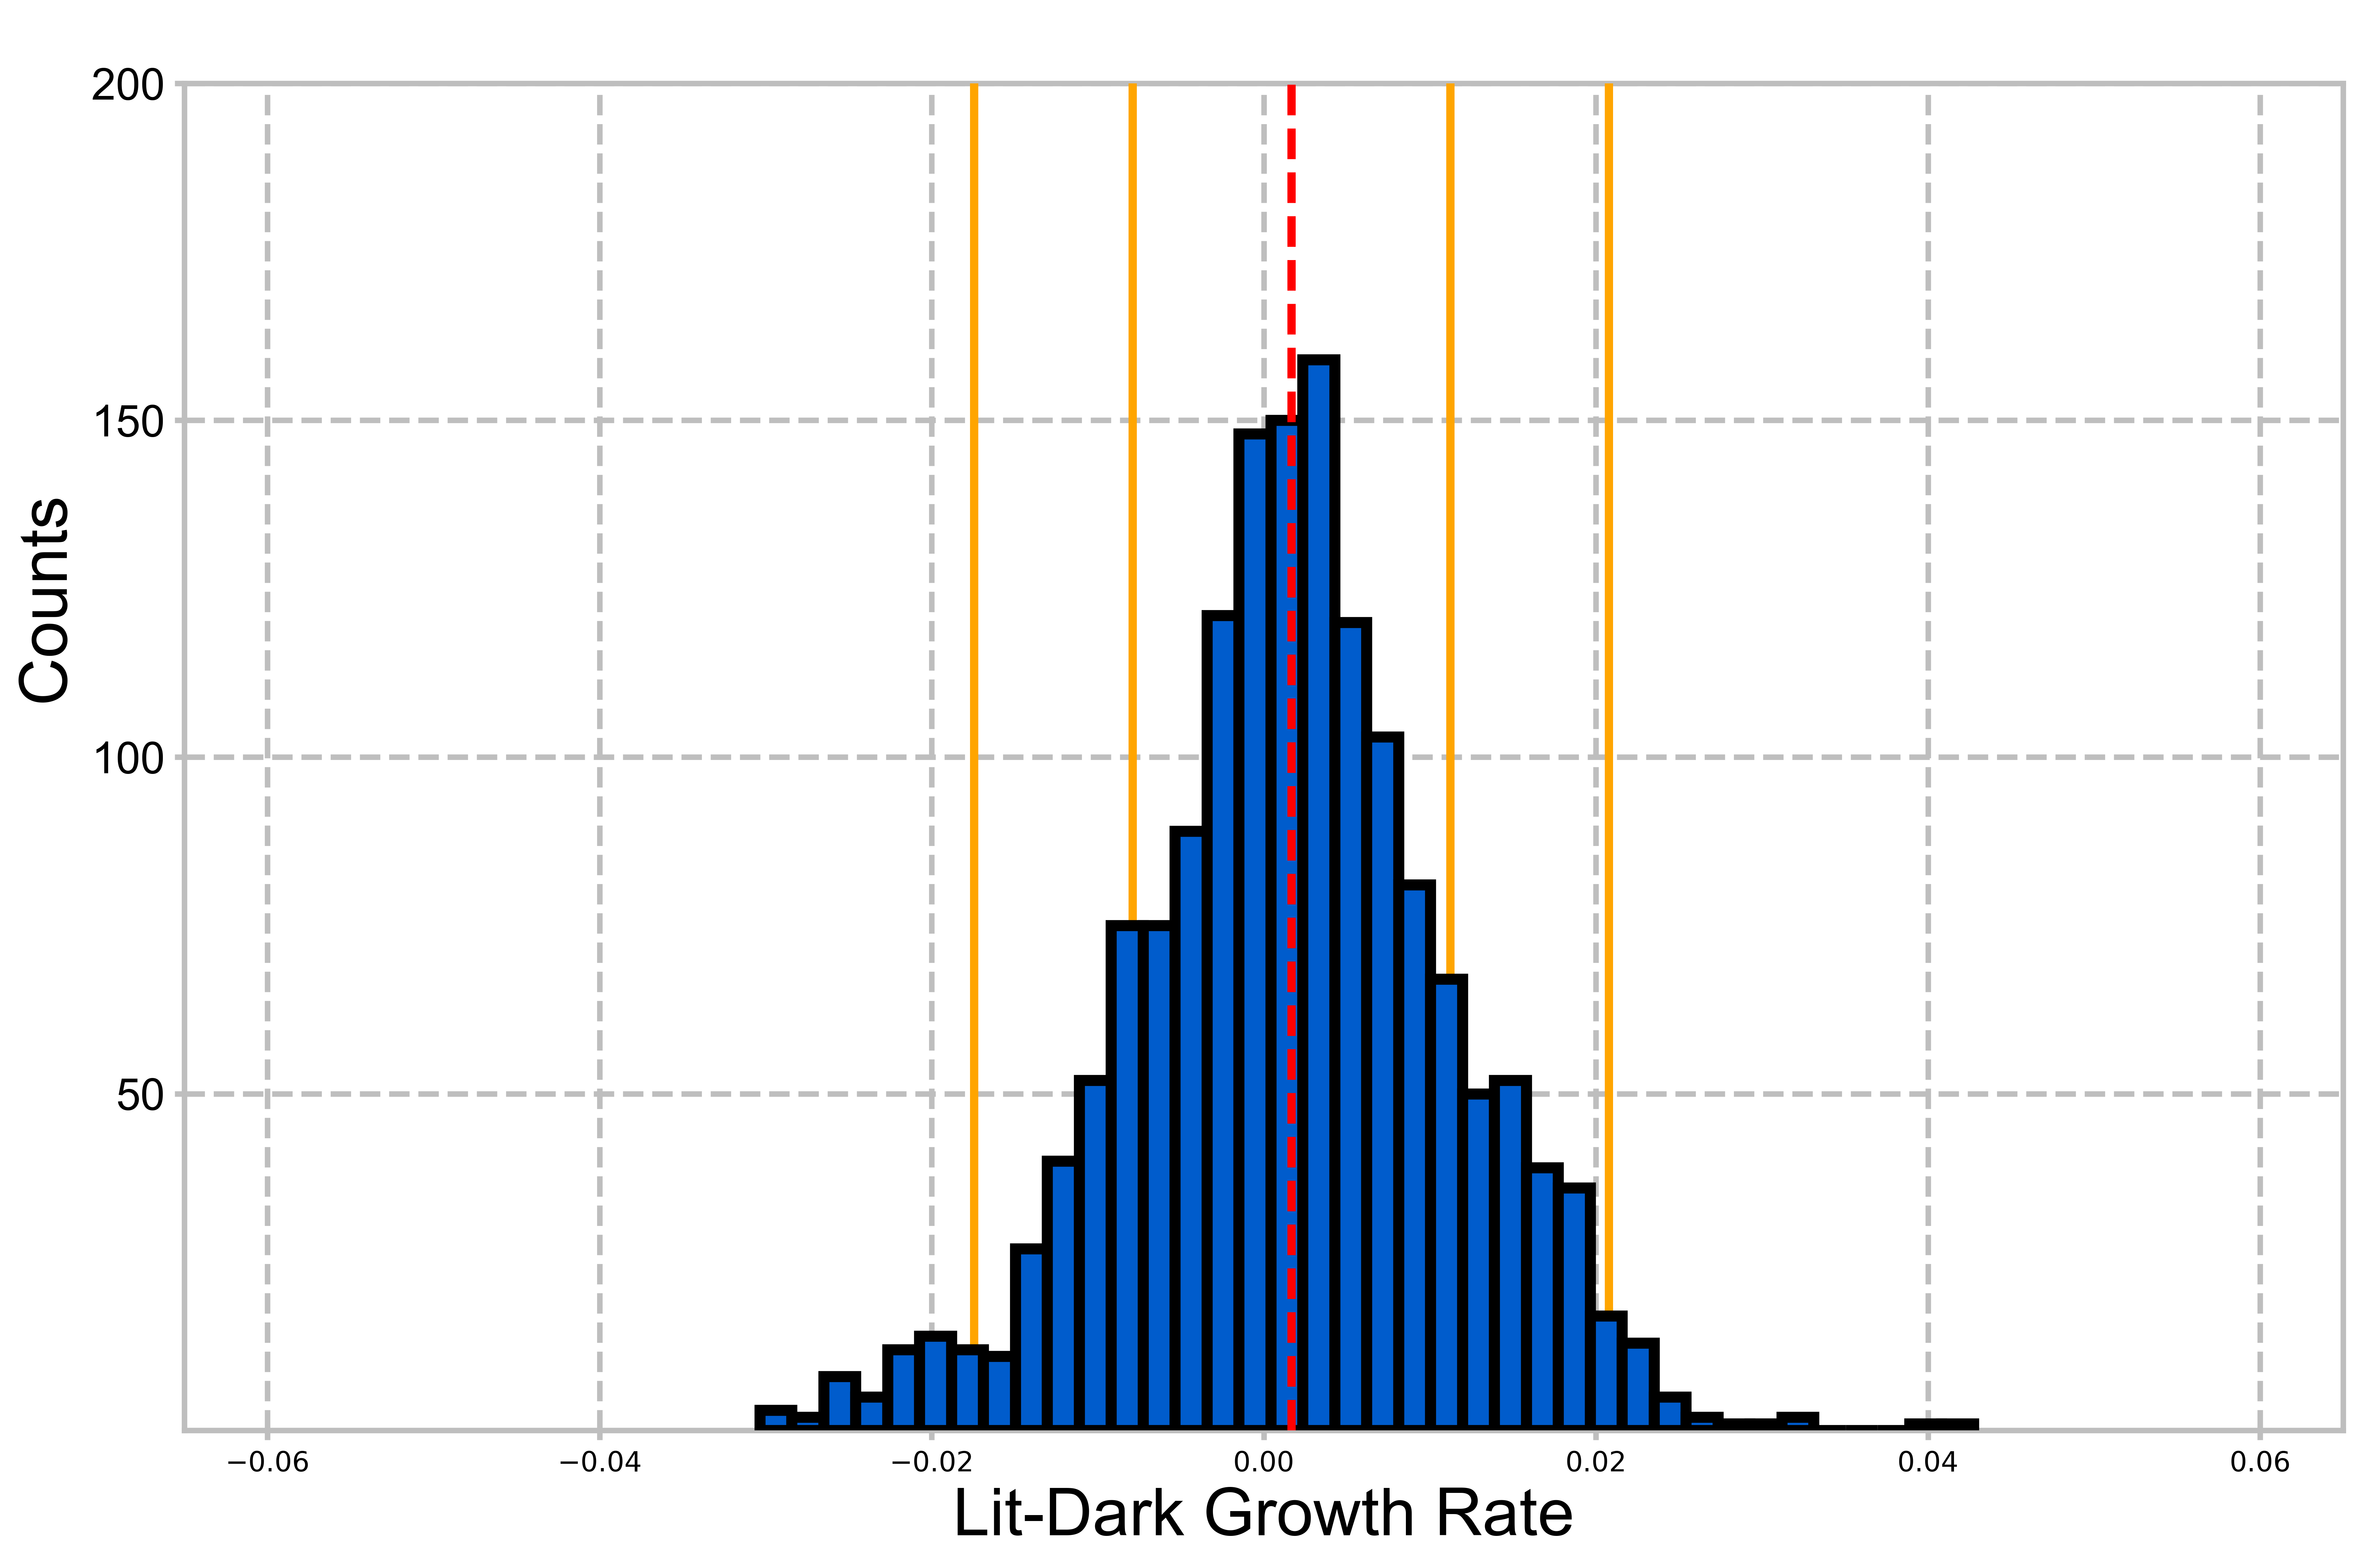

In [31]:
#Lit-dark growth rate histogram
#data
#title
slxTitle = ' '
allostery_filtered = [a for a in allostery.flatten() if a > -999]
plt.rcParams['figure.figsize'] = (12,8)
f, (ax2) = plt.subplots(1)

#ax2 = plt.gca()
ax2.spines['bottom'].set_color('#BEBEBE')
ax2.spines['bottom'].set_linewidth(2)
ax2.spines['right'].set_color('#BEBEBE')
ax2.spines['right'].set_linewidth(2)
ax2.spines['top'].set_color('#BEBEBE')
ax2.spines['top'].set_linewidth(2)
ax2.spines['left'].set_color('#BEBEBE')
ax2.spines['left'].set_linewidth(2)
ax2.set_axisbelow(True)
ax2.xaxis.set_tick_params(width=2, color = '#BEBEBE')
ax2.yaxis.set_tick_params(width=2, color = '#BEBEBE')

#ax2.spines['top'].set_visible(False)

ax2.xaxis.tick_bottom()


ax2.tick_params(axis='both', which='minor',size=0)

ax2.grid([-0.04,-0.02,0,0.02,0.04], which='major', axis='x', ls='--',lw=2, alpha=1, color = '#BEBEBE', markevery=[-0.04,-0.02,0,0.02,0.04])
ax2.grid([50,100,150,200], which='major', axis='y', ls='--',lw=2, alpha=1, markevery=[50,100,150,200], color = '#BEBEBE')

ax2.set_ylim(0, 200)
ax2.set_xlim(-0.065,0.065)

#xticks
#ax2.set_xticks([-0.04,-0.02,0,0.02,0.04,])
#ax2.set_xticklabels(['-0.04','-0.02','0','0.02','0.04'], fontsize=16, fontname="Arial")
#yticks
ax2.set_yticks([50,100,150,200])
ax2.set_yticklabels([50,100,150,200], fontsize=16, fontname="Arial")

plt.xlabel('Lit-Dark Growth Rate', fontsize=24, fontname="Arial")
plt.ylabel('                 Counts', fontsize=24, fontname="Arial")
ax2.set_title(slxTitle, fontsize=24, fontname="Arial")

#x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
mu = mean_allo
sigma = sd_allo
#pdf = stats.norm.pdf(allostery_filtered, mu, hstd)
#plt.plot(growth_rate_array, pdf)


#ax2.plot(x,mlab.normpdf(x, mu, sigma))
#ax2.plot(growth_rate_array, pdf)
ax2.hist(allostery_filtered,bins = 'auto', color = '#005ccc',edgecolor='#000000',lw=4, alpha=1,zorder=5)
ax2.plot([mu,mu],[0,500],'--', color = '#ff0000',linewidth = 3, zorder=10) #mean value line
ax2.plot([mu - sigma,mu - sigma],[0,500], color = 'orange',linewidth = 3, zorder=4) #-1 standard deviation
ax2.plot([mu + sigma,mu + sigma],[0,500], color = 'orange',linewidth = 3, zorder=4) #+1 standard deviation
ax2.plot([mu - sigma - sigma,mu - sigma - sigma],[0,500], color = 'orange',linewidth = 3, zorder=4) #-2 standard deviation
ax2.plot([mu + sigma + sigma,mu + sigma + sigma],[0,500], color = 'orange',linewidth = 3, zorder=4) #+2 standard deviation
ax2.plot([mu - sigma - sigma,mu - sigma - sigma],[0,500],'--', color = 'orange',linewidth = 3) #-2 standard deviation
ax2.plot([mu + sigma + sigma,mu + sigma + sigma],[0,500],'--', color = 'orange',linewidth = 3) #+2 standard deviation
#ax2.plot(allostery_filtered, pdf)

#plt.ylim(0,500)
#plt.legend(fontsize=16)
plt.tight_layout()
#plt.show
#integral_hist = np.sum(hist_out[0])
#plt.savefig('FigPanels/lit-dark_histogram.pdf', format='pdf', dpi=300, pad_inches=1) 

**Heatmap of allosteric effects**

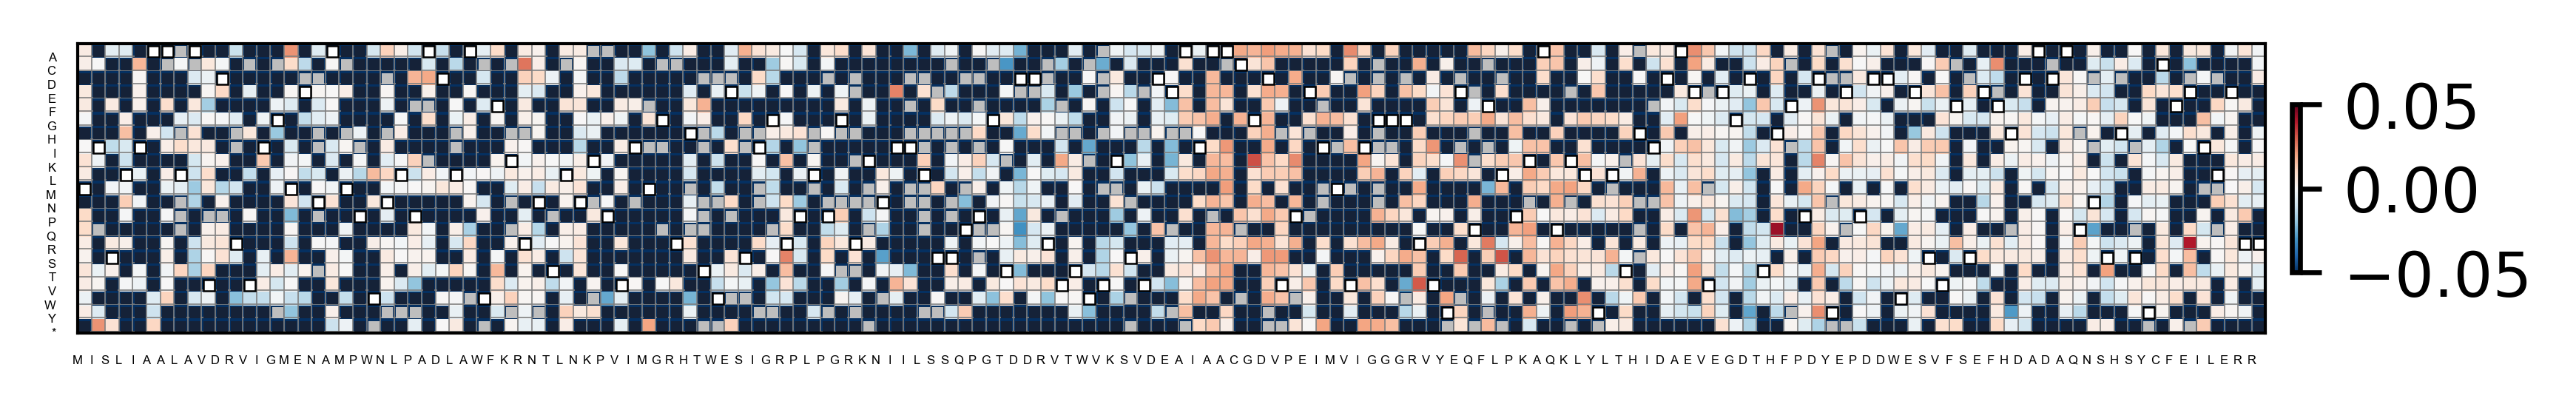

In [32]:
plt.rcParams['figure.figsize'] = (7.5714,1)
plt.rcParams["figure.dpi"] = 600

f, (ax) = plt.subplots(1)

for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(0.5)
ax.tick_params(axis='both', which='major',length=0, width=0)

plt.imshow(allostery.T, cmap='RdBu_r', interpolation='none',vmin=-0.05,vmax=0.05,aspect='equal')
plt.colorbar(shrink = 0.5, orientation = 'vertical', pad = 0.01)
dim = allostery.T.shape
yticks=np.arange(dim[0]); xticks = np.arange(dim[1])
ylabel = aas; xlabel= dhfr_wt
plt.xticks(xticks-0.5,xlabel, **font)
plt.yticks(yticks+0.4,ylabel, **font)

for p in range(n_pos):
    for a in range(n_aa):
        #color points without data dark grey, indicate WT residues in white
        if allostery.T[a,p] == -1000:
            if dhfr_wt[p] ==aas[a]:
                #plt.plot(p-0.1,a-0.2,'ws', markersize=7)
                plt.plot(p,a,'ws',markeredgecolor='#000000', markersize=1.8,mew=0.3)
            else:
                #plt.plot(p-0.1,a-0.2,'s', markerfacecolor='#808080', markersize=7)
                plt.plot(p,a,'s', markerfacecolor='#BEBEBE', markeredgecolor='#808080', markersize=1.8,mew=0)
        #color slow growing mutants in navy
        if allostery.T[a,p] == -999:
                #plt.plot(p-0.1,a-0.2,'s', markerfacecolor='#bfbfbf', markersize=7) 
                plt.plot(p,a,'s',markerfacecolor='#152238', markersize=1.8,mew=0)
                
#plt.grid(color = '#BEBEBE',linestyle = '-',linewidth = 2)
plt.grid(which='major',axis='both',color = '#808080',linestyle = '-',linewidth = 0.2)
#plt.savefig('FigPanels/allostery_heatmap.pdf', format='pdf')

**Multiple hypothesis testing - ascertaining which mutations have high confidence allosteric effects**

Here we consider two cutoffs for significant allostery, a standard cutoff of p=0.05, and a more stringent cutoff that is adjusted to consider multiple hypothesis testing. We use sequential goodness of fit (SGoF, Carvajal-Rodriguez et al, BMC Bioinformatics v.10, p. 209) to generate this adjusted p-value. 

In [33]:
# Performs binomial sequential goodness-of-fit (SGoF), a multiple hypothesis correction procedure for large numbers of 
# hypothesis tests. This function filters p-values that fail to meet a significance threshold or are likely to be
# significant only by chance.
# Input -- pvals: the 2D array of p-values calculated for the allosteric effect of each mutation
#          allostery: the 2D array of allosteric effects
#          alpha: the significance threshold        
# Output -- pval_SGOF: the significance threshold after adjustment with SGOF

def binomial_SGoF(pvals,allo,alpha=0.05):
    pvals_list = []
    for p in range(len(pvals)):
        for a in range(len(pvals[0])):
            if allo[p,a] > -999:
                pvals_list.append(pvals[p,a])
    pvals_list.sort()
    pvals_list = np.array(pvals_list)
    
    total_tests = len(pvals_list) # Total tests executed
    sig_tests = sum(pvals_list <= alpha) # Total significant tests, as determined by alpha

    print('Tests: %i' % total_tests)
    print('Significant at a cutoff of alpha=%1.3f: %f' % (alpha,sig_tests))
    
    if total_tests > sig_tests:
        b_sig = 0 # Current number of rejected null hypotheses
        R = sig_tests # Current number of remaining tests to re-check
        
        # Probability that R sig tests could arise from random chance
        p = stats.binom_test(R, n=total_tests, p=alpha, alternative='greater') 
        while p < alpha: # Below our confidence threshold
            b_sig += 1 # Fully reject a null
            R -= 1 # Update remaining tests to re-check
            p = stats.binom_test(R, total_tests, p=alpha, alternative='greater')
        pval_SGoF = pvals_list[b_sig]
        print ('Number of sig measurements by SGOF is: %i' % b_sig)
        print('SGOF corrected pval is: %f' % pval_SGoF)
        return pval_SGoF
    else:
        print('Cannot use SGoF to correct for significance.')
        b_sig = np.nan
        return 0
    
#call the SGoF procedure, get the adjusted pvalue    
pval_SGoF = binomial_SGoF(allostery_pvals[:,0:-1],allostery[:,0:-1], 0.05)

Tests: 1548
Significant at a cutoff of alpha=0.050: 161.000000
Number of sig measurements by SGOF is: 69
SGOF corrected pval is: 0.016187


#### Create volcano plot of allosteric effects, and record mutants with signficant allosteric effects

Using color to indicate the p-value cutoffs, and labeling mutations selected for experimental characterization

Largest allostery enhancing mutations: 
G86K+R98V+H124Q+E154R
86+98+124+154
Largest allostery disrupting mutations: 




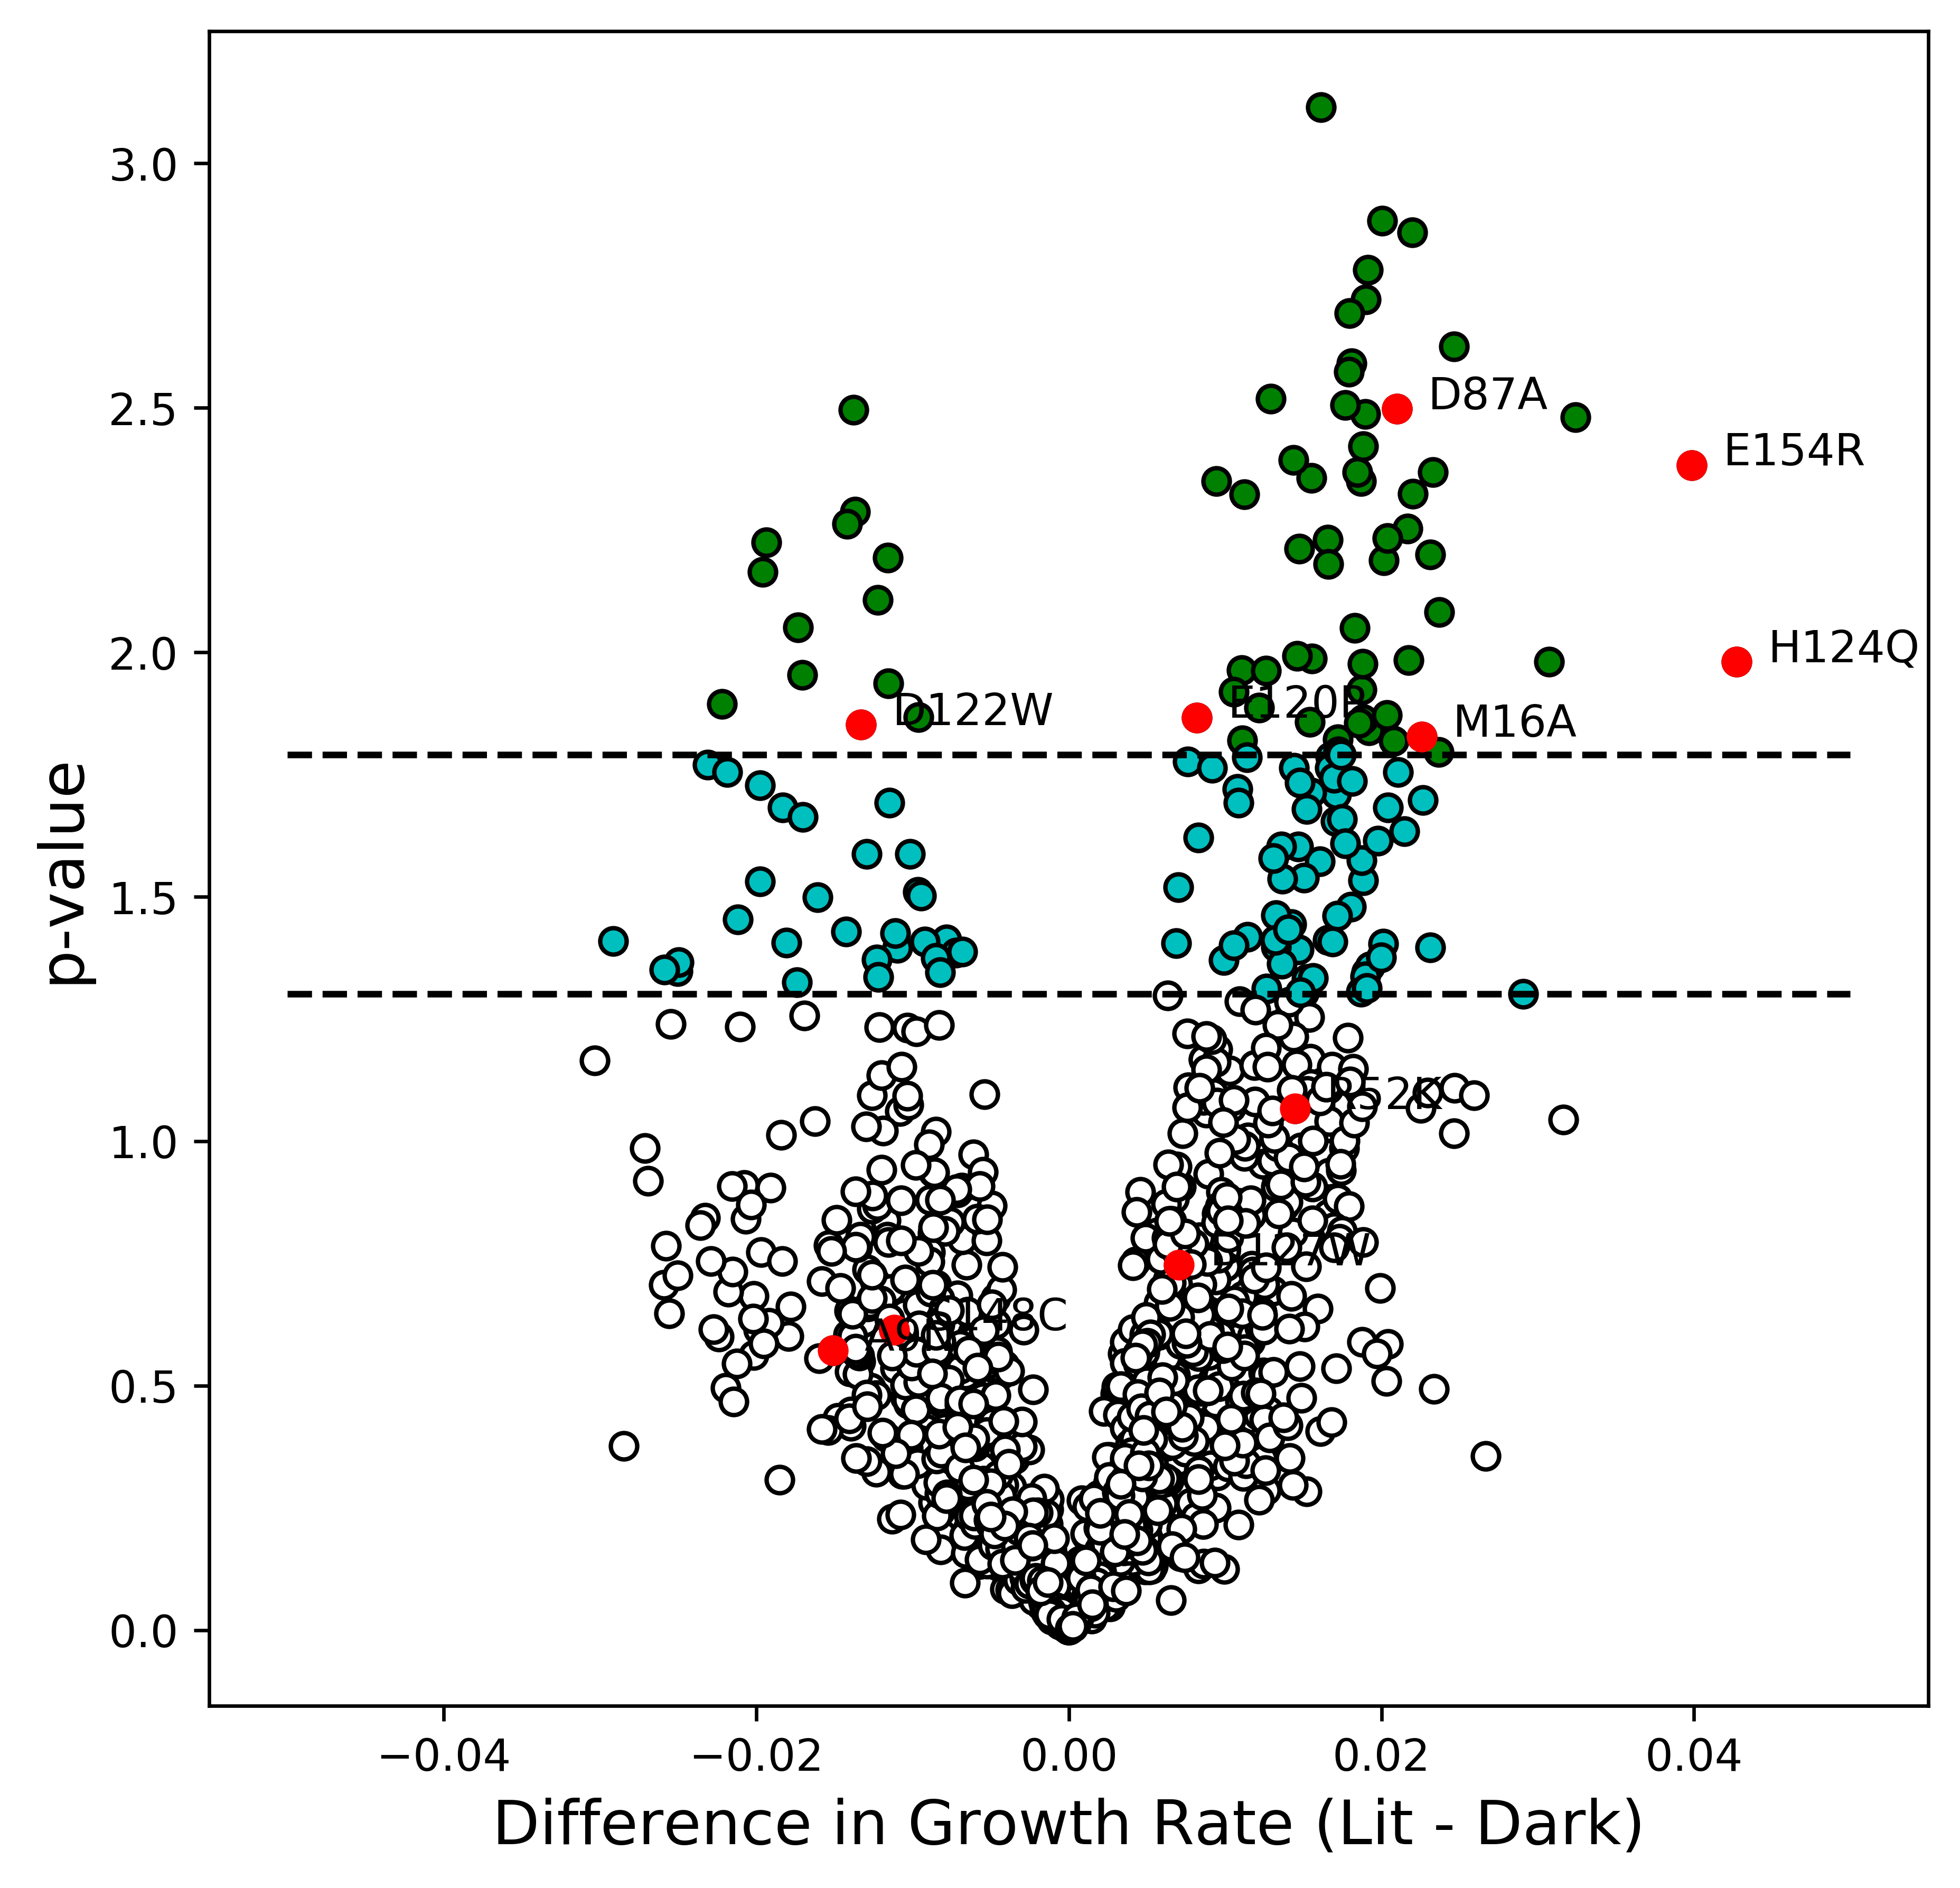

In [34]:
plt.subplots(figsize=(7,7))

#define p-value cutoffs
pval_std = 0.05
pval_cut = pval_SGoF
pval_bonferroni = pval_cut/np.sum(allostery > -999) #stringent multiple hypothesis testing correction

#empirical cutoff to examine the most allosteric mtuations
lgeff_cut = 0.025
lg_enhance_mut = []
lg_disrupt_mut = []


#some lists to record significantly allosteric positions, at two pval cutoffs. 
sig05_allo_mut, sigSGoF_allo_mut  = [], []
nonsig05_allo_mut, nonsigSGoF_allo_mut  = [], []

sig05_allo_enhance_mut, sigSGoF_allo_enhance_mut  = [],[]
nonsig05_allo_enhance_mut, nonsigSGoF_allo_enhance_mut = [],[]

sig05_allo_disrupt_mut, sigSGoF_allo_disrupt_mut = [],[]
nonsig05_allo_disrupt_mut, nonsigSGoF_allo_disrupt_mut = [],[]

sig05_allo_pos, sigSGoF_allo_pos = [], []
sig05_allo_disrupt_pos, sigSGoF_allo_disrupt_pos = [],[]
sig05_allo_enhance_pos, sigSGoF_allo_enhance_pos = [],[]

#mutants of interest - these were selected for experimental characterization
moi = ['H124Q','M16A','R52K','E120P','D127W','D122W','A9N','D87A', 'S148C','E154R']

for p in range(n_pos):
    #excluding stop codons
    for a in range(n_aa-1):
        mut= dhfr_wt[p]+str(p+1)+aas[a]
        #mutant has sufficient growth rate data to assess allostery:
        if (allostery[p,a] > -999):
            #mutant is not significant at a standard pvalue
            if (allostery_pvals[p,a] >= pval_std):
                nonsig05_allo_mut.append(mut)
                nonsig05_allo_enhance_mut.append(mut) 
                nonsig05_allo_disrupt_mut.append(mut)
            
                nonsigSGoF_allo_mut.append(mut)
                nonsigSGoF_allo_enhance_mut.append(mut) 
                nonsigSGoF_allo_disrupt_mut.append(mut)
                plt.plot(allostery[p,a],-np.log10(allostery_pvals[p,a]),'ow',markeredgecolor='k',markersize=6)

            #mutant is signficant at a standard pvalue, but not the adjusted pvalue
            if (allostery_pvals[p,a] < pval_std) and (allostery_pvals[p,a] >= pval_cut):
                nonsigSGoF_allo_mut.append(mut)
                nonsigSGoF_allo_enhance_mut.append(mut) 
                nonsigSGoF_allo_disrupt_mut.append(mut)
                
                sig05_allo_mut.append(mut)
                sig05_allo_pos.append(p+1)
                plt.plot(allostery[p,a],-np.log10(allostery_pvals[p,a]),'oc',markeredgecolor='k',markersize=6)
                if(allostery[p,a] > 0.0):
                    sig05_allo_enhance_mut.append(mut) 
                    sig05_allo_enhance_pos.append(p+1)
                    nonsig05_allo_disrupt_mut.append(mut)
                else:
                    sig05_allo_disrupt_mut.append(mut) 
                    sig05_allo_disrupt_pos.append(p+1)
                    nonsig05_allo_enhance_mut.append(mut) 
                
            #mutant is significant at both the adjusted and standard pvalue
            if (allostery_pvals[p,a] < pval_cut):
                sig05_allo_mut.append(mut)
                sig05_allo_pos.append(p+1)
                sigSGoF_allo_mut.append(mut)
                sigSGoF_allo_pos.append(p+1)
                plt.plot(allostery[p,a],-np.log10(allostery_pvals[p,a]),'og',markeredgecolor='k',markersize=6)
                if (abs(allostery[p,a]) > lgeff_cut):
                    lg_enhance_mut.append(mut) if allostery[p,a] > 0 else lg_disrupt_mut.append(mut)
                
                if(allostery[p,a] > 0.0):
                    sig05_allo_enhance_mut.append(mut) 
                    sig05_allo_enhance_pos.append(p+1)
                    nonsig05_allo_disrupt_mut.append(mut)
                    
                    sigSGoF_allo_enhance_mut.append(mut) 
                    sigSGoF_allo_enhance_pos.append(p+1)
                    nonsigSGoF_allo_disrupt_mut.append(mut)
                    
                else:
                    sig05_allo_disrupt_mut.append(mut) 
                    sig05_allo_disrupt_pos.append(p+1)
                    nonsig05_allo_enhance_mut.append(mut) 
                    
                    sigSGoF_allo_disrupt_mut.append(mut) 
                    sigSGoF_allo_disrupt_pos.append(p+1)
                    nonsigSGoF_allo_enhance_mut.append(mut) 
                     
 
xl = [-0.05,0.05] 
plt.plot(xl,-np.log10([pval_cut,pval_cut]),'--k')               #plots the SGoF adjusted pval
plt.plot(xl,-np.log10([pval_std,pval_std]),'--k')                         #plots the standard pval
#plt.plot(xl,-np.log10([pval_bonferroni,pval_bonferroni]),'--r') #none of the points are significant using
                                                                #the more stringent bonferroni criterion
plt.xlabel('Difference in Growth Rate (Lit - Dark)', fontsize=14)
plt.ylabel('p-value', fontsize=14)

#Label the mutations of interest    
for mut in moi:
    p = int(mut[1:-1])-1 # remember to subtract 1 to account for 0 index start
    a = aas.index(mut[-1])
    plt.plot(allostery[p,a],-np.log10(allostery_pvals[p,a]),'or')
    plt.text(allostery[p,a]+.002,-np.log10(allostery_pvals[p,a]),mut)
        
sigSGoF_allo_pos = set(sigSGoF_allo_pos)
sigSGoF_allo_enhance_pos = set(sigSGoF_allo_enhance_pos)
sigSGoF_allo_disrupt_pos = set(sigSGoF_allo_disrupt_pos)

sig05_allo_pos = set(sig05_allo_pos)
sig05_allo_enhance_pos = set(sig05_allo_enhance_pos)
sig05_allo_disrupt_pos = set(sig05_allo_disrupt_pos)
            
print('Largest allostery enhancing mutations: ')
print('+'.join(lg_enhance_mut))
lg_enhance_pos = [mut[1:-1] for mut in lg_enhance_mut]
print('+'.join(lg_enhance_pos))

print('Largest allostery disrupting mutations: ')
print('+'.join(lg_disrupt_mut))
lg_disrupt_pos = [mut[1:-1] for mut in lg_disrupt_mut]
print('+'.join(lg_disrupt_pos))
#plt.savefig('FigPanels/volcanoplot.pdf', format='pdf', dpi=300, pad_inches=1) 


## Print out lists of significant allosteric mutations, positions, and report some key statistics

In [35]:
print('**** At cutoff p<= 0.05*******')
print('There are %i mutations with sig allostery (out of %i total, %1.3f)' % \
      (len(sig05_allo_mut),len(sig05_allo_mut)+len(nonsig05_allo_mut),\
       len(sig05_allo_mut)/(len(sig05_allo_mut)+len(nonsig05_allo_mut))))
print('\n***There are %i mutations with sig enhancing allostery (out of %i total, %1.3f)' % \
      (len(sig05_allo_enhance_mut), len(sig05_allo_enhance_mut)+len(nonsig05_allo_enhance_mut),\
       len(sig05_allo_enhance_mut)/(len(sig05_allo_enhance_mut)+len(nonsig05_allo_enhance_mut))))
print(','.join(sig05_allo_enhance_mut))
print('These occur at %i positions: ' % len(sig05_allo_enhance_pos))
print('+'.join([str(i) for i in sig05_allo_enhance_pos]))
print('\n***There are %i mutations with sig disrupting allostery (out of %i total, %1.3f)' % \
      (len(sig05_allo_disrupt_mut), len(sig05_allo_disrupt_mut)+len(nonsig05_allo_disrupt_mut),\
       len(sig05_allo_disrupt_mut)/(len(sig05_allo_disrupt_mut)+len(nonsig05_allo_disrupt_mut))))
print(','.join(sig05_allo_disrupt_mut))
print('These occur at %i positions: ' % len(sig05_allo_disrupt_pos))
print('+'.join([str(i) for i in sig05_allo_disrupt_pos]))

print('\n\n')
print('**** At the SGoF adjusted pvalue*******')
print('There are %i mutations with sig allostery (out of %i total, %1.3f)' % \
      (len(sigSGoF_allo_mut),len(sigSGoF_allo_mut)+len(nonsigSGoF_allo_mut),\
       len(sigSGoF_allo_mut)/(len(sigSGoF_allo_mut)+len(nonsigSGoF_allo_mut))))
print('\n***There are %i mutations with sig enhancing allostery (out of %i total, %1.3f)' % \
      (len(sigSGoF_allo_enhance_mut), len(sigSGoF_allo_enhance_mut)+len(nonsigSGoF_allo_enhance_mut),\
       len(sigSGoF_allo_enhance_mut)/(len(sigSGoF_allo_enhance_mut)+len(nonsigSGoF_allo_enhance_mut))))
print(','.join(sigSGoF_allo_enhance_mut))
print('These occur at %i positions: ' % len(sigSGoF_allo_enhance_pos))
print('+'.join([str(i) for i in sigSGoF_allo_enhance_pos]))
print('\n***There are %i mutations with sig disrupting allostery (out of %i total, %1.3f)' % \
      (len(sigSGoF_allo_disrupt_mut), len(sigSGoF_allo_disrupt_mut)+len(nonsigSGoF_allo_disrupt_mut),\
       len(sigSGoF_allo_disrupt_mut)/(len(sigSGoF_allo_disrupt_mut)+len(nonsigSGoF_allo_disrupt_mut))))
print(','.join(sigSGoF_allo_disrupt_mut))
print('These occur at %i positions: ' % len(sigSGoF_allo_disrupt_pos))
print('+'.join([str(i) for i in sigSGoF_allo_disrupt_pos]))

**** At cutoff p<= 0.05*******
There are 161 mutations with sig allostery (out of 1548 total, 0.104)

***There are 118 mutations with sig enhancing allostery (out of 1548 total, 0.076)
A7W,M16A,A26D,R33D,A81F,A81Y,I82W,A83D,A83E,A83F,A83G,A83K,A83L,A83N,A83Q,A83T,A83V,A83W,A84I,A84M,A84Q,A84S,A84T,A84V,C85A,C85G,G86A,G86K,G86R,D87A,D87E,D87G,D87H,D87I,D87L,D87N,D87P,D87R,D87S,D87T,D87W,V88A,V88P,V88S,V88T,P89A,P89D,P89K,I91G,V93A,V93I,V93R,I94A,I94V,G95R,G96P,G97E,G97S,R98C,R98K,R98M,R98N,R98S,R98T,R98V,V99I,Y100G,E101S,Q102A,P105Q,K106F,K106I,K106L,K106M,K106Q,K106R,K106V,K106Y,Q108K,Q108M,Q108N,Q108R,Q108T,K109R,K109Y,L110P,H114W,I115V,D116H,D116M,A117G,E118A,E118C,E118I,E118K,E118M,E118P,E118Q,E118S,E118T,E118V,V119R,E120P,H124Q,D127F,D127H,D127K,D127M,D127N,D127R,D127T,D127V,D127Y,S138E,F140C,D142E,S148T,E154R
These occur at 43 positions: 
7+138+140+142+16+148+26+154+33+81+82+83+84+85+86+87+88+89+91+93+94+95+96+97+98+99+100+101+102+105+106+108+109+110+114+115+116+117+118+119+120+12

#### Scatter plot of allosteric effect vs. dark growth rate

Another way to look at the complete dataset, that lets one inspect the relationship between allostery and growth rate. Color coding the points as above (in the volcano plot) -> white (no sig allostery), cyan (sig allostery at p = 0.05), green (sig allostery at the SGoF adjusted pvalue).



"moi = ['H124Q','M16A','R52K','E120P','D127W','D122W','A9N','D87A', 'S148C','E154R']\nfor mut in moi:\n    p = int(mut[1:-1])-1 #remember to subtract 1 to account for 0 index start\n    a = aas.index(mut[-1])\n    plt.errorbar(avg_gr_dark[p,a],allostery[p,a],yerr=allostery_sd[p,a],             xerr=sd_gr_dark[p,a], marker='o',mfc= '#00000000',             ls='',ms='8',mec='r',c='#BEBEBE')\n    print(mut, avg_gr_dark[p,a], avg_gr_lit[p,a],allostery_sd[p,a] )\n    plt.text(avg_gr_dark[p,a],allostery[p,a]+0.002,mut,weight='bold',color='red')"

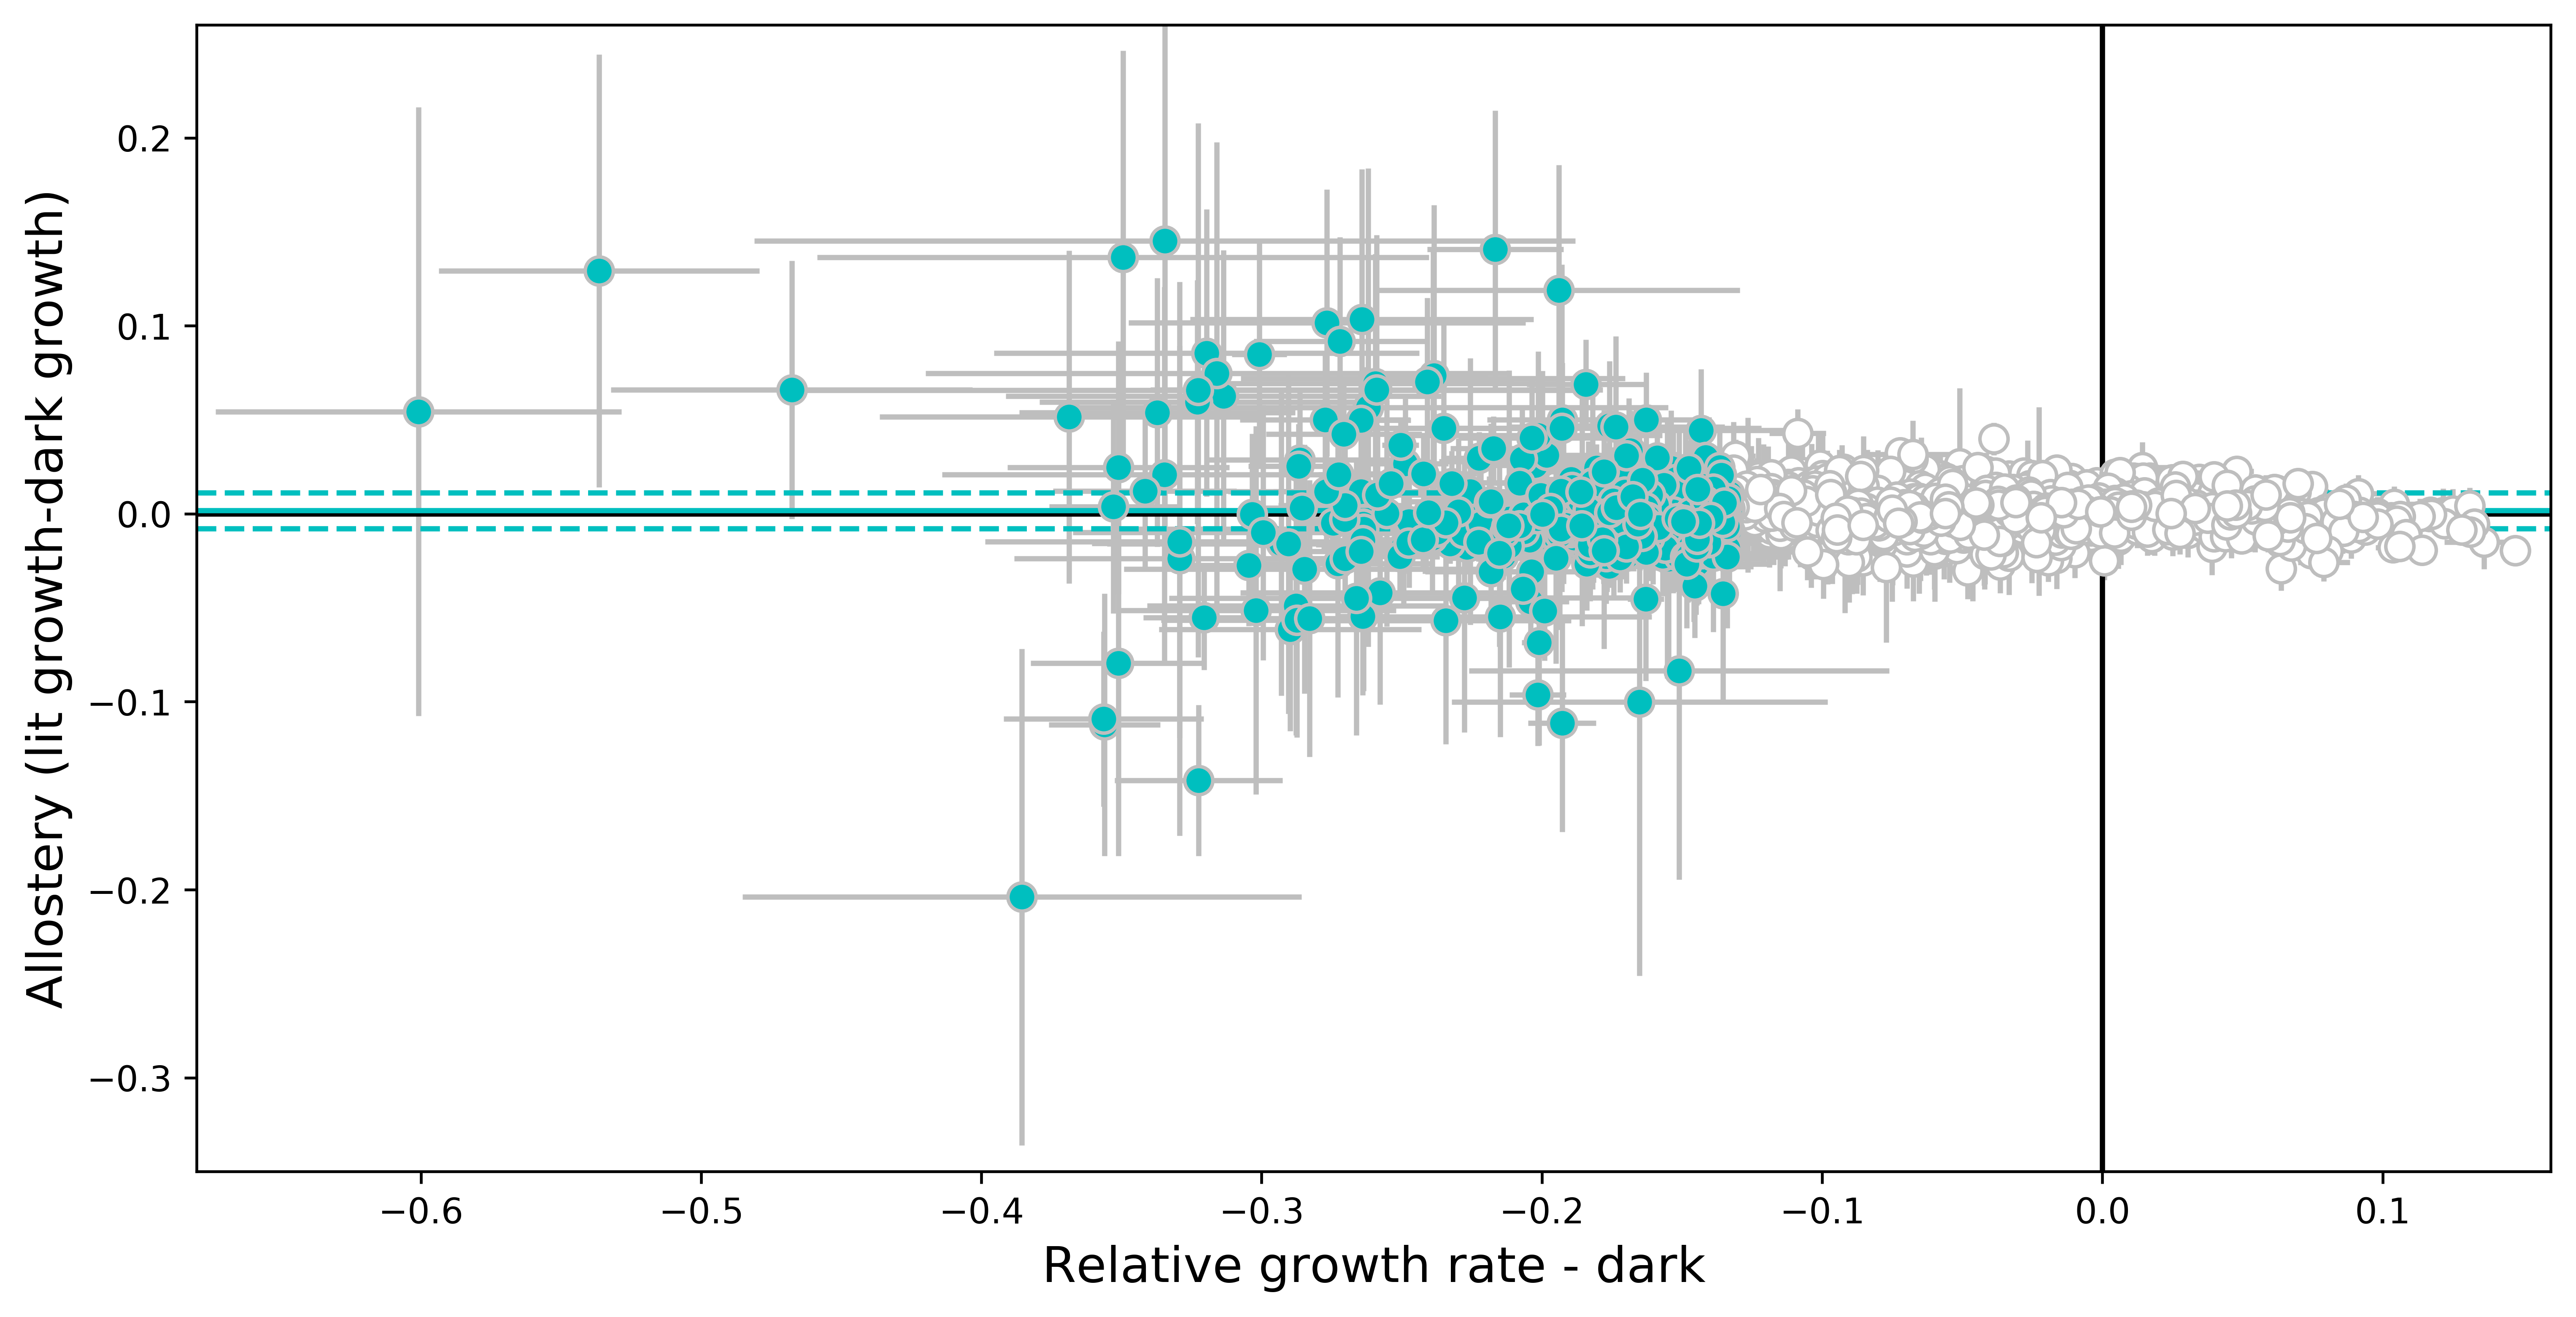

In [36]:
plt.rcParams['figure.figsize'] = (12,6)

#getting the data into 1D, filtered form
allo_flat = allostery[:,0:-1].flatten()
pvals_flat = allostery_pvals[:,0:-1].flatten()

allo_flat_all = allostery_all[:,0:-1].flatten()
pvals_flat_all = allostery_pvals_all[:,0:-1].flatten()
avg_gr_dark_flat = avg_gr_dark[:,0:-1].flatten()

#plot all the data that is not from catalytically dead
keep_ix = [i for i,a in enumerate(allo_flat) if (a > -999 and avg_gr_dark_flat[i] > cut_darkSlowGR)]
y = allo_flat[keep_ix]
x = avg_gr_dark[:,0:-1].flatten()[keep_ix]
y_err = allostery_sd[:,0:-1].flatten()[keep_ix]
x_err = sd_gr_dark[:,0:-1].flatten()[keep_ix]
plt.errorbar(x,y,yerr=y_err, xerr=x_err,marker='o',mfc='w',\
             ls='',ms='8',mec='#BEBEBE',c='#BEBEBE',)
plt.xlim([-0.68,0.16])
plt.ylim([-0.35,0.26])

#plot points from everything
keep_ix = [i for i,a in enumerate(allo_flat_all) if (a > -999 and avg_gr_dark_flat[i] < cut_darkSlowGR)]
y = allo_flat_all[keep_ix]
x = avg_gr_dark[:,0:-1].flatten()[keep_ix]
y_err = allostery_sd_all[:,0:-1].flatten()[keep_ix]
x_err = sd_gr_dark[:,0:-1].flatten()[keep_ix]
plt.errorbar(x,y,yerr=y_err, xerr=x_err,marker='o',mfc='c',\
             ls='',ms='8',mec='#BEBEBE',c='#BEBEBE',)



#avg_gr_dark_low_filtered = [gr for gr in avg_gr_dark.flatten() if (gr > -999 and gr < cut_darkSlowGR)]
#avg_gr_dark_high_filtered = [gr for gr in avg_gr_dark.flatten() if (gr > -999 and gr > cut_darkSlowGR)]

#plot points that are sig at adjusted pval
"""keep_ix = [i for i,a in enumerate(allo_flat) if (a > -999 and pvals_flat[i] < pval_SGoF)]
y = allo_flat[keep_ix]
x = avg_gr_dark[:,0:-1].flatten()[keep_ix]
y_err = allostery_sd[:,0:-1].flatten()[keep_ix]
x_err = sd_gr_dark[:,0:-1].flatten()[keep_ix]
plt.rcParams['figure.figsize'] = (12,6)
plt.errorbar(x,y,yerr=y_err, xerr=x_err,marker='o',mfc='g',\
             ls='',ms='8',mec='k',c='#BEBEBE',)
plt.xlim([-0.16,0.16])
plt.ylim([-0.075,0.075])"""

#plot lines indicating zeros and mean/sd of allo effect
plt.plot([0,0],[-0.35,0.26],'k-')
plt.plot([-0.68,0.16],[0,0],'k-')
mean_allo = np.mean(allostery_filtered)
sd_allo = np.std(allostery_filtered)
plt.plot([-0.68,.16],[mean_allo,mean_allo],'c-')
plt.plot([-0.68,.16],[mean_allo+sd_allo,mean_allo+sd_allo],'c--')
plt.plot([-0.68,.16],[mean_allo-sd_allo,mean_allo-sd_allo],'c--')

plt.xlabel('Relative growth rate - dark',fontsize=14)
plt.ylabel('Allostery (lit growth-dark growth)',fontsize=14)

#highlight mutants of interest on the plot
"""moi = ['H124Q','M16A','R52K','E120P','D127W','D122W','A9N','D87A', 'S148C','E154R']
for mut in moi:
    p = int(mut[1:-1])-1 #remember to subtract 1 to account for 0 index start
    a = aas.index(mut[-1])
    plt.errorbar(avg_gr_dark[p,a],allostery[p,a],yerr=allostery_sd[p,a],\
             xerr=sd_gr_dark[p,a], marker='o',mfc= '#00000000',\
             ls='',ms='8',mec='r',c='#BEBEBE')
    print(mut, avg_gr_dark[p,a], avg_gr_lit[p,a],allostery_sd[p,a] )
    plt.text(avg_gr_dark[p,a],allostery[p,a]+0.002,mut,weight='bold',color='red')"""
#plt.savefig('FigPanels/allosteryVsGrowthRate.pdf', format='pdf', dpi=300, pad_inches=1) 

#### Plot of replicate growth rate measurements in lit and dark conditions for mutations with significant allostery

These are sorted from lowest growth rate to highest (according to average growth rate in the dark)

([<matplotlib.axis.XTick at 0x1a1b439d68>,
 <a list of 13 Text xticklabel objects>)

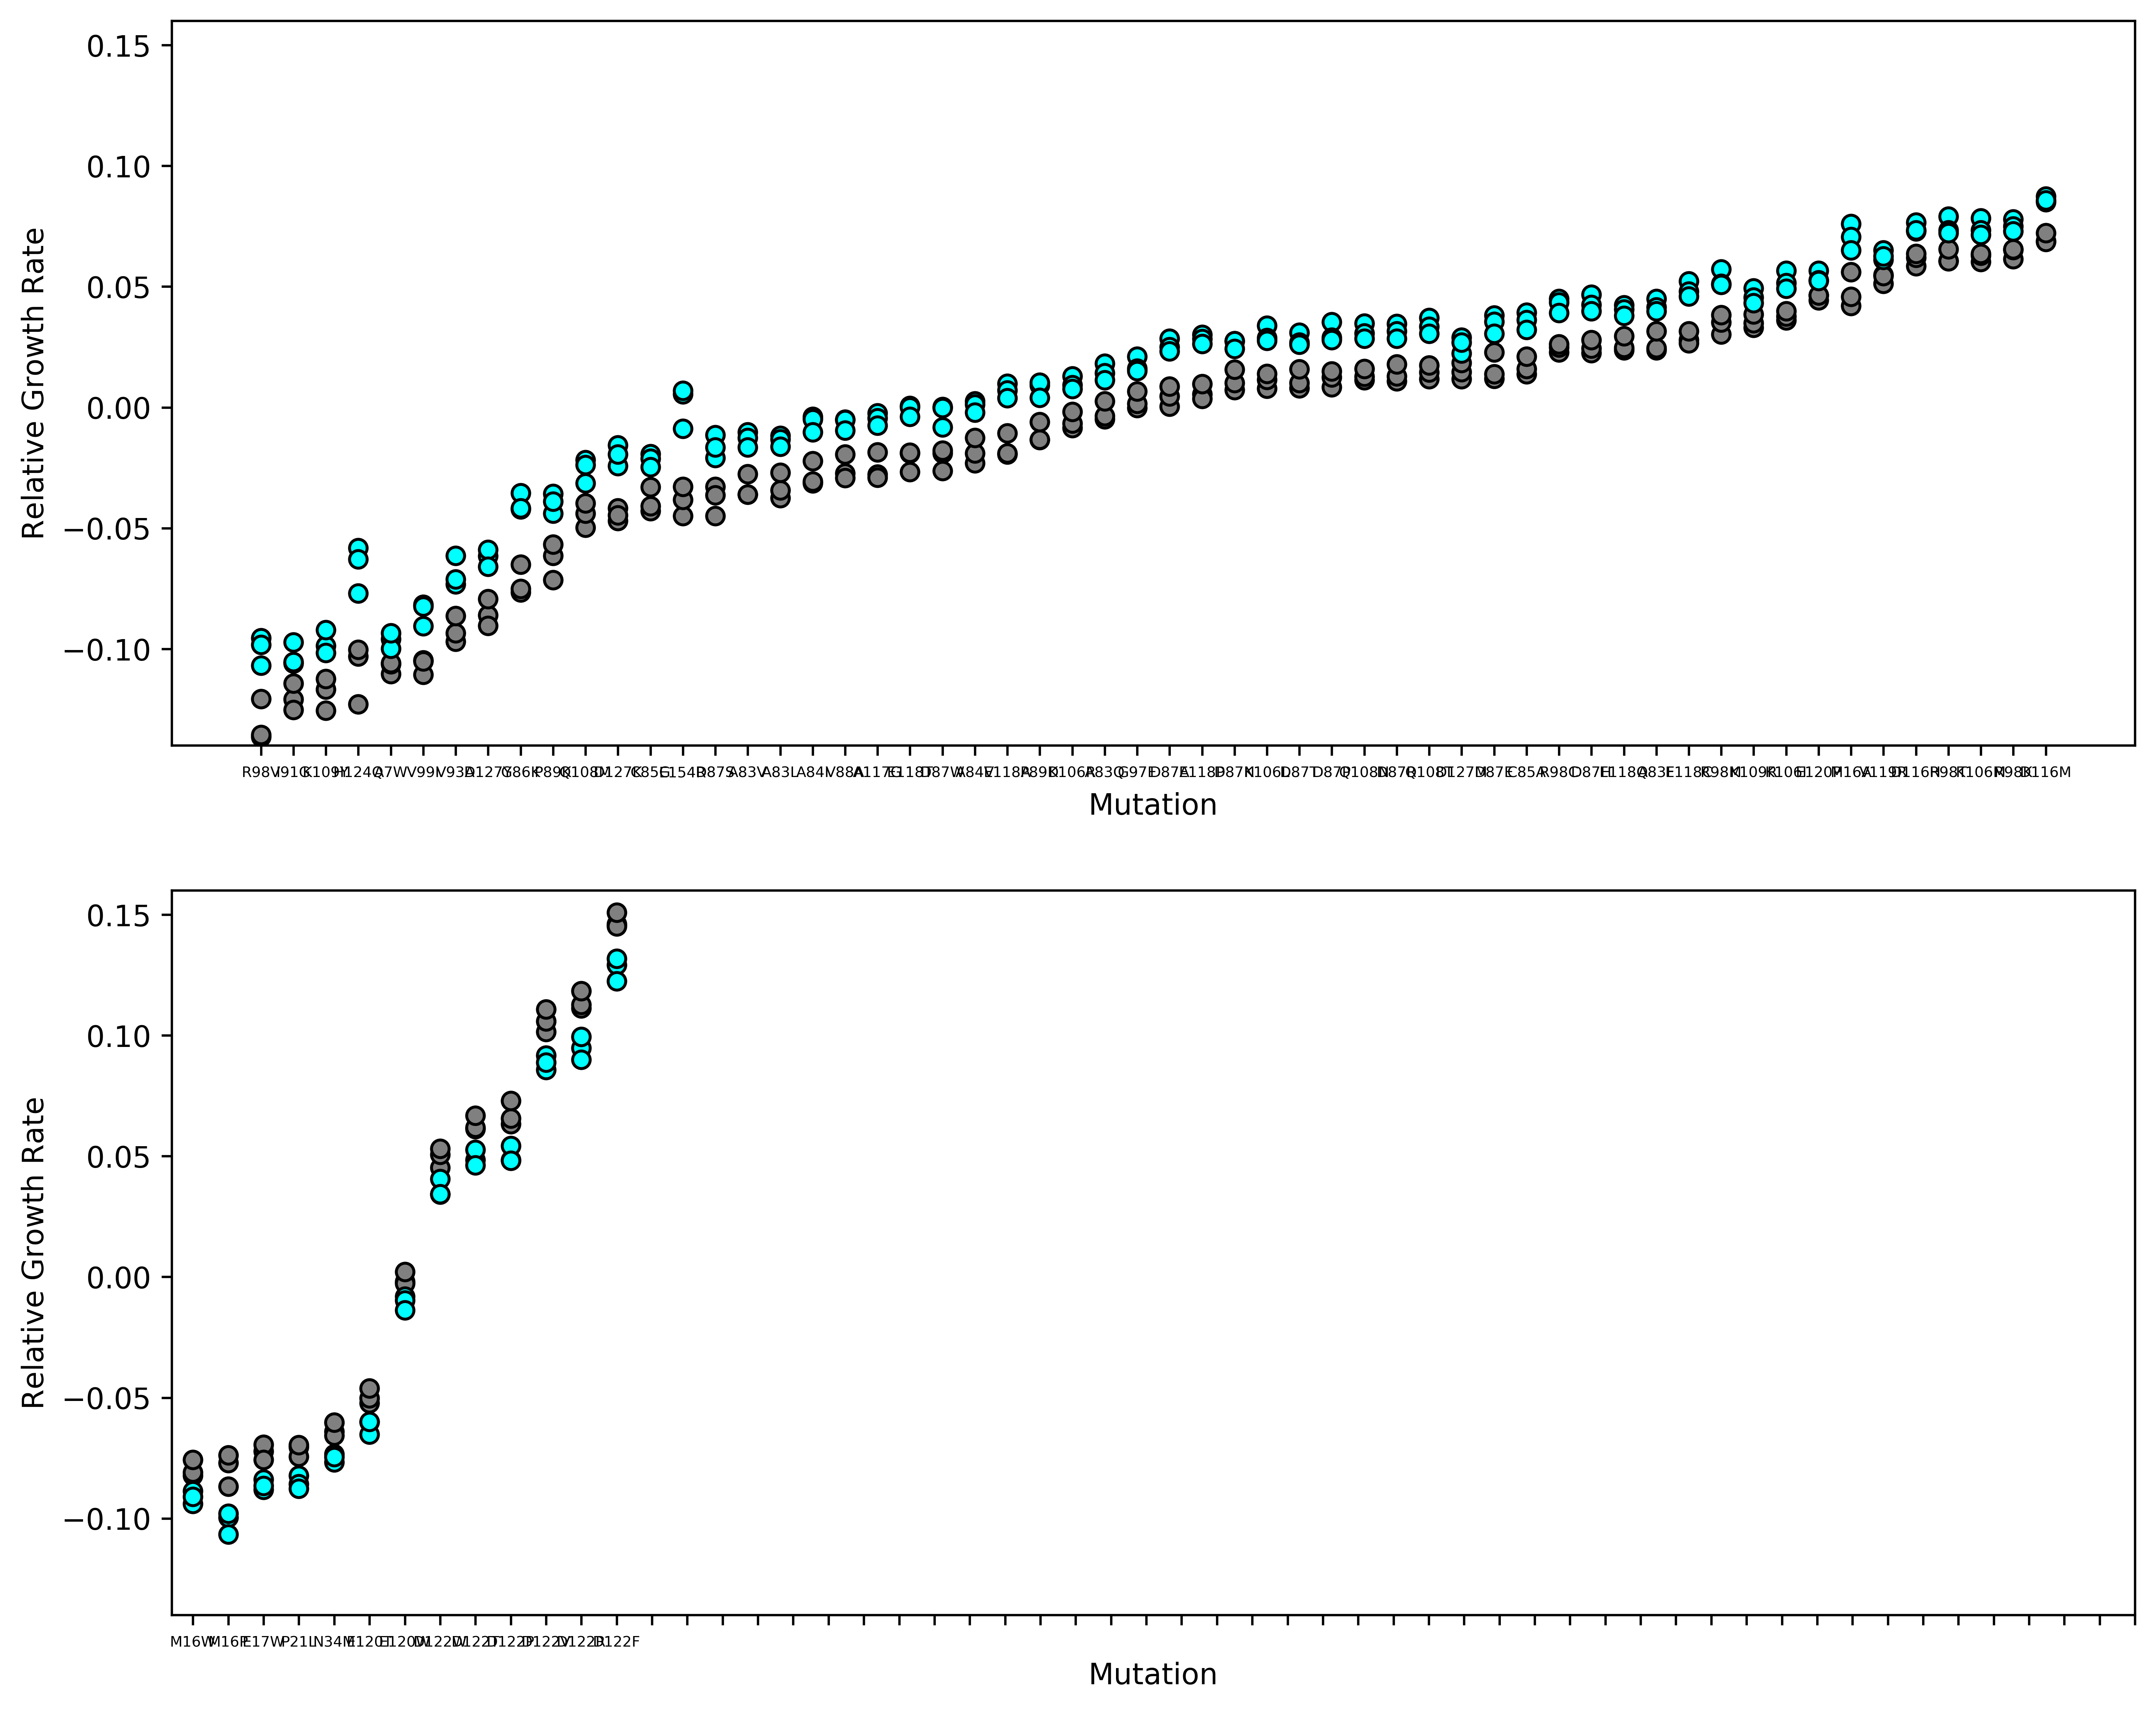

In [37]:
plt.rcParams['figure.figsize'] = (12,10)

plt.subplot(2,1,1)
dk_gr_sig_allo_enhance_mut = [avg_gr_dark[int(k[1:-1])-1,aas.index(k[-1])] for k in sigSGoF_allo_enhance_mut]
sig_allo_enhance_mut_sorted = [x for _,x in sorted(zip(dk_gr_sig_allo_enhance_mut,sigSGoF_allo_enhance_mut))]
xvals = np.arange(len(sigSGoF_allo_enhance_mut))
for i,k in enumerate(sig_allo_enhance_mut_sorted):
    pos_ix = int(k[1:-1])-1 
    mut_ix = aas.index(k[-1])
    plt.plot([xvals[i],xvals[i],xvals[i]],all_gr_dark[pos_ix,mut_ix,:],'ok',\
                 markerfacecolor='grey',markersize=6)
    plt.plot([xvals[i],xvals[i],xvals[i]],all_gr_lit[pos_ix,mut_ix,:],'ok',\
                 markerfacecolor='cyan',markersize=6)
    
plt.xticks(xvals,sig_allo_enhance_mut_sorted,fontsize=5)    
plt.xlabel('Mutation')
plt.ylabel('Relative Growth Rate')
plt.ylim([-.14,0.16])

plt.subplot(2,1,2)
dk_gr_sig_allo_disrupt_mut = [avg_gr_dark[int(k[1:-1])-1,aas.index(k[-1])] for k in sigSGoF_allo_disrupt_mut]
sig_allo_disrupt_mut_sorted = [x for _,x in sorted(zip(dk_gr_sig_allo_disrupt_mut,sigSGoF_allo_disrupt_mut))]
xvals = np.arange(len(sigSGoF_allo_disrupt_mut))
for i,k in enumerate(sig_allo_disrupt_mut_sorted):
    pos_ix = int(k[1:-1])-1 
    mut_ix = aas.index(k[-1])
    plt.plot([xvals[i],xvals[i],xvals[i]],all_gr_dark[pos_ix,mut_ix,:],'ok',\
                 markerfacecolor='grey',markersize=6)
    plt.plot([xvals[i],xvals[i],xvals[i]],all_gr_lit[pos_ix,mut_ix,:],'ok',\
                 markerfacecolor='cyan',markersize=6)
    
plt.xlabel('Mutation')
plt.ylabel('Relative Growth Rate')
plt.ylim([-.14,0.16])
plt.xticks(np.arange(len(sigSGoF_allo_enhance_mut)),sig_allo_disrupt_mut_sorted,fontsize=5)
#plt.savefig('FigPanels/RelGRSigAlloMut.pdf', dpi=300)

## 5. Test the statistical association between allosteric mutations, sector positions, and surface positions

We examine this association at both the more stringent (SGoF adjusted) and standard pvalue cutoffs for significant allostery.

In [38]:

number = 0
for sector_compare in secdef:
    sec_and_inactive, sec_and_active = 0,0
    nonsec_and_inactive, nonsec_and_active = 0,0
    for p in range(n_pos):
         #here we use n_aa -1, because we exclude the stop codon.
        for aa in range(n_aa - 1):
            #mutation is inactivating
            if (allostery[p,aa] == -999):
                if (p+1) in sector_compare:
                    sec_and_inactive += 1
                else:
                    nonsec_and_inactive += 1
            #mutation is not inactivating, and is present
            elif (allostery[p,aa] != -1000):
                if (p+1) in sector_compare:
                    sec_and_active += 1
                else:
                    nonsec_and_active += 1
                    
    sector_p_value_cutoff = secp_cutoffs[number]
    observed = np.array([[sec_and_inactive, nonsec_and_inactive],[sec_and_active, nonsec_and_active]])
    chi2, pval, dof, expected =stats.chi2_contingency(observed)
    print('--------------- sector cuttof is: %s ' % sector_p_value_cutoff)
    print(observed)
    print('chi^2 value is: %s' % chi2)
    print('p value is: %s' % pval)
    print(expected)           

    #printing out some sanity checks to make sure we are accounting for all mutations properly:
    print('**** Some sanity/consistency checks:')
    print('Number of inactivating mutations: %i' % (sec_and_inactive + nonsec_and_inactive))
    print('(this should match to %i)' % np.sum(allostery[:,0:20] == -999))
    print('Total number of measurements: %i ' % (sec_and_inactive + nonsec_and_inactive + \
                                               sec_and_active + nonsec_and_active))
    print('(this should match to %i)' % ((159*20) - np.sum(allostery[:,0:20] == -1000)))
    number = number + 1 

--------------- sector cuttof is: 0.005 
[[ 223 1024]
 [ 173 1375]]
chi^2 value is: 25.00063781617915
p value is: 5.731135244530324e-07
[[ 176.67692308 1070.32307692]
 [ 219.32307692 1328.67692308]]
**** Some sanity/consistency checks:
Number of inactivating mutations: 1247
(this should match to 1247)
Total number of measurements: 2795 
(this should match to 2795)
--------------- sector cuttof is: 0.008 
[[ 332  915]
 [ 295 1253]]
chi^2 value is: 22.294388258818756
p value is: 2.338891172618984e-06
[[ 279.73846154  967.26153846]
 [ 347.26153846 1200.73846154]]
**** Some sanity/consistency checks:
Number of inactivating mutations: 1247
(this should match to 1247)
Total number of measurements: 2795 
(this should match to 2795)
--------------- sector cuttof is: 0.01 
[[ 373  874]
 [ 325 1223]]
chi^2 value is: 28.834860931595134
p value is: 7.881957819956944e-08
[[ 311.41538462  935.58461538]
 [ 386.58461538 1161.41538462]]
**** Some sanity/consistency checks:
Number of inactivating mutati

In [39]:
#A function for computing the chi2 association
#Inputs: 
#sigmut = list of significant (allosteric) mutations
#nonsigmut = list of insignificant (but measured) allosteric mutations
#cat_res = list of residues in some category (e.g. sector positions)
def assoc_chi2(sigmut,nonsigmut, cat_res):
    sigmut_and_cat = len([mut for mut in sigmut if int(mut[1:-1]) in cat_res])
    sigmut_not_cat = len([mut for mut in sigmut if int(mut[1:-1]) not in cat_res])
    nonsigmut_and_cat = len([mut for mut in nonsigmut if int(mut[1:-1]) in cat_res])
    nonsigmut_not_cat = len([mut for mut in nonsigmut if int(mut[1:-1]) not in cat_res])
    observed = np.array([[sigmut_and_cat, sigmut_not_cat],[nonsigmut_and_cat, nonsigmut_not_cat]])
    chi2, pval, dof, expected =stats.chi2_contingency(observed)
    print(observed)
    print('chi^2 value is: %s' % chi2)
    print('p value is: %s' % pval)
    print(expected)


#statistical association of each residue group with the sector
number = 0
for sector_compare in secdef:
    print('************ At allostery pval cutoff 0.05 and sector cuttof %s:'% secp_cutoffs[number])
    print('**Association of all allosteric mutations and the sector:')
    assoc_chi2(sig05_allo_mut,nonsig05_allo_mut, sector_compare)
    print('**Association of enhancing allosteric mutations and the sector:')
    assoc_chi2(sig05_allo_enhance_mut,nonsig05_allo_enhance_mut, sector_compare)
    print('**Association of disrupting allosteric mutations and the sector:')
    assoc_chi2(sig05_allo_disrupt_mut,nonsig05_allo_disrupt_mut, sector_compare)

    print('\n************ At pval cutoff %1.3f and sector cuttof %s:' % (pval_cut, secp_cutoffs[number]))
    print('**Association of all allosteric mutations and the sector:')
    assoc_chi2(sigSGoF_allo_mut,nonsigSGoF_allo_mut, sector_compare)
    print('**Association of enhancing allosteric mutations and the sector:')
    assoc_chi2(sigSGoF_allo_enhance_mut,nonsigSGoF_allo_enhance_mut, sector_compare)
    print('**Association of disrupting allosteric mutations and the sector:')
    assoc_chi2(sigSGoF_allo_disrupt_mut,nonsigSGoF_allo_disrupt_mut, sector_compare)
    number = number + 1 

#statistical association of each residue group with surface accessiblity
print('\n\n************ At pval cutoff 0.05:')
print('**Association of all allosteric mutations and surface:')
assoc_chi2(sig05_allo_mut,nonsig05_allo_mut, surfRes)
print('**Association of enhancing allosteric mutations and surface:')
assoc_chi2(sig05_allo_enhance_mut,nonsig05_allo_enhance_mut, surfRes)
print('**Association of disrupting allosteric mutations and surface:')
assoc_chi2(sig05_allo_disrupt_mut,nonsig05_allo_disrupt_mut, surfRes)

print('\n************ At pval cutoff %1.3f:' % pval_cut)
print('**Association of all allosteric mutations and surface:')
assoc_chi2(sigSGoF_allo_mut,nonsigSGoF_allo_mut, surfRes)
print('**Association of enhancing allosteric mutations and surface:')
assoc_chi2(sigSGoF_allo_enhance_mut,nonsigSGoF_allo_enhance_mut, surfRes)
print('**Association of disrupting allosteric mutations and surface:')
assoc_chi2(sigSGoF_allo_disrupt_mut,nonsigSGoF_allo_disrupt_mut, surfRes)




************ At allostery pval cutoff 0.05 and sector cuttof 0.005:
**Association of all allosteric mutations and the sector:
[[   6  155]
 [ 167 1220]]
chi^2 value is: 9.224026400552921
p value is: 0.002388596755595373
[[  17.99289406  143.00710594]
 [ 155.00710594 1231.99289406]]
**Association of enhancing allosteric mutations and the sector:
[[   4  114]
 [ 169 1261]]
chi^2 value is: 6.974603303281326
p value is: 0.008267454771037104
[[  13.1873385  104.8126615]
 [ 159.8126615 1270.1873385]]
**Association of disrupting allosteric mutations and the sector:
[[   2   41]
 [ 171 1334]]
chi^2 value is: 1.2808854590496208
p value is: 0.2577344640767067
[[   4.80555556   38.19444444]
 [ 168.19444444 1336.80555556]]

************ At pval cutoff 0.016 and sector cuttof 0.005:
**Association of all allosteric mutations and the sector:
[[   1   68]
 [ 172 1307]]
chi^2 value is: 5.895266839085172
p value is: 0.01518162916834846
[[   7.71124031   61.28875969]
 [ 165.28875969 1313.71124031]]
**Ass

Here we examine the relationship between allosteric mutations and sector connected surface sites. 

In [40]:
#statistical association of each residue group with the sector
number = 0
for sector_compare in sec_conn_surf:
    print('************ At allostery pval cutoff 0.05 and sector cuttof %s:'% sec_conn_surf_cutoffs[number])
    print('**Association of all allosteric mutations and the sector connected surface sites:')
    assoc_chi2(sig05_allo_mut,nonsig05_allo_mut, sector_compare)
    print('**Association of enhancing allosteric mutations and the sector connected surface sites:')
    assoc_chi2(sig05_allo_enhance_mut,nonsig05_allo_enhance_mut, sector_compare)
    print('**Association of disrupting allosteric mutations and the sector connected surface sites:')
    assoc_chi2(sig05_allo_disrupt_mut,nonsig05_allo_disrupt_mut, sector_compare)

    print('\n************ At pval cutoff %1.3f and sector cuttof %s:' % (pval_cut, sec_conn_surf_cutoffs[number]))
    print('**Association of all allosteric mutations and the sector connected surface sites:')
    assoc_chi2(sigSGoF_allo_mut,nonsigSGoF_allo_mut, sector_compare)
    print('**Association of enhancing allosteric mutations and the sector connected surface sites:')
    assoc_chi2(sigSGoF_allo_enhance_mut,nonsigSGoF_allo_enhance_mut, sector_compare)
    print('**Association of disrupting allosteric mutations and the sector connected surface sites:')
    assoc_chi2(sigSGoF_allo_disrupt_mut,nonsigSGoF_allo_disrupt_mut, sector_compare)
    number = number + 1 

************ At allostery pval cutoff 0.05 and sector cuttof 0.005:
**Association of all allosteric mutations and the sector connected surface sites:
[[  21  140]
 [ 210 1177]]
chi^2 value is: 0.3481787046762865
p value is: 0.5551459362252735
[[  24.0251938  136.9748062]
 [ 206.9748062 1180.0251938]]
**Association of enhancing allosteric mutations and the sector connected surface sites:
[[   2  116]
 [ 229 1201]]
chi^2 value is: 16.494582485090397
p value is: 4.878928171715927e-05
[[  17.60852713  100.39147287]
 [ 213.39147287 1216.60852713]]
**Association of disrupting allosteric mutations and the sector connected surface sites:
[[  19   24]
 [ 212 1293]]
chi^2 value is: 27.509561704159815
p value is: 1.563197683542076e-07
[[   6.41666667   36.58333333]
 [ 224.58333333 1280.41666667]]

************ At pval cutoff 0.016 and sector cuttof 0.005:
**Association of all allosteric mutations and the sector connected surface sites:
[[   9   60]
 [ 222 1257]]
chi^2 value is: 0.0758022488100767

What about surface sites that are sector connected but not the sector? 

In [41]:
#statistical association of each residue group connected to the sector on the surface but not themselves
#in the sector
number = 0
for sector_compare in sec_conn_surf:
    surface_conn_not_sector = [x for x in sector_compare if x not in secdef[number]] 
    #filters for the positions that are on the surface and sector connected but not sector positions themselves. 
    
    print('************ At allostery pval cutoff 0.05 and sector cuttof %s:'% sec_conn_surf_cutoffs[number])
    print('**Association of all allosteric mutations and the sector connected not sector surface sites:')
    assoc_chi2(sig05_allo_mut,nonsig05_allo_mut, surface_conn_not_sector)
    print('**Association of enhancing allosteric mutations and the sector connected not sector surface sites:')
    assoc_chi2(sig05_allo_enhance_mut,nonsig05_allo_enhance_mut, surface_conn_not_sector)
    print('**Association of disrupting allosteric mutations and the sector connected not sector surface sites:')
    assoc_chi2(sig05_allo_disrupt_mut,nonsig05_allo_disrupt_mut, surface_conn_not_sector)

    print('\n************ At pval cutoff %1.3f and sector cuttof %s:' % (pval_cut, sec_conn_surf_cutoffs[number]))
    print('**Association of all allosteric mutations and the sector connected not sector surface sites:')
    assoc_chi2(sigSGoF_allo_mut,nonsigSGoF_allo_mut, surface_conn_not_sector)
    print('**Association of enhancing allosteric mutations and the sector connected not sector surface sites:')
    assoc_chi2(sigSGoF_allo_enhance_mut,nonsigSGoF_allo_enhance_mut, surface_conn_not_sector)
    print('**Association of disrupting allosteric mutations and the sector connected not sector surface sites:')
    assoc_chi2(sigSGoF_allo_disrupt_mut,nonsigSGoF_allo_disrupt_mut, surface_conn_not_sector)
    number = number + 1 
    

************ At allostery pval cutoff 0.05 and sector cuttof 0.005:
**Association of all allosteric mutations and the sector connected not sector surface sites:
[[  20  141]
 [ 152 1235]]
chi^2 value is: 0.18218584728647108
p value is: 0.6695014486930851
[[  17.88888889  143.11111111]
 [ 154.11111111 1232.88888889]]
**Association of enhancing allosteric mutations and the sector connected not sector surface sites:
[[   2  116]
 [ 170 1260]]
chi^2 value is: 10.458506430010667
p value is: 0.0012208594869526873
[[  13.11111111  104.88888889]
 [ 158.88888889 1271.11111111]]
**Association of disrupting allosteric mutations and the sector connected not sector surface sites:
[[  18   25]
 [ 154 1351]]
chi^2 value is: 39.20008305647839
p value is: 3.8252395990007157e-10
[[   4.77777778   38.22222222]
 [ 167.22222222 1337.77777778]]

************ At pval cutoff 0.016 and sector cuttof 0.005:
**Association of all allosteric mutations and the sector connected not sector surface sites:
[[   9   60]

We observe that:
   1. allostery enhancing mutations are statistically significantly *depleted* from the sector
   2. allostery disrupting mutations are statistically significantly *enriched* in the sector
   3. allosteric mutations are enriched on the protein surface; this is particularly true for allostery enhancing mutations (the association for allostery disrupting mutations is less strong)

#### Examine the structural distribution of allostery-influencing mutations relative to the 121 insertion site

Structural examination indicates that allostery-disrupting mutations are localized to the insertion site, while allostery enhancing mutations are more structurally distributed. Here, we illustrate this by plotting the cumulative fraction of allostery-influencing mutations as a function of distance to position 121.

First, we calculate the c$\alpha$ - c$\alpha$ distance of each residue to position 121, using the PDB file 1RX2 

In [42]:
distance_from_121 = []
parser = PDBParser()
structure = parser.get_structure("1RX2", "1RX2.pdb")
residues = [r for r in structure.get_residues() if r.get_id()[0] == " "]
for k in range(n_pos):
    one  = residues[k]["CA"].get_coord()
    two = residues[120]["CA"].get_coord()
    distance_from_121.append(np.linalg.norm(one-two)) 
    

Counting the number of allosteric mutants per position, and computing the cumulative distributions

In [43]:
#this function takes a list of significant mutations, and counts the number of mutations per position
#the list is then joined to a list of distances, and formatted/sorted in preparation for 
#computing the cumulative distributions.
def residue_counter(sig_mutants):
    nsig_mutant_list = []
    for pos in range(n_pos):
        nsig_mutant_list.append(len([mut for mut in sig_mutants if int(mut[1:-1])==(pos+1)]))
    mut_dist_mat = np.matrix(np.column_stack((range(n_pos),nsig_mutant_list, distance_from_121)))
    mut_dist_mat_sort = mut_dist_mat[np.argsort(mut_dist_mat.A[:,2])]
    return mut_dist_mat_sort


#running the function to count mutations per position, and organize alongside distance information
enhance_allostery05_count = residue_counter(sig05_allo_enhance_mut)
disrupt_allostery05_count = residue_counter(sig05_allo_disrupt_mut)
nonsig_allostery05_count = residue_counter(nonsig05_allo_mut)

enhance_allosterySGoF_count = residue_counter(sigSGoF_allo_enhance_mut)
disrupt_allosterySGoF_count = residue_counter(sigSGoF_allo_disrupt_mut)
nonsig_allosterySGoF_count = residue_counter(nonsigSGoF_allo_mut)

#compute the cumulative number of mutations as a function of distance
def cumulative_distro(distances_sort):
    distances_sort_cd = np.zeros((n_pos,4))
    distances_sort_cd[:,0:3] = distances_sort
    for pos in range(1,n_pos): 
        distances_sort_cd[pos,1]= distances_sort_cd[pos-1,1] \
                                        + distances_sort_cd[pos,1]
    #normalize to total number of mutations
    distances_sort_cd[:,3] = distances_sort_cd[:,1]/distances_sort_cd[-1,1]
    return distances_sort_cd

enhance_allostery05_cd = cumulative_distro(enhance_allostery05_count)
disrupt_allostery05_cd = cumulative_distro(disrupt_allostery05_count)
nonsig_allostery05_cd = cumulative_distro(nonsig_allostery05_count)

enhance_allosterySGoF_cd = cumulative_distro(enhance_allosterySGoF_count)
disrupt_allosterySGoF_cd = cumulative_distro(disrupt_allosterySGoF_count)
nonsig_allosterySGoF_cd = cumulative_distro(nonsig_allosterySGoF_count)

Text(0, 0.5, 'fraction of mutations')

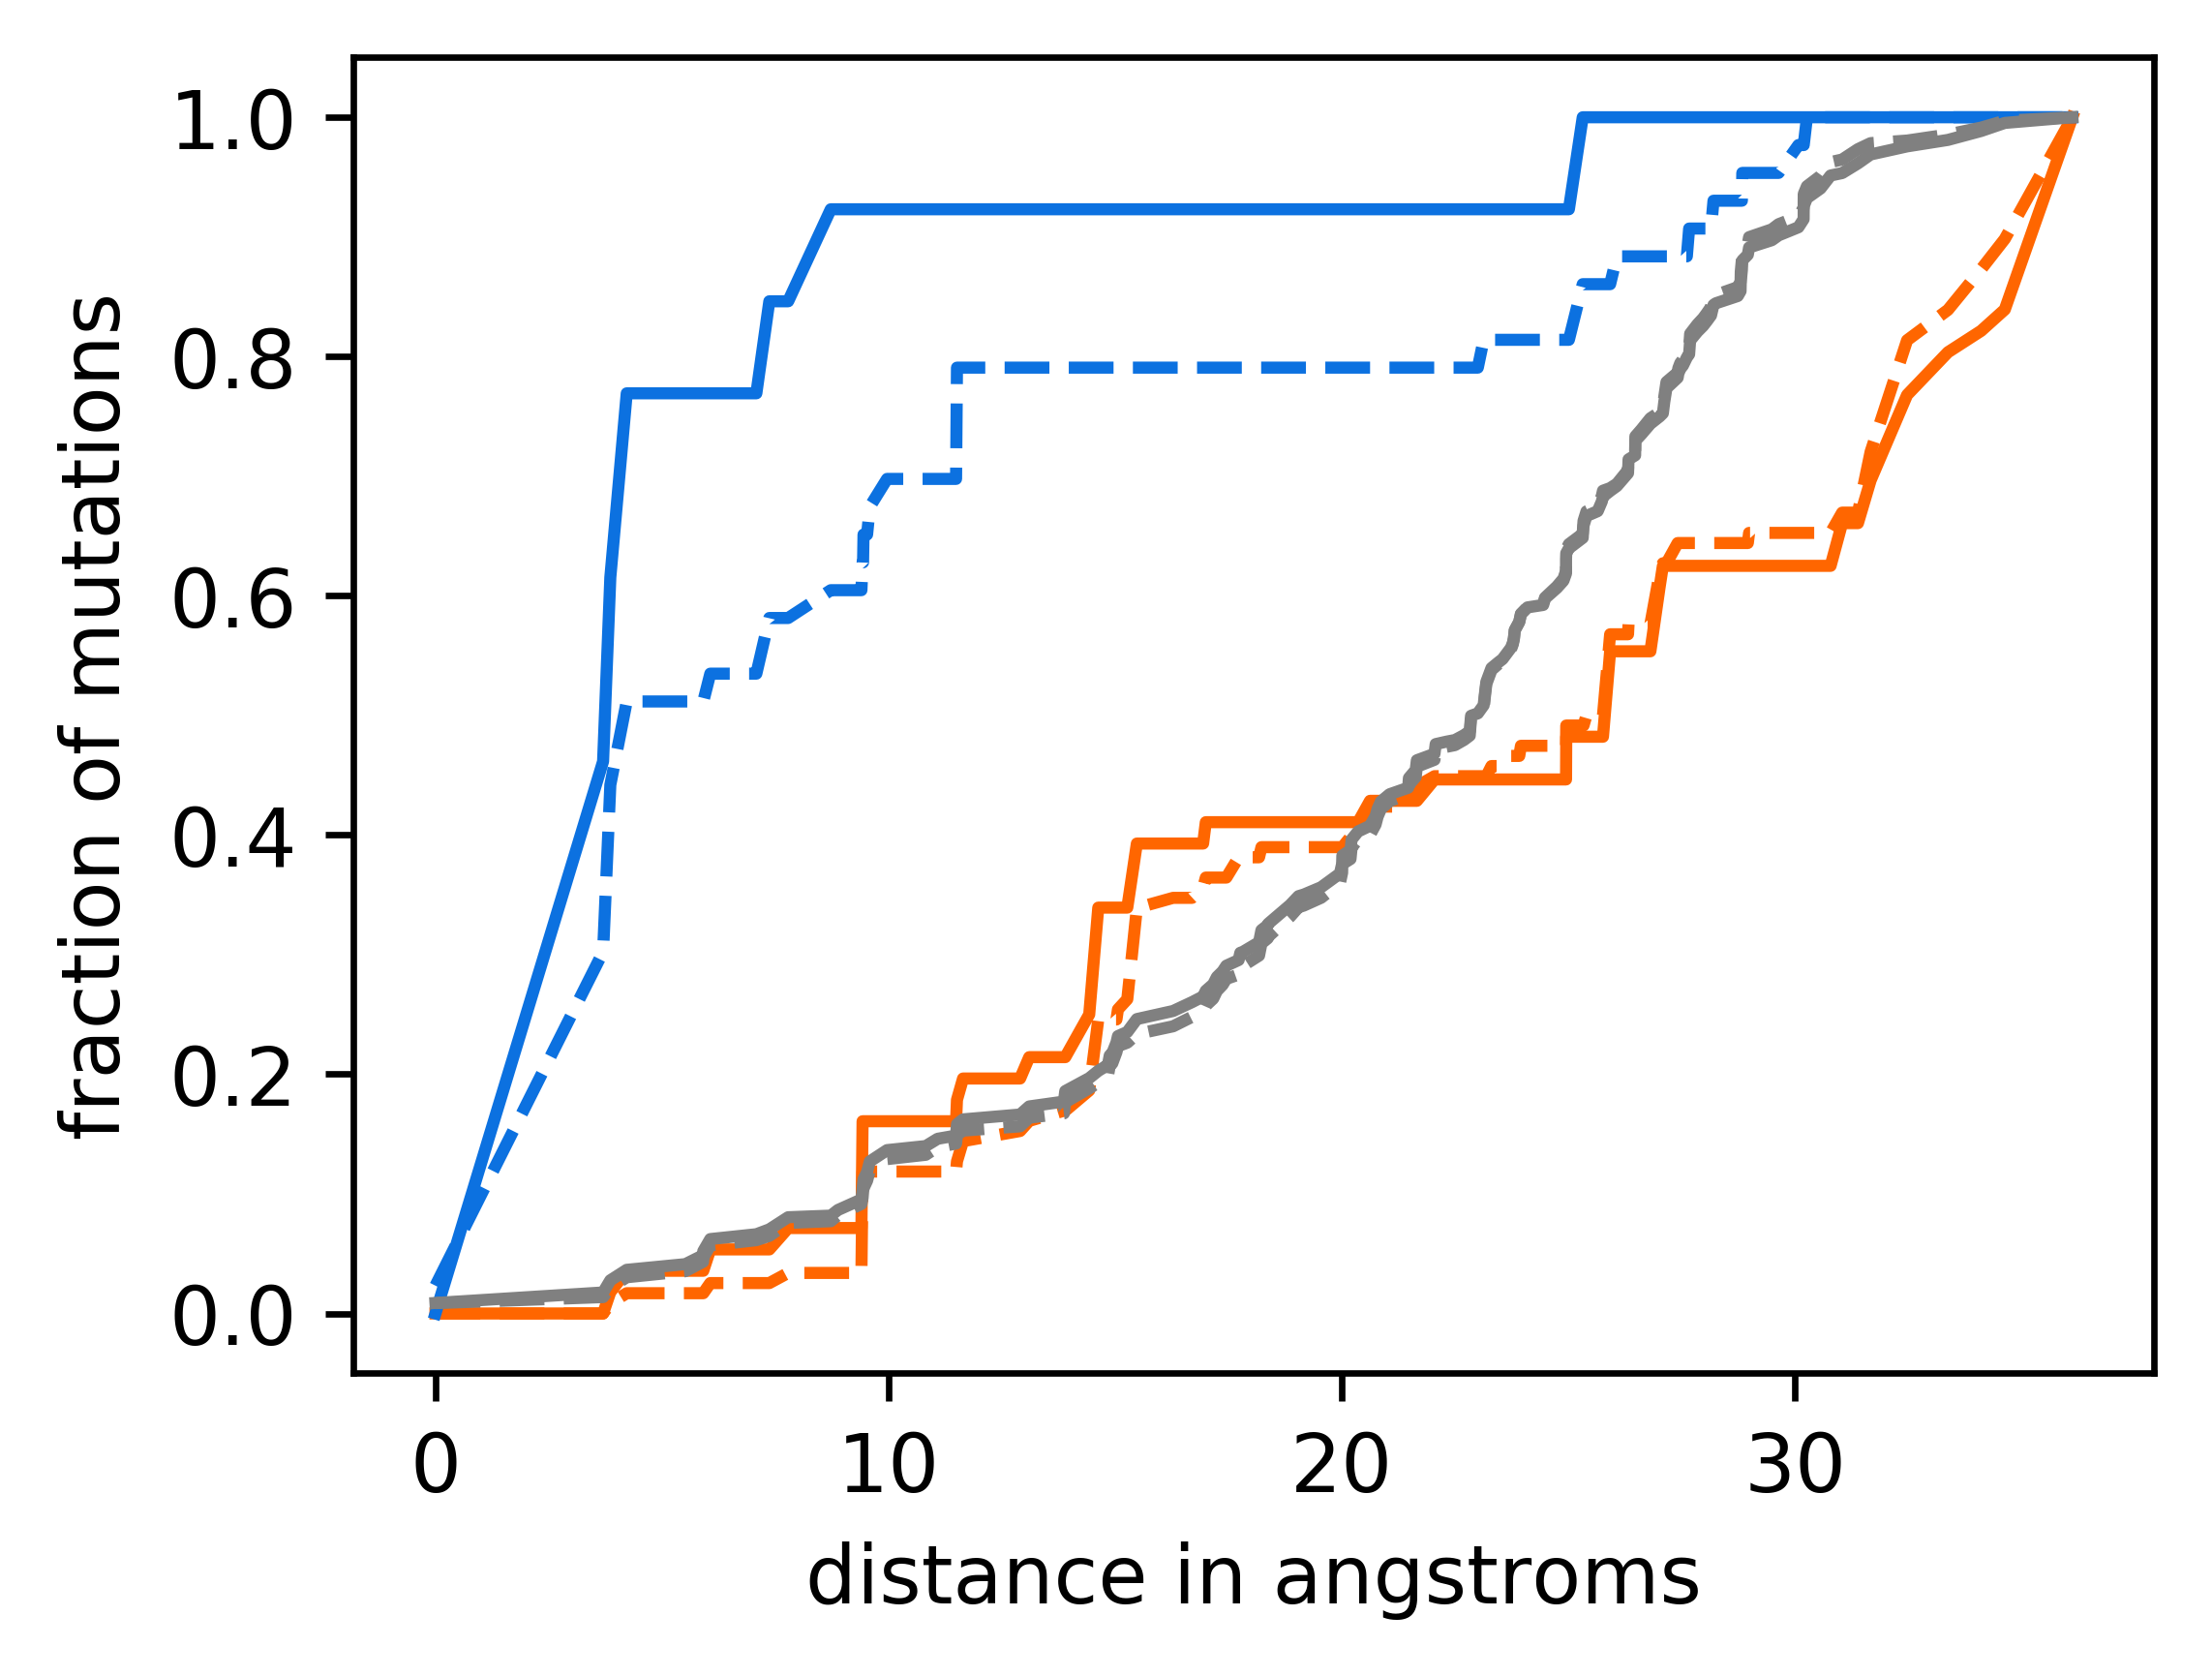

In [44]:
#plot the results
plt.rcParams['figure.figsize'] = (4,3)

plt.plot(enhance_allosterySGoF_cd[:,2],enhance_allosterySGoF_cd[:,3],'-',color='#FF6600')
plt.plot(enhance_allostery05_cd[:,2],enhance_allostery05_cd[:,3],'--',color='#FF6600')
plt.plot(disrupt_allosterySGoF_cd[:,2],disrupt_allosterySGoF_cd[:,3],'-',color='#0C71E0')
plt.plot(disrupt_allostery05_cd[:,2],disrupt_allostery05_cd[:,3],'--',color='#0C71E0')
plt.plot(nonsig_allosterySGoF_cd[:,2],nonsig_allosterySGoF_cd[:,3],'-',color='grey')
plt.plot(nonsig_allostery05_cd[:,2],nonsig_allostery05_cd[:,3],'--',color='grey')

plt.xlabel('distance in angstroms', fontsize=10)
plt.ylabel('fraction of mutations', fontsize=10)

#plt.savefig('FigPanels/DistTo121.pdf')

### Save out the results, compiled as a dictionary within a pickle database

In [45]:
D = {}
D['sig05_allo_pos'] =sig05_allo_pos; D['sigSGoF_allo_pos'] = sigSGoF_allo_pos
D['sig05_allo_enhance_pos'] = sig05_allo_enhance_pos; D['sigSGoF_allo_enhance_pos'] = sigSGoF_allo_enhance_pos
D['sig05_allo_disrupt_pos'] = sig05_allo_disrupt_pos; D['sigSGoF_allo_disrupt_pos'] = sigSGoF_allo_disrupt_pos

D['sig05_allo_mut']=sig05_allo_mut; D['sigSGoF_allo_mut'] = sigSGoF_allo_mut
D['nonsig05_allo_mut']=nonsig05_allo_mut; D['nonsigSGoF_allo_mut'] = nonsigSGoF_allo_mut

D['sig05_allo_enhance_mut'] = sig05_allo_enhance_mut; D['sigSGoF_allo_enhance_mut'] = sigSGoF_allo_enhance_mut
D['nonsig05_allo_enhance_mut'] = nonsig05_allo_enhance_mut; D['nonsigSGoF_allo_enhance_mut'] = nonsigSGoF_allo_enhance_mut

D['sig05_allo_disrupt_mut'] = sig05_allo_disrupt_mut; D['sigSGoF_allo_disrupt_mut']=sigSGoF_allo_disrupt_mut 
D['nonsig05_allo_disrupt_mut'] = nonsig05_allo_disrupt_mut; D['nonsigSGoF_allo_disrupt_mut'] = nonsigSGoF_allo_disrupt_mut

filename = 'output/sig_allostery_pickle.pkl'
outfile = open(filename,'wb')
pickle.dump(D,outfile)
outfile.close()